# BTC Prediction (Modeling Stage)

### This notebook contains:

The prediction of BTCs next day close price using various models and methods. The X variable is the features used to predict the price, and the y variable is our target prediction. The target prediction is simply the next days close price shifted to fit each row. 

#### Models Used:

- Linear regression (LR)
    - Ordinary Least Squares (OLS)
    - Lasso
    - Ridge
- Random forest regression (RFR)
- Time series forecasting with long short term memory (LSTM)

Both linear and random forest regression utilize _GridSearchCV()_ to tune hyperparameters. Using grid search through the model pipeline I added an additional tuner as _PolynomialFeatures()_. Polynomial features usually improves linear regression models significantly. For the regression specific portion of testing I compute the R2, MAE, MSE, MAPE, RMSE score for each model and additionally the OOB (Out of Bag) score for the RFR. 

As for the time series forecasting using LSTM, I utilize a "Keras" wrapper called "Hyperas" in order to tune the LSTM hyperparameters (i.e. Dropout, Activation, Dense, Optimizer, Batch Size and Epochs). Hyperas is a more streamlined version of "Hyperopt", providing a more versatile way to alter parameters and tune layers. The loss metric used is MSE in conjunction with the MAE. Since the overall goal of the project is a regression "problem", accuracy is not applicable. Accuracy as a measure only applies for classification (discrete outputs), comparing for equality. With regression we are predicting a continuous value (price), so if the target is 0.99 and the network predicts 1.0, then it would be considered as misclassified. 

That being said, after running the models you will see graphical representations as subplots(scatter and line plot) demonstrating their performance for each. The visuals show the actual close price compared to the predicted price from each model. The LSTM also includes a plot of the training loss compared to the validation loss.

In [1]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model, preprocessing
from sklearn.metrics import accuracy_score
from sklearn import metrics

import statsmodels.api as sm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

%config InlineBackend.figure_format='retina'
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)

import warnings
warnings.filterwarnings('ignore')

In [142]:
dataset = pd.read_csv('data/train.csv', index_col='Date')

In [3]:
dataset.head()

close    volume     ema_short      ema_long         atr  \
Date                                                                     
2019-09-02  10340.00  44740.25  10164.518939  10452.265343  530.693553   
2019-09-03  10615.28  47998.38  10207.448563  10458.658074  528.572585   
2019-09-04  10567.02  43943.89  10241.693462  10462.907561  521.468114   
2019-09-05  10564.49  33970.96  10272.435990  10466.891187  516.363249   
2019-09-06  10298.73  58799.64  10274.940181  10460.296630  533.470874   

                      obv  tweet_sentiment  close_nextday  
Date                                                       
2019-09-02  225053.863244             -1.0       10615.28  
2019-09-03  273052.240025              0.5       10567.02  
2019-09-04  229108.350999              0.5       10564.49  
2019-09-05  195137.390360              0.5       10298.73  
2019-09-06  136337.749401              0.0       10455.88

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 441 entries, 2019-09-02 to 2020-11-15
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   close            441 non-null    float64
 1   volume           441 non-null    float64
 2   ema_short        441 non-null    float64
 3   ema_long         441 non-null    float64
 4   atr              441 non-null    float64
 5   obv              441 non-null    float64
 6   tweet_sentiment  441 non-null    float64
 7   close_nextday    441 non-null    float64
dtypes: float64(8)
memory usage: 31.0+ KB


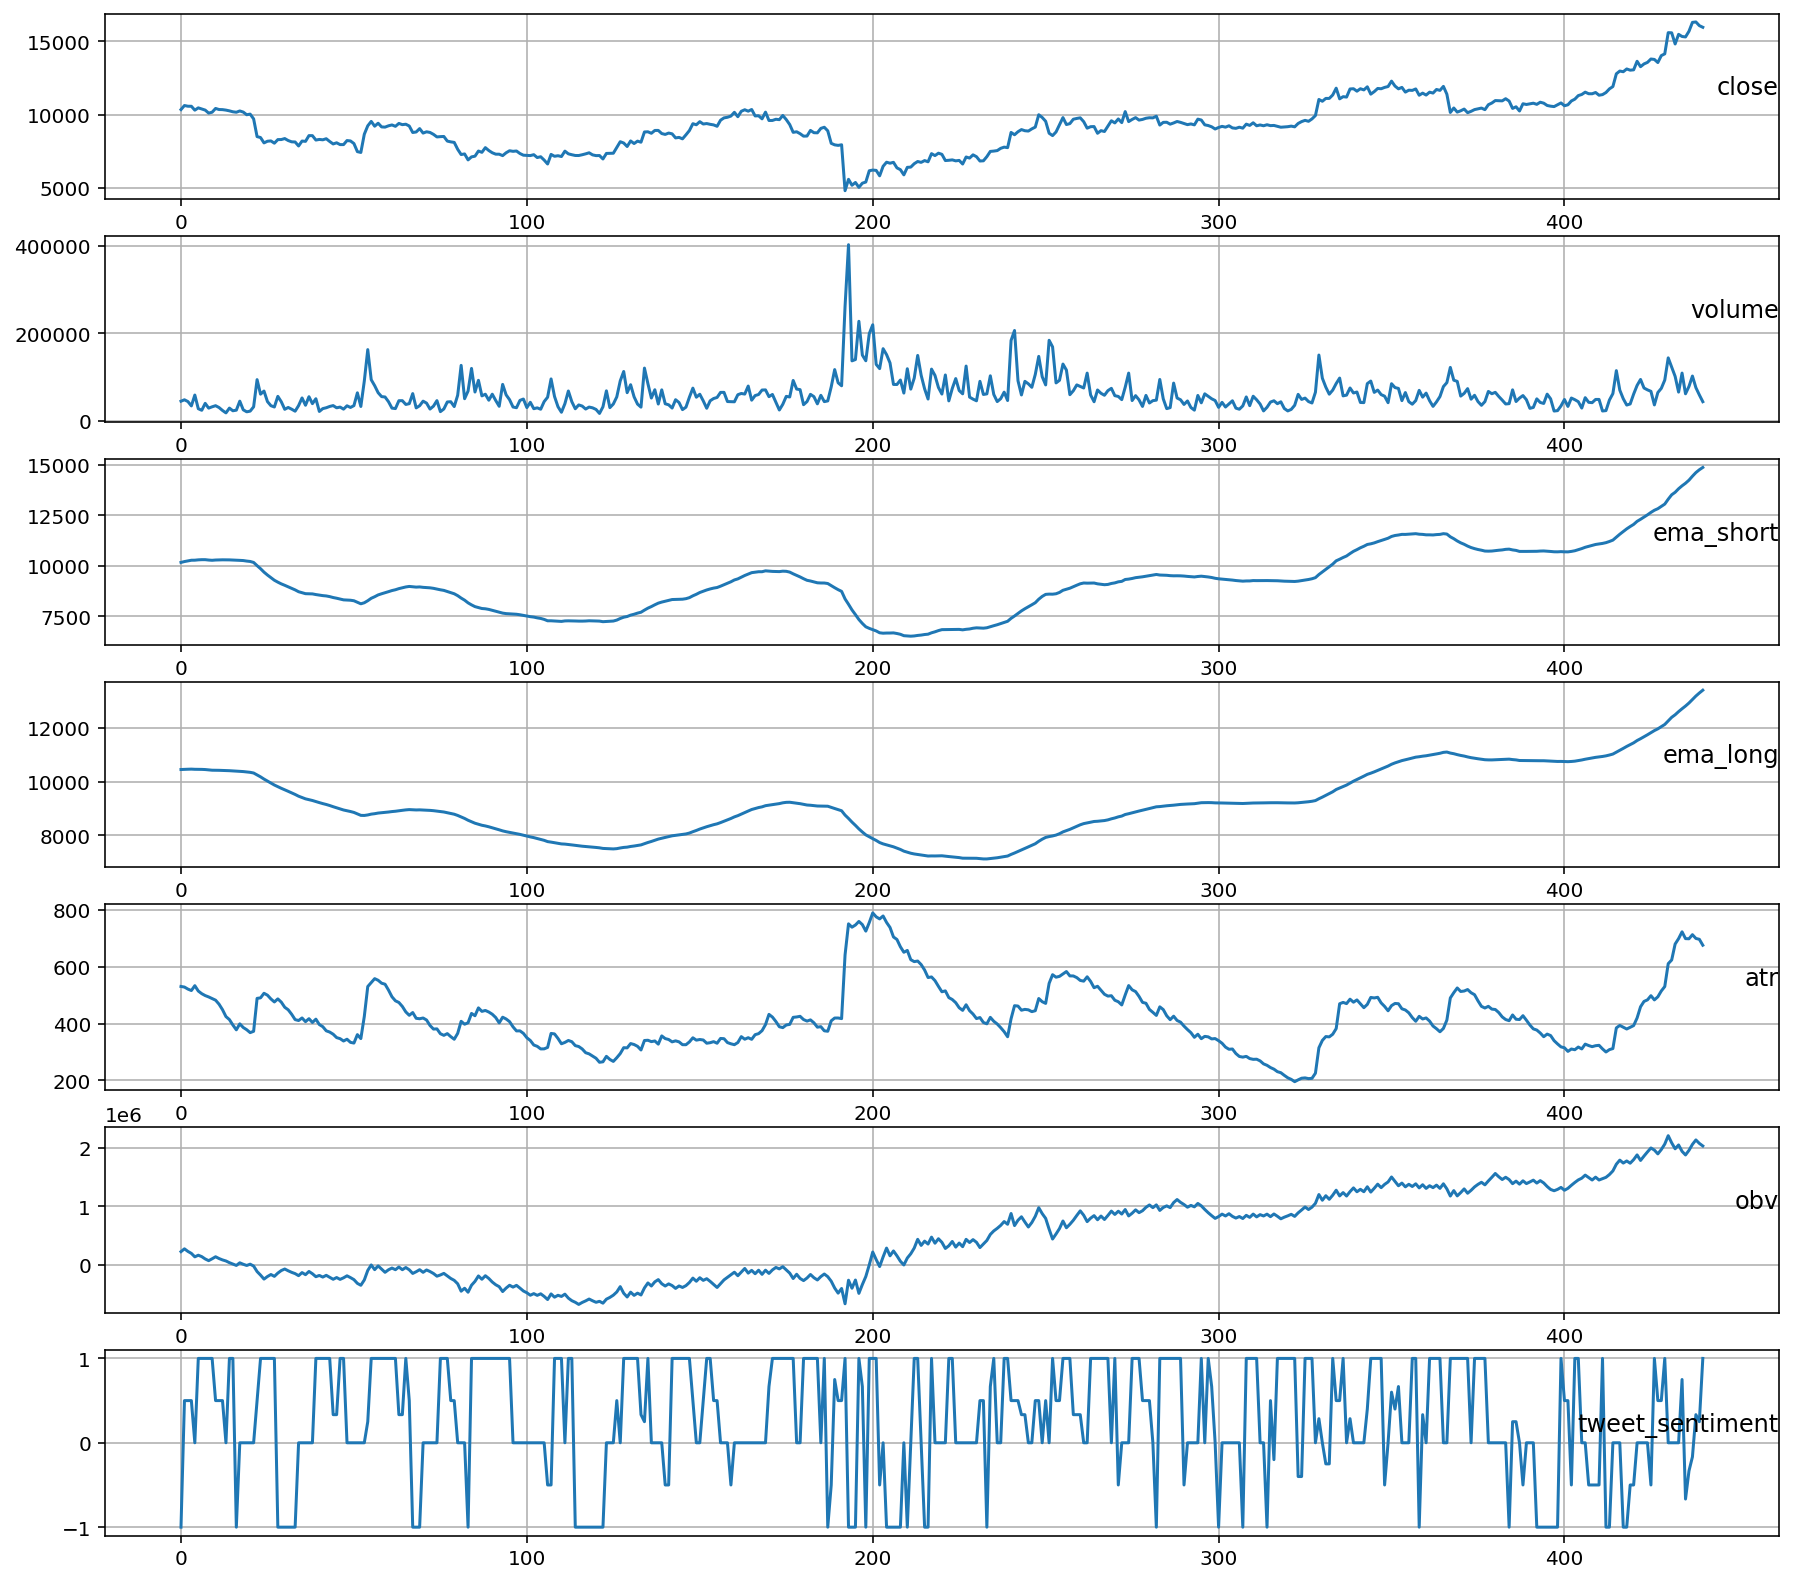

In [5]:
import matplotlib.pyplot as plt

values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure(figsize=(15, 14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.grid(True)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
    
plt.style.use('seaborn-dark-palette')
plt.show()

# Modeling

We split the original dataset using _TimeSeriesSplit()_, making our X every feature except "close_nextday". The target is "close_nextday" so we use that variable as our y. The split used was a 75% train and 25% test. X_train and y_train are the first 75% of the original dataset and X_test, y_test contain the last 25% of the original dataset.

### Techniques:

##### - Ordinary Least Squares (OLS)
    
Minimizes bias of OLS function with the "Best Linear Unbiased Estimator" (BLUE).
    
\begin{equation}
\mathcal{L}_{OLS} = ||Y-X^T\beta||^2
\end{equation}
    
##### - Lasso

Different minimization function than OLS. Penalizes large beta values.
    
\begin{equation}
\mathcal{L}_{LASSO}  = ||Y - X^T\beta||^2 + \lambda ||\beta||
\end{equation}

##### - Ridge

Has a similar penalty of beta values as Lasso, but has a different "bias".
    
\begin{equation}
\mathcal{L}_{Ridge} = ||Y - X^T\beta||^2 + \lambda ||\beta||^2
\end{equation}
<br>
<br>

**Both Lasso and Ridge Regressions are considered to have _good_ bias as long as:**

\begin{equation}
\lambda > 0
\end{equation}

**They are considered to be "better" in performance compared to OLS because of this _good_ bias, although, that is not always the case.** 
<br>
##### - Random Forest Regressor (RFR)

A supervised learning ensemble method that uses a bagging technique where its trees run parallel and do not interact. As a "meta-estimator" it combines multiple predictions (trees), and produces outputs from the best performance of those aggregate estimations.

### Tuning Hyperparameters:

##### - Pipeline
- PolynomialFeatures()
- OLS, Lasso, Ridge



##### - GridSearchCV Params:
- Lasso, Ridge: "fit_alpha"
- RFR: "n_estimators", "max_depth", "max_features", "bootstrap"

## Train/Test

In [143]:
# Subset dataset into X, y. X is features, y is target

X = dataset.drop(labels=['close_nextday'], axis=1)
y = dataset['close_nextday']

print(y.head())

Date
2019-09-02    10615.28
2019-09-03    10567.02
2019-09-04    10564.49
2019-09-05    10298.73
2019-09-06    10455.88
Name: close_nextday, dtype: float64


In [144]:
# Split X, y using TimeSeriesSplit() into X_train, X_test, y_train, y_test. First 75% is training, 25% is test

tss = TimeSeriesSplit(n_splits=3)  # n_splits = 3-1...2 splits

for train_index, test_index in tss.split(X):
    X_train_split, X_test_split = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train_split, y_test_split = y.iloc[train_index], y.iloc[test_index]

In [145]:
# Check train, test splits for correct date alignment and matching shape

print("X_train:\n", X_train_split, X_train_split.shape, "\n", '\nX_test:\n', X_test_split,
      X_test_split.shape)
print("\n")
print("y_train:\n", y_train_split, y_train_split.shape, "\n", '\ny_test:\n', y_test_split,
      y_test_split.shape)

X_train:
                close     volume     ema_short      ema_long         atr  \
Date                                                                      
2019-09-02  10340.00   44740.25  10164.518939  10452.265343  530.693553   
2019-09-03  10615.28   47998.38  10207.448563  10458.658074  528.572585   
2019-09-04  10567.02   43943.89  10241.693462  10462.907561  521.468114   
2019-09-05  10564.49   33970.96  10272.435990  10466.891187  516.363249   
2019-09-06  10298.73   58799.64  10274.940181  10460.296630  533.470874   
...              ...        ...           ...           ...         ...   
2020-07-24   9537.80   43931.14   9319.820787   9252.782403  206.397467   
2020-07-25   9700.42   40679.55   9356.068331   9270.336819  207.361933   
2020-07-26   9931.54   65279.27   9410.875156   9296.266355  225.478938   
2020-07-27  11029.96  150188.93   9565.073713   9364.254341  314.919728   
2020-07-28  10906.27   97267.73   9692.806693   9424.725543  340.799033   

              

In [146]:
# Reshape y train, test to match X train, test

y_train = y_train_split.values.reshape(-1, 1)
y_test = y_test_split.values.reshape(-1, 1)

print(y_test)

[[11099.61]
 [11335.46]
 [11801.17]
 [11071.35]
 [11219.81]
 [11191.97]
 [11744.91]
 [11762.46]
 [11594.23]
 [11761.41]
 [11681.68]
 [11892.92]
 [11392.08]
 [11564.33]
 [11780.  ]
 [11760.54]
 [11852.4 ]
 [11911.  ]
 [12281.13]
 [11945.01]
 [11754.59]
 [11853.55]
 [11531.34]
 [11662.96]
 [11648.13]
 [11748.2 ]
 [11318.42]
 [11461.43]
 [11330.38]
 [11526.91]
 [11465.84]
 [11711.16]
 [11649.51]
 [11921.97]
 [11388.54]
 [10140.85]
 [10446.25]
 [10166.69]
 [10256.2 ]
 [10373.44]
 [10126.65]
 [10219.2 ]
 [10336.87]
 [10387.89]
 [10440.92]
 [10332.83]
 [10671.77]
 [10785.31]
 [10954.01]
 [10939.99]
 [10933.39]
 [11080.65]
 [10920.28]
 [10417.22]
 [10529.61]
 [10241.46]
 [10736.32]
 [10686.67]
 [10728.6 ]
 [10774.25]
 [10696.12]
 [10840.48]
 [10776.59]
 [10619.13]
 [10570.4 ]
 [10542.06]
 [10666.63]
 [10792.21]
 [10599.66]
 [10666.39]
 [10925.57]
 [11050.64]
 [11293.22]
 [11369.02]
 [11528.25]
 [11420.56]
 [11417.89]
 [11505.12]
 [11319.32]
 [11360.2 ]
 [11503.14]
 [11751.47]
 [11909.99]
 [12

In [147]:
# Scale X_train, X_test, y_train, y_test to prevent overfitting and minimize outliers like large values

ss = StandardScaler()

X_train = ss.fit_transform(X_train_split)
X_test = ss.fit_transform(X_test_split)
y_train = ss.fit_transform(y_train)
y_test = ss.fit_transform(y_test)

In [148]:
# Make sure shape is same before scaling. 

print("X Train:", type(X_train), X_train.shape, len(X_train))
print("\nX Test:", type(X_test), X_test.shape, len(X_test))
print("\ny Train:", type(y_train), y_train.shape, len(y_train))
print("\ny Test:", type(y_test), y_test.shape, len(y_test))

X Train: <class 'numpy.ndarray'> (331, 7) 331

X Test: <class 'numpy.ndarray'> (110, 7) 110

y Train: <class 'numpy.ndarray'> (331, 1) 331

y Test: <class 'numpy.ndarray'> (110, 1) 110


In [12]:
# Test function to run prediction error metrics from model pipline 

def test(models, iterations=100):
    results = {}
    for i in models:
        r2_test = []
        r2_train = []
        MAE_test = []
        MAE_train = []
        MSE_test = []
        MSE_train = []
        MAPE_test = []
        MAPE_train = []
        for j in range(iterations):
            r2_test.append(
                metrics.r2_score(
                    y_test, models[i].fit(X_train, y_train).predict(X_test)))
            r2_train.append(
                metrics.r2_score(
                    y_train, models[i].fit(X_train, y_train).predict(X_train)))
            MAE_test.append(
                metrics.mean_absolute_error(
                    y_test, models[i].fit(X_train, y_train).predict(X_test)))
            MAE_train.append(
                metrics.mean_absolute_error(
                    y_train, models[i].fit(X_train, y_train).predict(X_train)))
            MSE_test.append(
                metrics.mean_squared_error(
                    y_test, models[i].fit(X_train, y_train).predict(X_test)))
            MSE_train.append(
                metrics.mean_squared_error(
                    y_train, models[i].fit(X_train, y_train).predict(X_train)))
            MAPE_test.append(
                metrics.mean_absolute_percentage_error(
                    y_test, models[i].fit(X_train, y_train).predict(X_test)))
            MAPE_train.append(
                metrics.mean_absolute_percentage_error(
                    y_train, models[i].fit(X_train, y_train).predict(X_train)))

        results[i] = [
            np.mean(r2_train),
            np.mean(r2_test),
            np.mean(MAE_train),
            np.mean(MAE_test),
            np.mean(MSE_train),
            np.mean(MSE_test),
            np.mean(MAPE_train),
            np.mean(MAPE_test)
        ]

    return pd.DataFrame(results)

In [13]:
# Build GridSearchCV params for models with pipeline

lasso_params = {'fit__alpha':[0.005, 0.02, 0.03, 0.05, 0.06]}
ridge_params = {'fit__alpha':[550, 580, 600, 620, 650]}
rfr_params = {
    "n_estimators": [100, 200, 300, 400, 500],
    'max_depth': range(20, 30),
    #'min_samples_split': range(1, 10),
    #'min_samples_leaf': range(1, 5),
    "max_features": ["auto"],
    "bootstrap": [True, False]
}

pipe1 = Pipeline([('fit', linear_model.LinearRegression())])
pipe2 = Pipeline([('fit', linear_model.Lasso())])
pipe3 = Pipeline([('fit', linear_model.Ridge())])

models = {
    'OLS':
    pipe1,
    'Lasso':
    GridSearchCV(pipe2, param_grid=lasso_params).fit(
        X_train, y_train).best_estimator_,
    'Ridge':
    GridSearchCV(pipe3, param_grid=ridge_params).fit(
        X_train, y_train).best_estimator_,
    'RFR':
    GridSearchCV(RandomForestRegressor(oob_score=True), param_grid=rfr_params).fit(
        X_train, y_train).best_estimator_,
}

In [14]:
models.keys()

dict_keys(['OLS', 'Lasso', 'Ridge', 'RFR'])

In [15]:
# Create model test variables for visual performance evaluation

pred_ols = models['OLS'].fit(X_train, y_train).predict(X_test)
pred_lasso = models['Lasso'].fit(X_train, y_train).predict(X_test)
pred_ridge = models['Ridge'].fit(X_train, y_train).predict(X_test)
pred_rfr = models['RFR'].fit(X_train, y_train).predict(X_test)

In [16]:
# Model performance comparision between train and test

scores = test(models)
scores = scores.T
scores.columns = [
    'R^2 Test', 'R^2 Train', 'MAE Test', 'MAE Train', 'MSE Test', 'MSE Train',
    'MAPE Test', 'MAPE Train'
]
scores['RMSE Train'] = scores['MSE Train']**2
scores['RMSE Test'] = scores['MSE Test']**2
scores['OOB Train'] = models['RFR'].fit(X_train, y_train).oob_score_
scores.iloc[0,10] = "NA"
scores.iloc[1,10] = "NA"
scores.iloc[2,10] = "NA"

scores.head()

R^2 Test  R^2 Train  MAE Test  MAE Train  MSE Test  MSE Train  \
OLS    0.931316   0.960322  0.163563   0.133600  0.068684   0.039678   
Lasso  0.931098   0.960447  0.163392   0.133791  0.068902   0.039553   
Ridge  0.724233   0.722707  0.420577   0.420029  0.275767   0.277293   
RFR    0.988110   0.917579  0.068695   0.202756  0.011822   0.082351   

       MAPE Test  MAPE Train  RMSE Train  RMSE Test OOB Train  
OLS     0.761107    0.622320    0.001574   0.004718        NA  
Lasso   0.762116    0.627204    0.001564   0.004748        NA  
Ridge   1.212705    0.800774    0.076892   0.076047        NA  
RFR     0.478676    0.943217    0.006782   0.000140  0.912306

In [141]:
y_test.shape, pred_ols.shape

((80, 1), (110, 1))

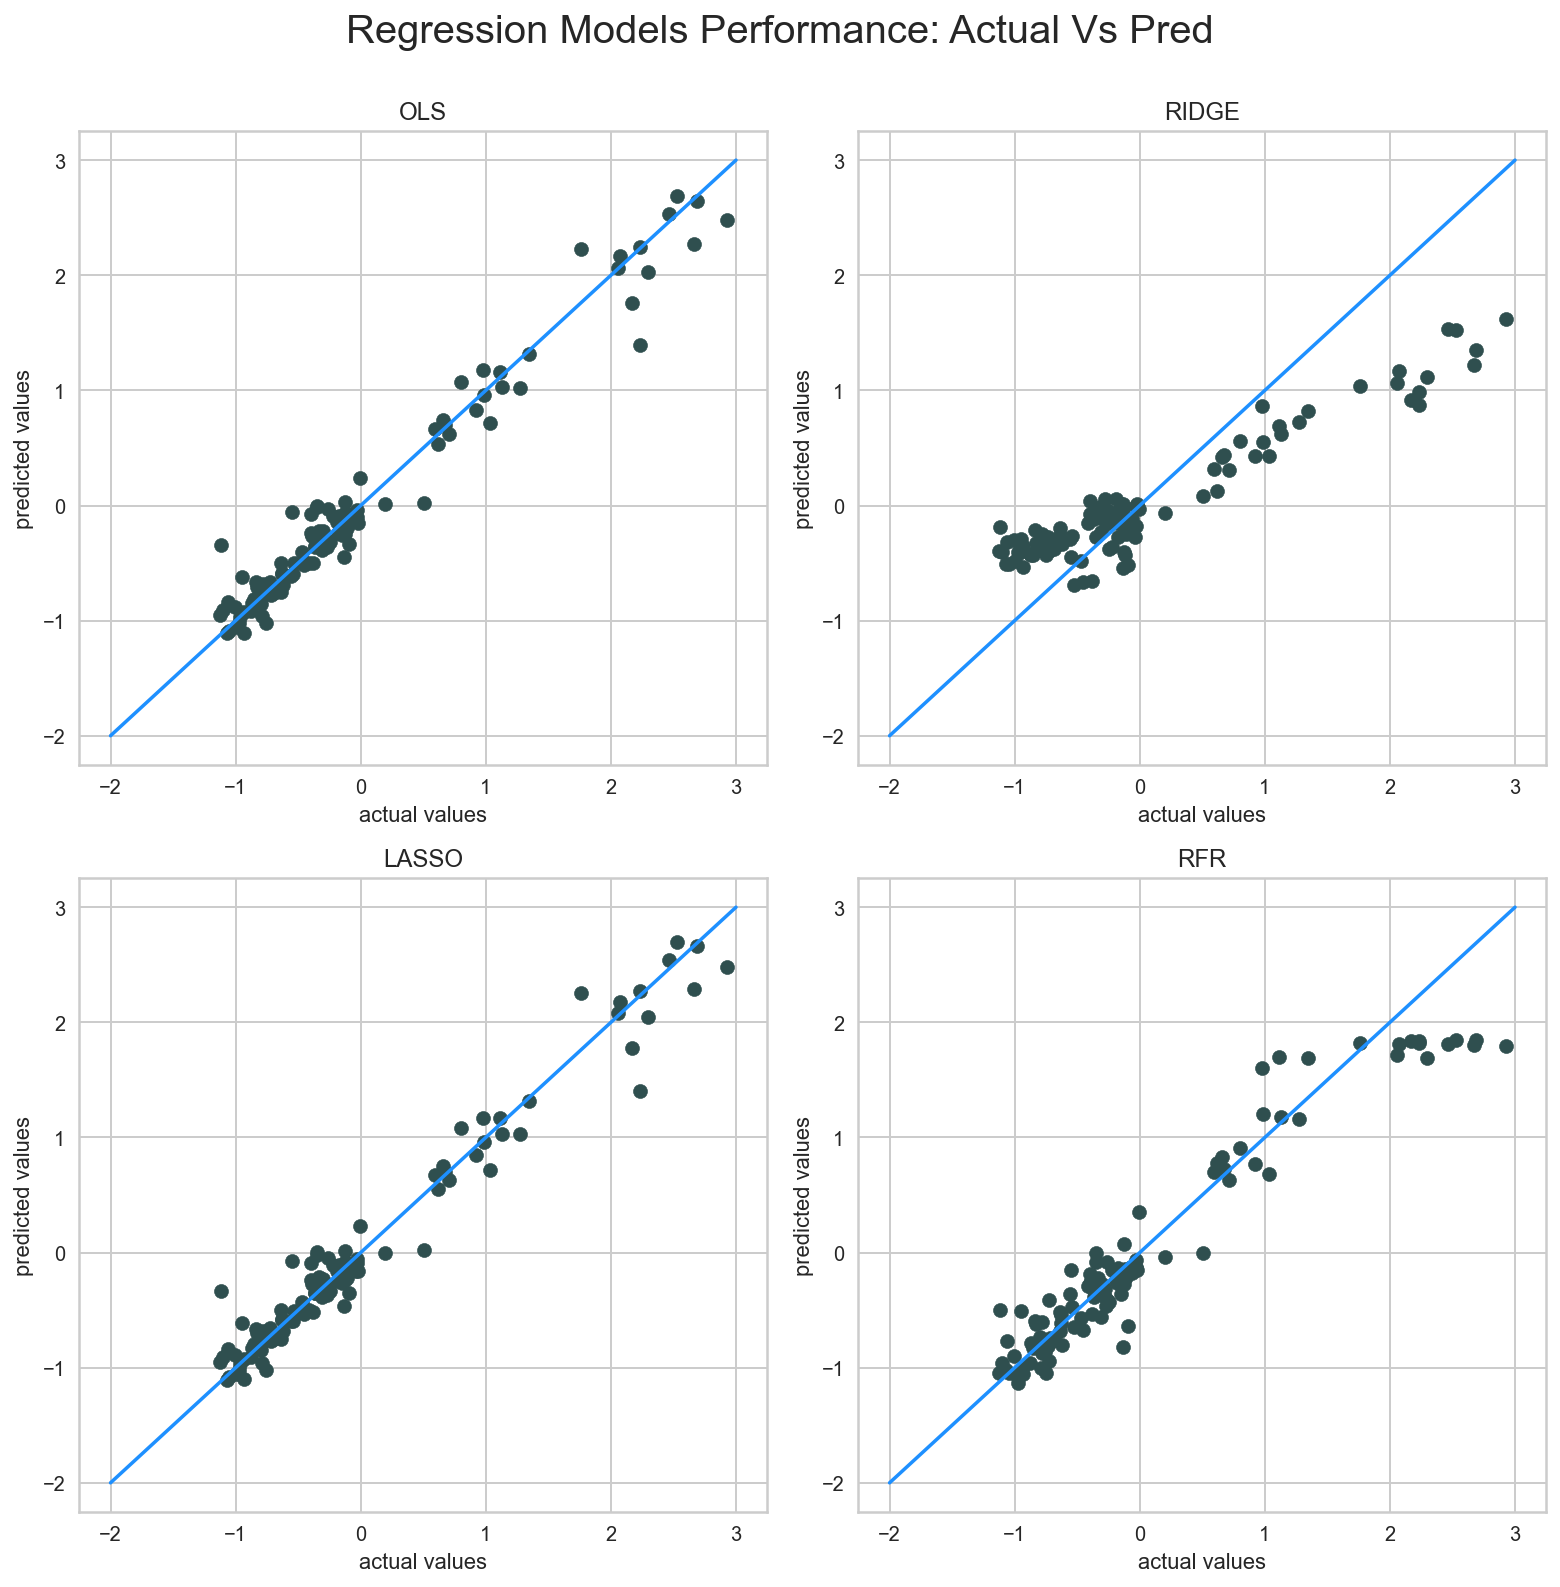

In [171]:
# Performance visual for each model, prediction vs actual subplots

fig, axs = plt.subplots(2, 2, figsize=(11, 11))
fig.suptitle('Regression Models Performance: Actual Vs Pred', fontsize=20, y=1)

colors = ['darkslategrey']

axs[0, 0].scatter(y_test, pred_ols, c=colors)
axs[0, 0].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='dodgerblue')
axs[0, 0].set_xlabel('actual values')
axs[0, 0].set_ylabel('predicted values')
axs[0, 0].set_title("OLS")
#axs[0, 0].grid(True)

axs[1, 0].scatter(y_test, pred_lasso, c=colors)
axs[1, 0].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='dodgerblue')
axs[1, 0].set_xlabel('actual values')
axs[1, 0].set_ylabel('predicted values')
axs[1, 0].set_title("LASSO")
#axs[1, 0].grid(True)

axs[0, 1].scatter(y_test, pred_ridge, c=colors)
axs[0, 1].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='dodgerblue')
axs[0, 1].set_xlabel('actual values')
axs[0, 1].set_ylabel('predicted values')
axs[0, 1].set_title("RIDGE")
#axs[0, 1].grid(True)

axs[1, 1].scatter(y_test, pred_rfr, c=colors)
axs[1, 1].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='dodgerblue')
axs[1, 1].set_title("RFR")
axs[1, 1].set_xlabel('actual values')
axs[1, 1].set_ylabel('predicted values')
#axs[1, 1].grid(True)

fig.tight_layout()
plt.show()

fig.savefig('RegModels_ActualVsPred_subplot1.png', transparent=False)

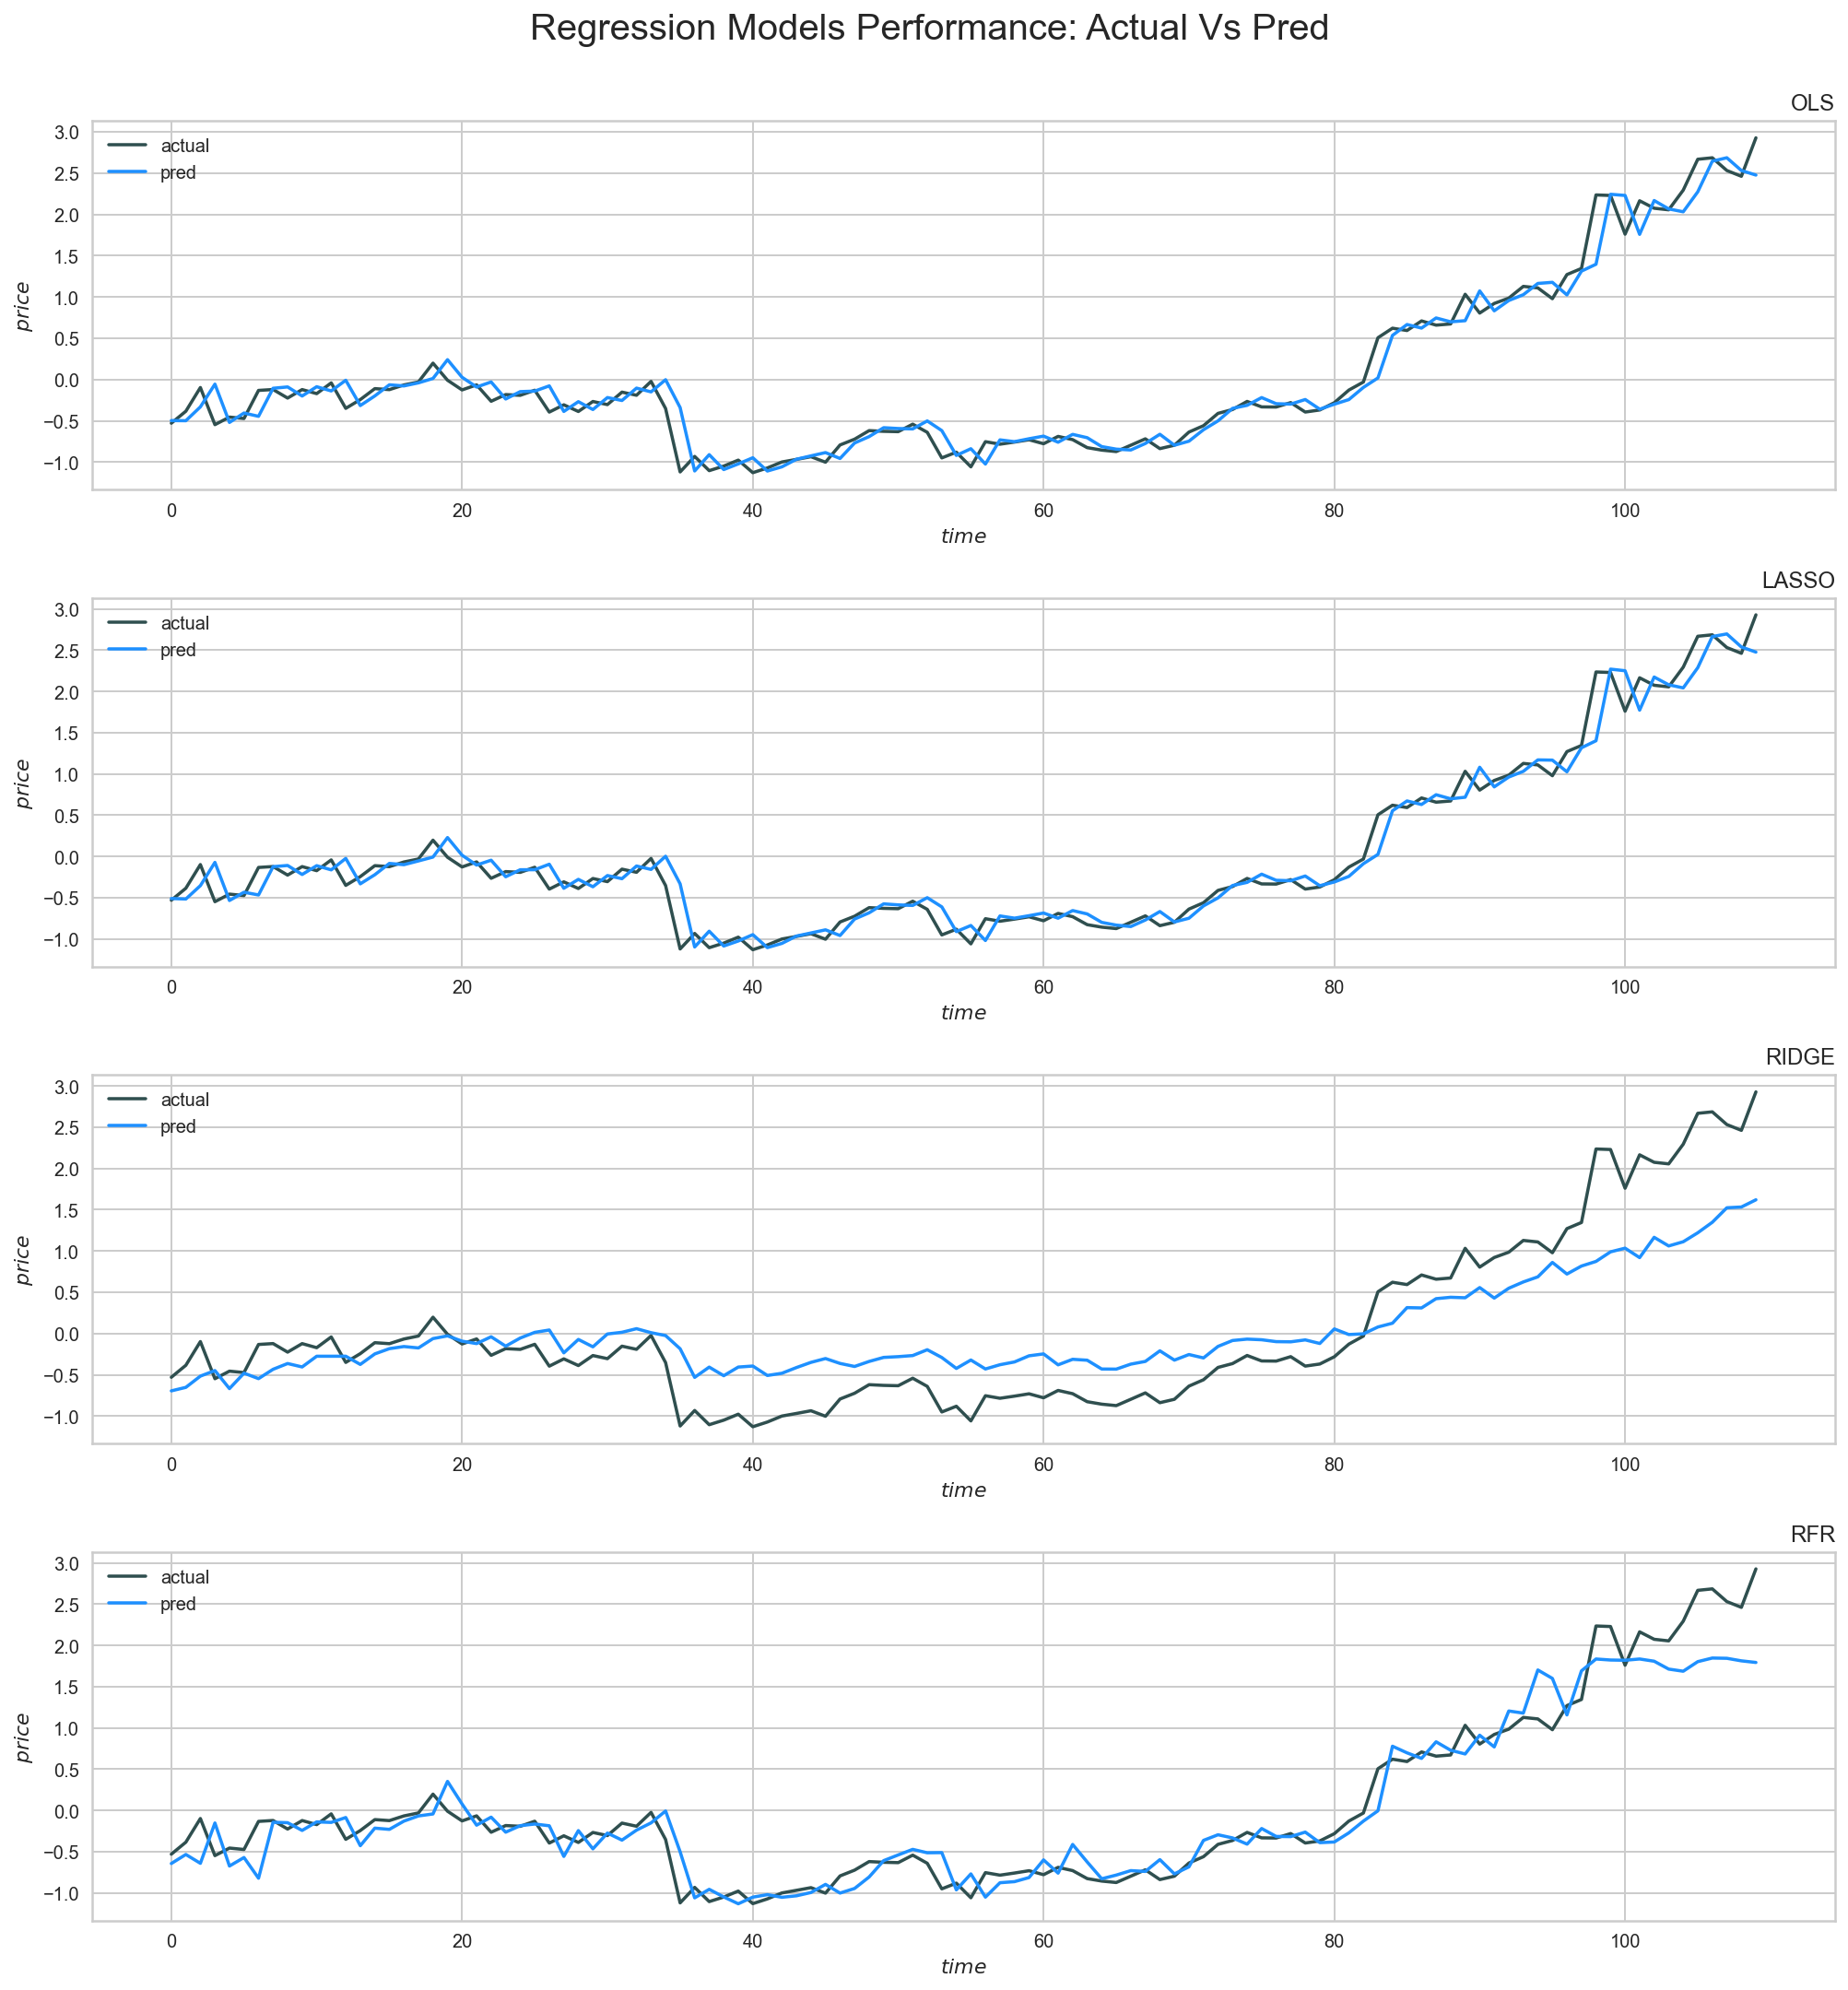

In [172]:
# Performance visual for each model, prediction vs actual subplots

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(14, 15))
fig.suptitle('Regression Models Performance: Actual Vs Pred', fontsize=20, y=1)

ax1.plot(y_test, 'darkslategrey')
ax1.plot(pred_ols, 'dodgerblue')
ax1.set_ylabel('$price$')
ax1.set_xlabel('$time$')
ax1.grid(True)
ax1.legend(["actual", "pred"])
ax1.set_title("OLS", loc='right')

ax2.plot(y_test, 'darkslategrey')
ax2.plot(pred_lasso, 'dodgerblue')
ax2.set_ylabel('$price$')
ax2.set_xlabel('$time$')
ax2.grid(True)
ax2.legend(["actual", "pred"])
ax2.set_title("LASSO", loc='right')

ax3.plot(y_test, 'darkslategrey')
ax3.plot(pred_ridge, 'dodgerblue')
ax3.set_ylabel('$price$')
ax3.set_xlabel('$time$')
ax3.grid(True)
ax3.legend(["actual", "pred"])
ax3.set_title("RIDGE", loc='right')

ax4.plot(y_test, 'darkslategrey')
ax4.plot(pred_rfr, 'dodgerblue')
ax4.set_ylabel('$price$')
ax4.set_xlabel('$time$')
ax4.grid(True)
ax4.legend(["actual", "pred"])
ax4.set_title("RFR", loc='right')

fig.tight_layout()
#plt.style.use('seaborn-dark-palette')
plt.grid(True)
plt.show()

fig.savefig('RegModels_ActualVsPred_subplot2.png', transparent=False)

## Model Interpretability (OLS, Lasso, Ridge, RFR)

In [19]:
# Import interpretability packages

from yellowbrick.regressor import ResidualsPlot, residuals_plot # to plot residuals
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette # enhance visuals with color
import seaborn as sns

import lime # A local interpretable model-agnostic explainer
import lime.lime_tabular # Attribute for tabular dataset predictions (numpy arrays etc.)

In [20]:
# Create Lime explainer model

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    verbose=True,
    mode='regression',
    feature_names=['close', 'volume', 'ema_short', 'ema_long', 'atr', 'obv', 'tweet_sentiment'])

In [21]:
model_features=['close', 'volume', 'ema_short', 'ema_long', 'atr', 'obv', 'tweet_sentiment']

### OLS

#### Residual Plot

The plot shows us the difference between the observed value of the target variable (y) and the predicted value (ŷ), i.e. the error of the prediction. Using a scatter plot and histogram we can see the distribution for prediction errors on both test and train sets.

The OLS model had a relatively normal distribution of errors, and performed well in correcting the errors made from training. The R2 improved significantly by almost +0.03 points. Since the OLS framework is designed to minimize its squared errors, we can see it acting accordingly below.

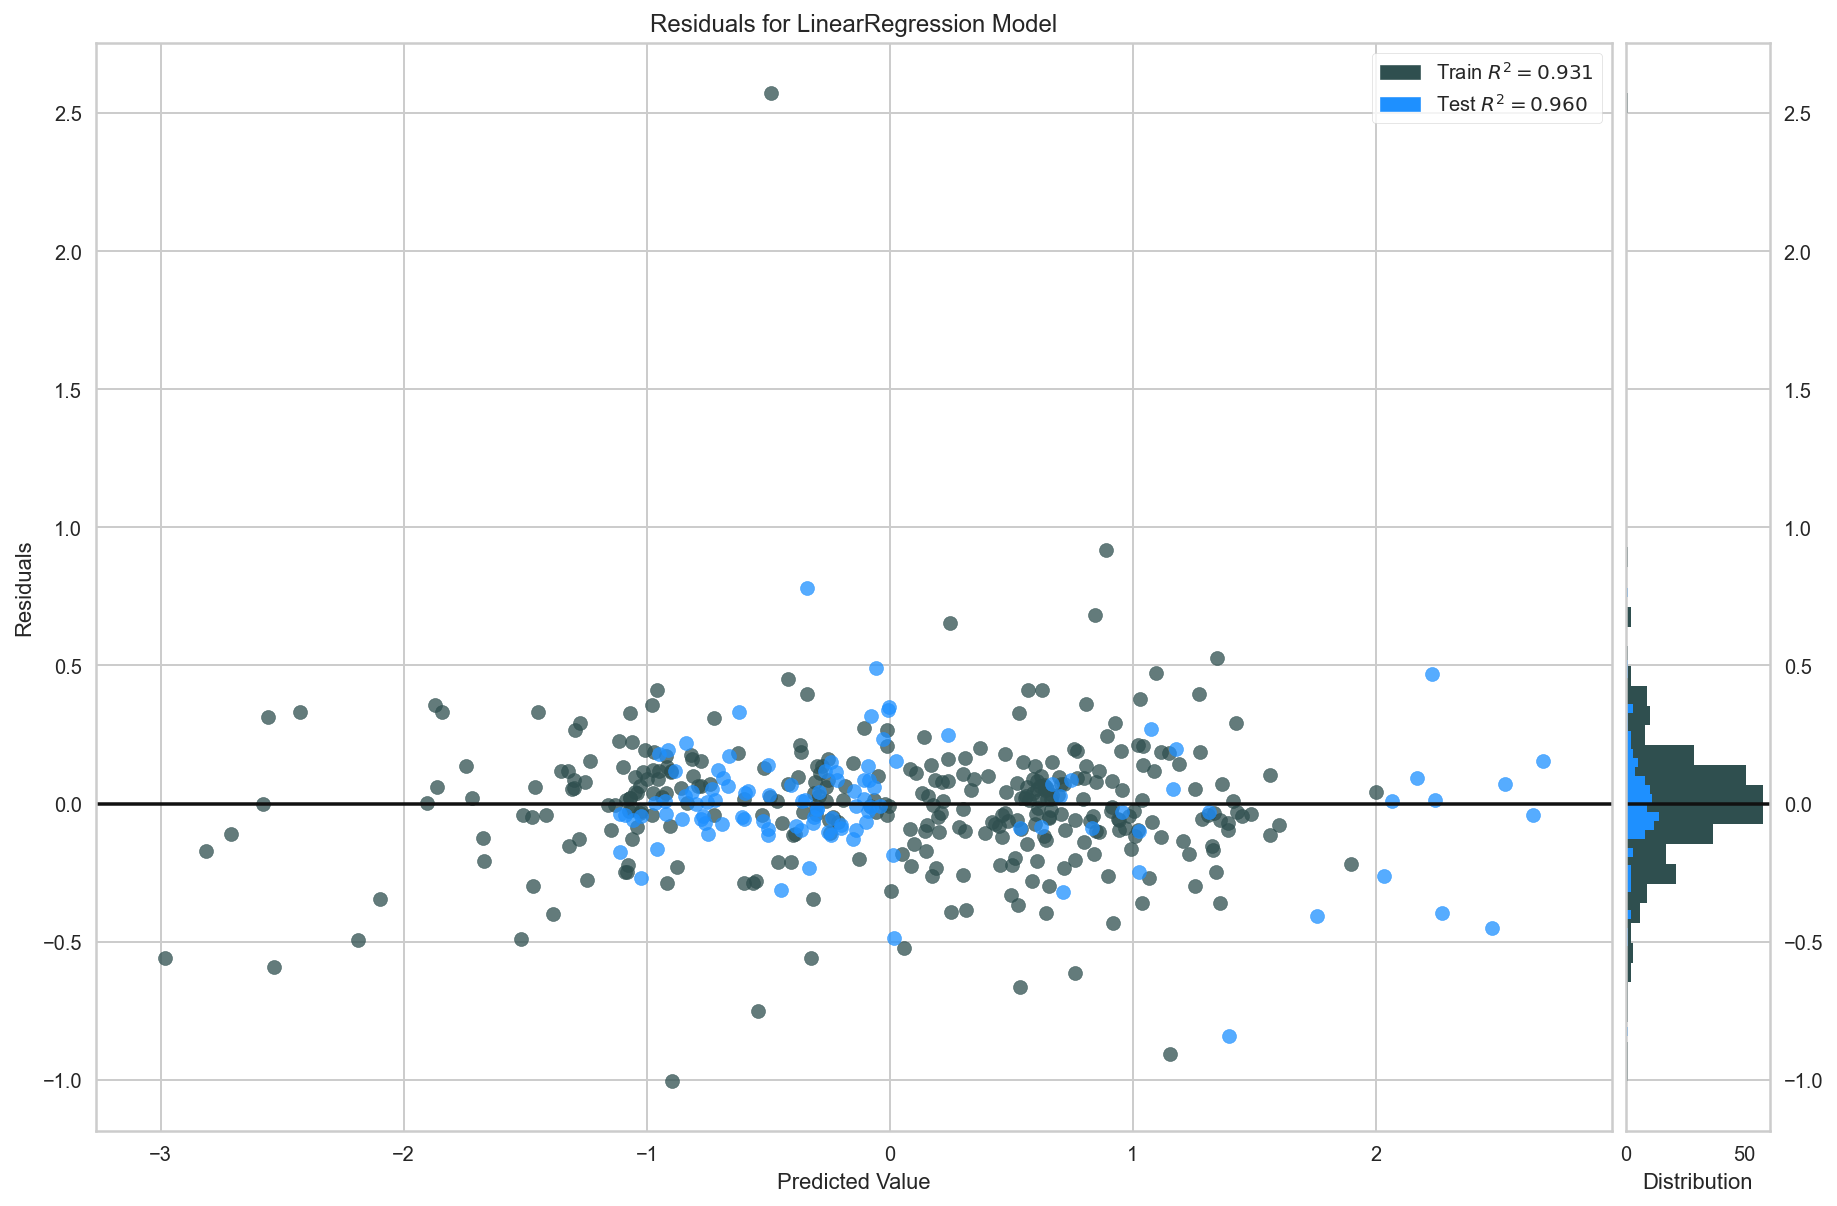

In [117]:
# Yellow brick visualizer

viz = residuals_plot(models['OLS'],
                     X_train,
                     y_train,
                     X_test,
                     y_test,
                     train_color='darkslategrey',
                     test_color='dodgerblue', size=(1080, 720))

#### Coefficients

Here we acquire the coefficients from models train sets, that of which will be used to influence the amount of impact one individual feature has. 

As a rule of thumb, if abs(b) < 0.15 it is quite safe to say that when b = 0.1 we will observe a 10% increase in y for a unit change in x. That being said, if we are interpreting the coefficients based on that general rule we can then see that since the absolute value of our coefficient for the feature "close" is 0.941221, then there is more than a 90% increase in y for a unit change in x. A 90% increase in y is fairly large, especially when considering none of the other features in the model influence y even 10% or 0.1. 

In [40]:
ols_coef = models['OLS'].fit(X_train, y_train).named_steps['fit'] # Get coefficients
ols_coef_dict = dict(zip(model_features, ols_coef.coef_)) # Creat dictionary of coefficients

In [41]:
# Organize dict into dataframe

ols_coef_df = pd.DataFrame.from_dict(ols_coef_dict,
                                     orient='index',
                                     columns=[
                                         'close', 'volume', 'ema_short',
                                         'ema_long', 'atr', 'obv',
                                         'tweet_sentiment'
                                     ])

ols_coef_df = ols_coef_df.T
ols_coef_df.columns = ['coef']
ols_coef_df = abs(ols_coef_df['coef']).sort_values(
    ascending=False
)  # Get absolute value for coefficients and sort highest to low
ols_coef_df = pd.DataFrame(ols_coef_df)

In [42]:
ols_coef_df

coef
close            0.941221
ema_long         0.033662
ema_short        0.029302
obv              0.026796
atr              0.011850
tweet_sentiment  0.010993
volume           0.006039

#### LIME Explanation

LIME explains models by learning them locally around their predictions. This provides us with the information necessary to take practical steps in the real world, instead of blindly accepting what the model is outputting via "accuracy". LIME uses "perturbed" observations generated and compare model prediction results against the non "perturbed" observations determining how much weight one individual feature has in the entire model.

![image.png](https://www.oreilly.com/content/wp-content/uploads/sites/2/2019/06/figure2-802e0856e423b6bf8862843102243a8b.jpg)
<br>
##### Sparse Linear LIME Explanation Equation:

![lime_equation](https://miro.medium.com/max/656/1*iYYzuEPgz3HltoMjyzViUg.png)

Intercept -0.4195289308332859
Prediction_local [1.08611973]
Right: 2.229590921127222


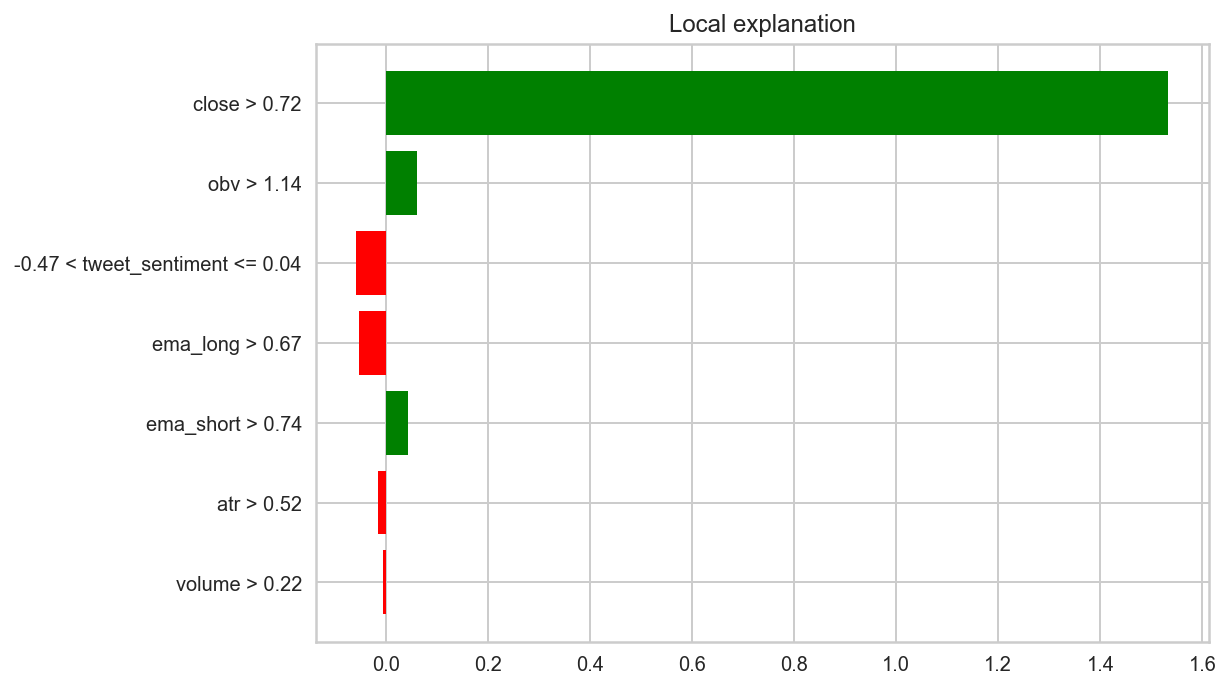

In [43]:
# Lime interpretation for 100 samples (i) from test set predictions

i = 100

ols_exp = explainer.explain_instance(X_test[i], models['OLS'].predict, num_features=7)
lime_ols = ols_exp.as_pyplot_figure() # Plot

In [178]:
# ols_exp.show_in_notebook(show_all=True)

![lime_ols_exp.png](https://i.gyazo.com/17b5a355709ca41bf61d02e22088c06d.png)

### LASSO

#### Residual Plot

The Lasso model performed nearly the same as the OLS in regards to its prediction errors. The only difference is a visual change in distribution, where the predicted values of the Lasso seem to be more "compact" or "normal" than the OLS. Other than that the R2 score remained the same.

In [119]:
y_train = y_train.flatten()
y_test = y_test.flatten()

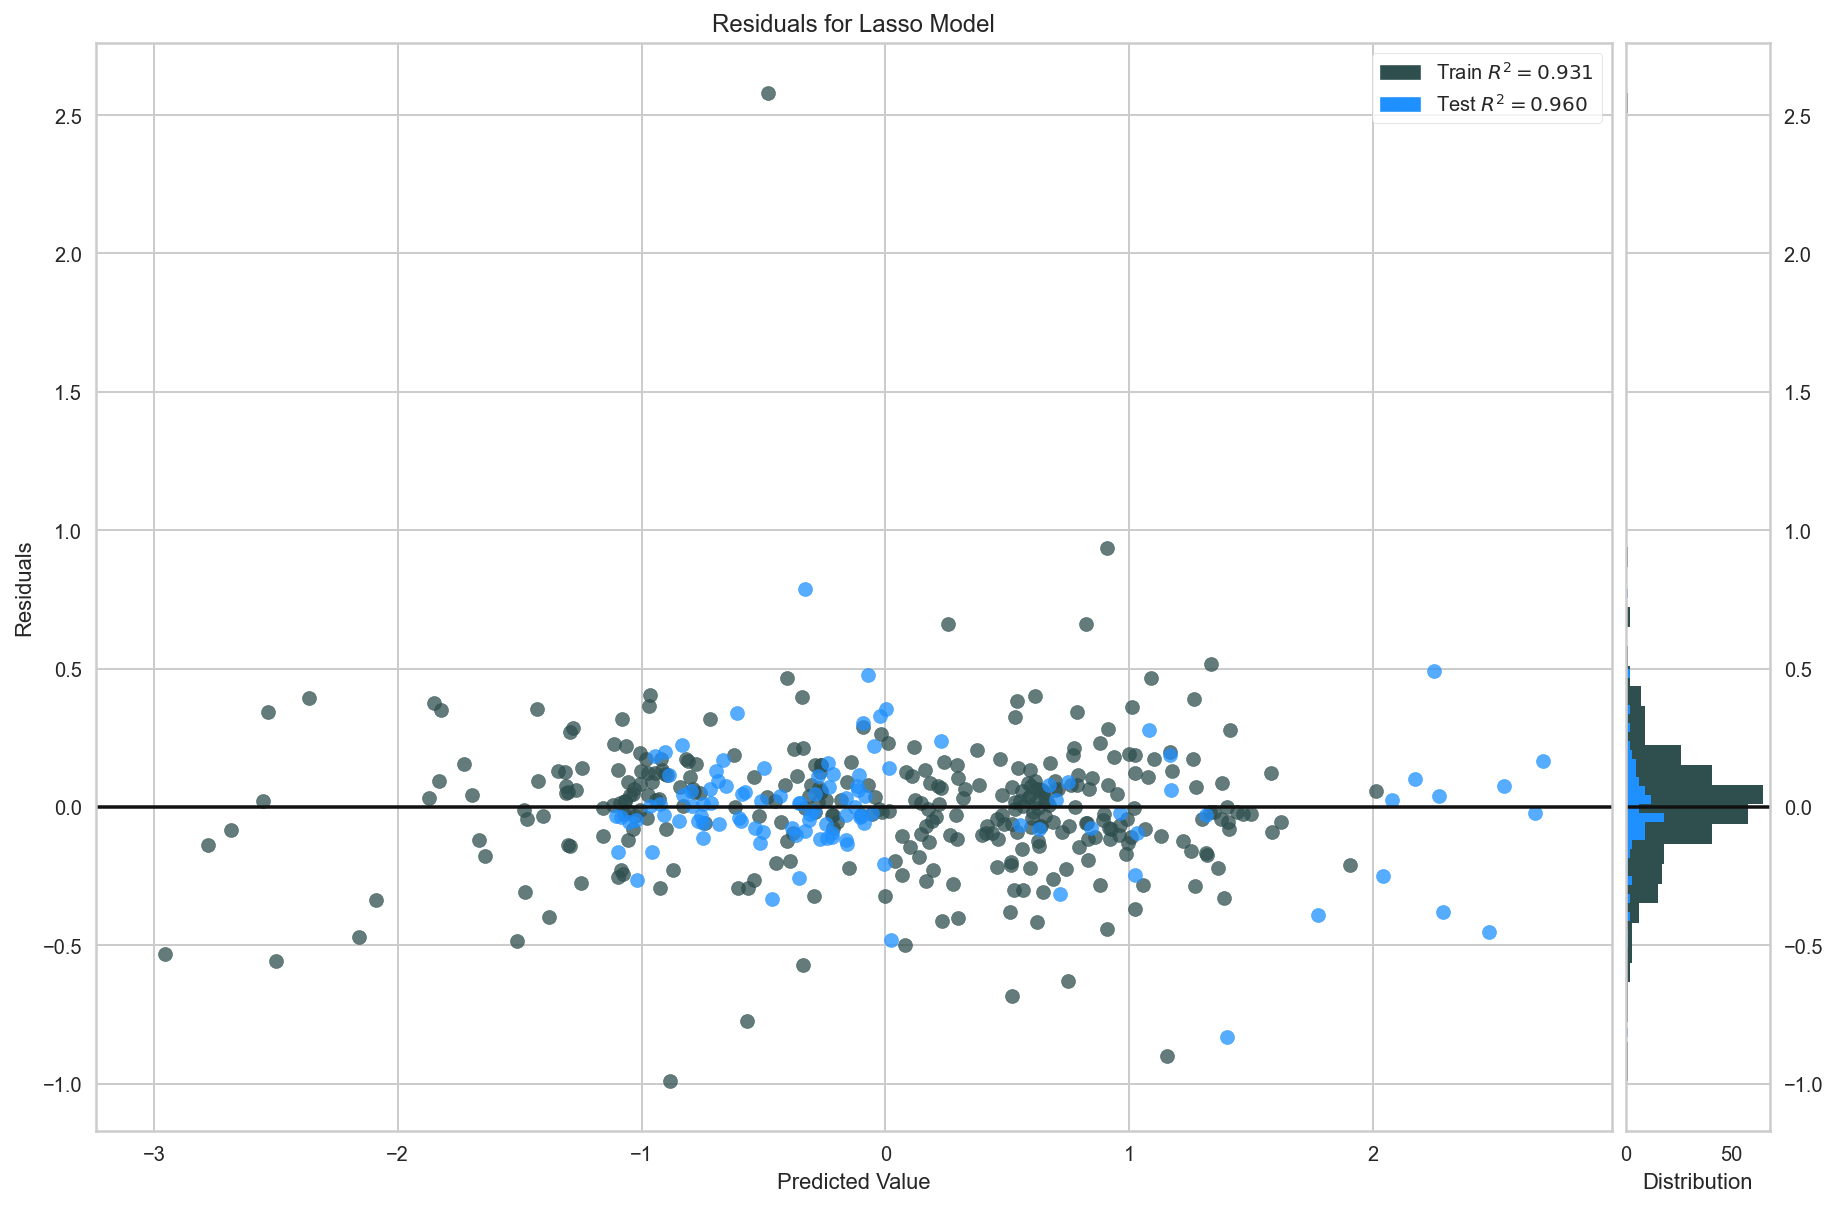

In [120]:
viz2 = residuals_plot(models['Lasso'],
                      X_train,
                      y_train,
                      X_test,
                      y_test,
                      train_color='darkslategrey',
                      test_color='dodgerblue', size=(1080, 720))

#### Coefficients

Once again, Lassos coefficients did not differ much when compared to OLS. However, the Lasso model did seem to have a larger coefficient value for "close" and the rest of the features were weighted less in comparison. "obv" was the second greatest impact overall which is interesting as it did not have as much linearity or correlation compared to "ema_long" and "ema_short".

In [105]:
lasso_coef = models['Lasso'].fit(X_train, y_train).named_steps['fit']
lasso_coef_dict = dict(zip(model_features, lasso_coef.coef_))

In [109]:
lasso_coef_df = pd.DataFrame.from_dict(lasso_coef_dict,
                                     orient='index',
                                     columns=[
                                         'close'
                                     ])

#lasso_coef_df = lasso_coef_df.T
lasso_coef_df.columns = ['coef']
lasso_coef_df = abs(lasso_coef_df['coef']).sort_values(ascending=False)
lasso_coef_df = pd.DataFrame(lasso_coef_df)

In [110]:
lasso_coef_df

coef
close            0.944519
obv              0.025010
atr              0.012223
tweet_sentiment  0.007263
ema_long         0.001802
volume           0.000000
ema_short        0.000000

#### LIME Explanation



Intercept -0.40849542360917235
Prediction_local [1.17807098]
Right: 2.250591045011263


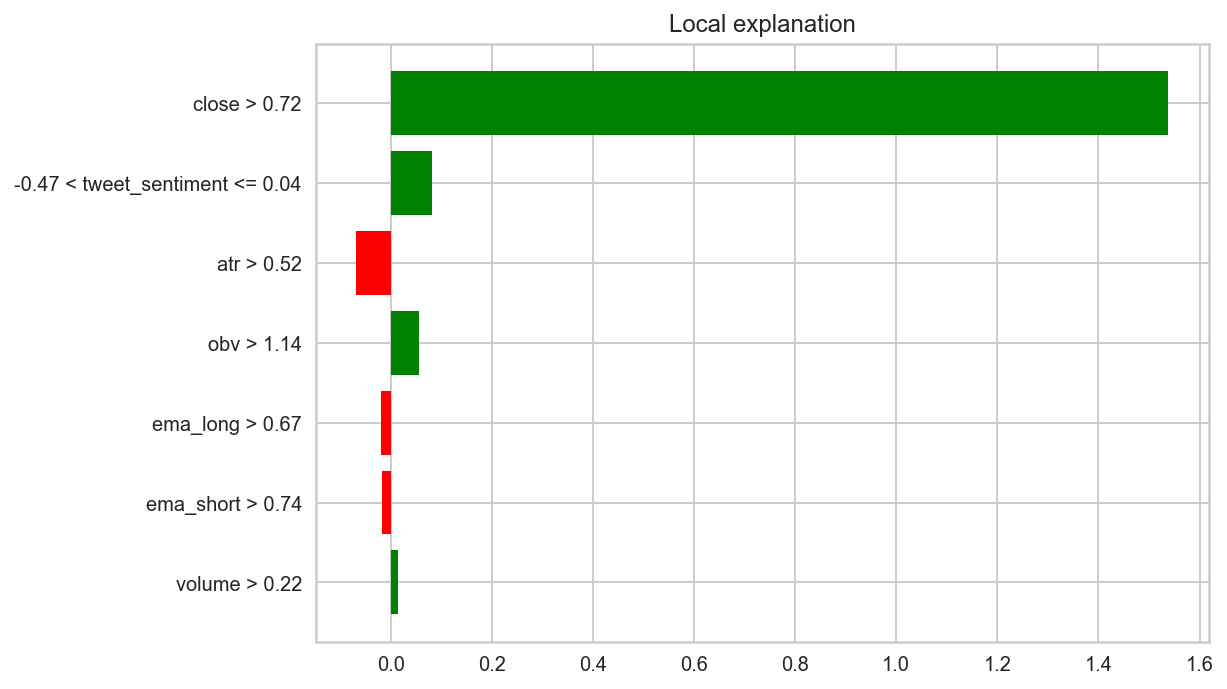

In [87]:
# Lime interpretation for 100 samples (i) from test set predictions

i = 100

lasso_exp = explainer.explain_instance(X_test[i], models['Lasso'].predict, num_features=7)
lime_lasso = lasso_exp.as_pyplot_figure()

In [181]:
# lasso_exp.show_in_notebook(show_all=True)

![lime_lasso_exp.png](https://i.gyazo.com/8e34f67a9694ffcb23c1fba21d039e5e.png)

### RIDGE

#### Residual Plot

As you can see below, the Ridge model performed significantly worse with a train R2 score of 0.724 and a test R2 score of 0.723. It shows us that the errors of predictions were sporadic and that was expected considering how poorly the model performed against true price values. We can also see that the test errors actually decreased meaning the model failed to minimize errors during training.

In [93]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

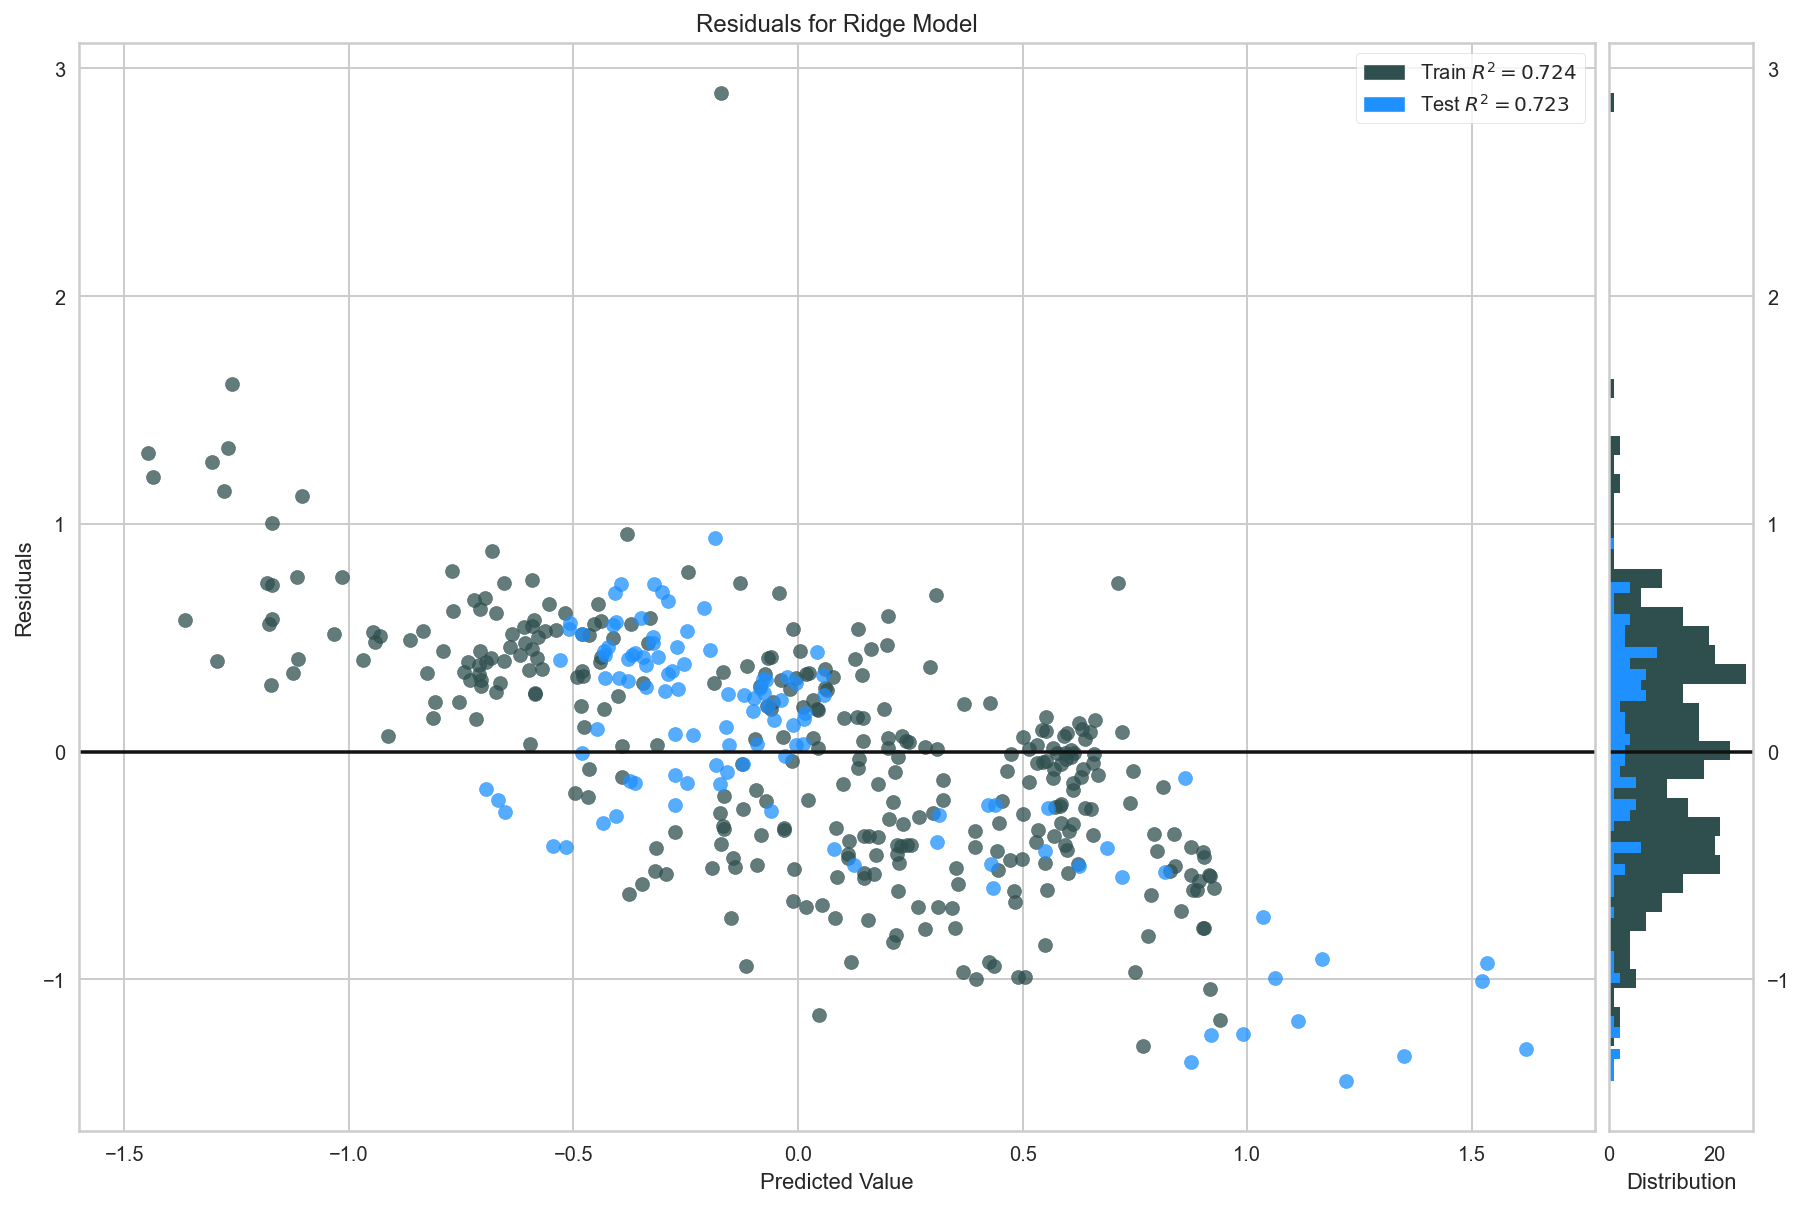

In [115]:
viz3 = residuals_plot(models['Ridge'],
                      X_train,
                      y_train,
                      X_test,
                      y_test,
                      train_color='darkslategrey',
                      test_color='dodgerblue', size=(1080, 720))


#### Coefficients

The Ridge models coefficients were interesting. "close" was of course the most densely weighted feature, however, the "ema_short" values increased. Following "ema_short" was "obv", which makes sense when refering back to the EDA performed previously. In the EDA we discovered that "obv" has multicollinearity with "ema_short", two seemingly unrelated variables.

In [44]:
ridge_coef = models['Ridge'].fit(X_train, y_train).named_steps['fit']
ridge_coef_dict = dict(zip(model_features, ridge_coef.coef_))

In [47]:
ridge_coef_df = pd.DataFrame.from_dict(ridge_coef_dict,
                                     orient='index',
                                     columns=[
                                         'close', 'volume', 'ema_short',
                                         'ema_long', 'atr', 'obv',
                                         'tweet_sentiment'
                                     ])

ridge_coef_df = ridge_coef_df.T
ridge_coef_df.columns = ['coef']
ridge_coef_df = abs(ridge_coef_df['coef']).sort_values(ascending=False)
ridge_coef_df = pd.DataFrame(ridge_coef_df)

In [48]:
ridge_coef_df

coef
close            0.252273
ema_short        0.169099
obv              0.099967
ema_long         0.092182
atr              0.061788
volume           0.054098
tweet_sentiment  0.036589

#### LIME Explanation

The LIME explainer below shows us and confirms our findings during coefficient calculations. It tells us that the 100th test values prediction is 1.03 out of 1.07 with the "close" value providing the most positive valuation. The most negative valuation value is "volume" and "atr".

Intercept -0.2175222936049169
Prediction_local [0.58741746]
Right: 1.0342044654313491


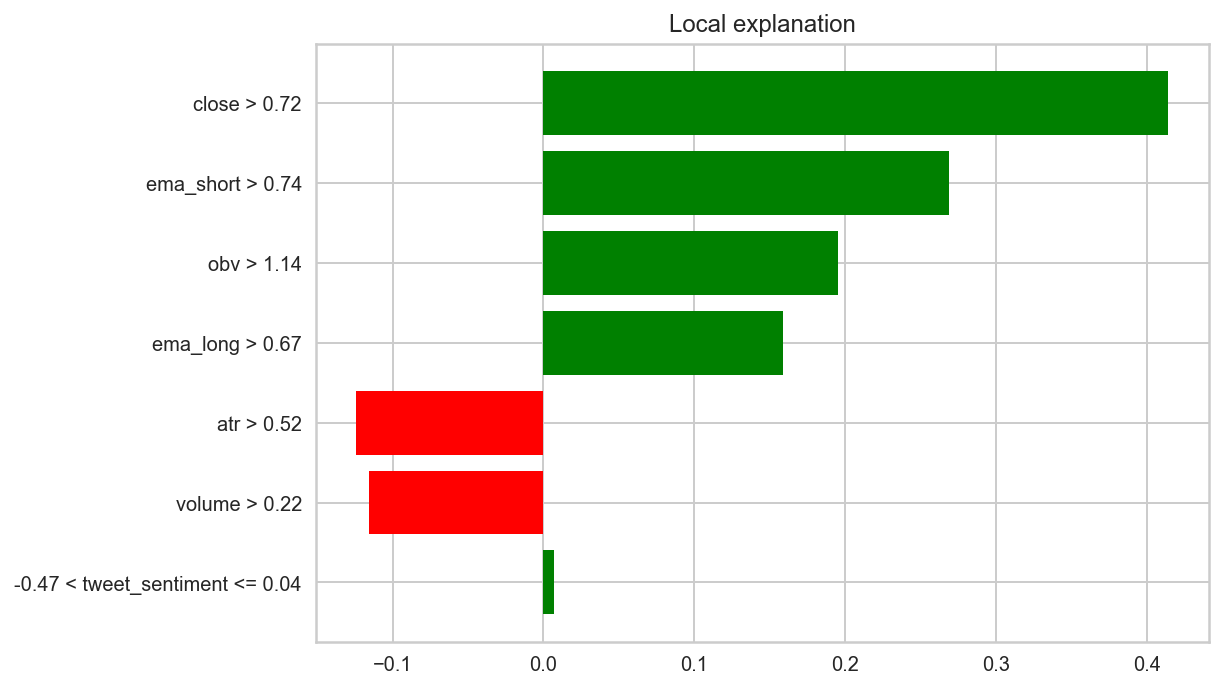

In [84]:
# Lime interpretation for 100 samples (i) from test set predictions

i = 100

ridge_exp = explainer.explain_instance(X_test[i], models['Ridge'].predict, num_features=7)
lime_ridge = ridge_exp.as_pyplot_figure()

In [185]:
# ridge_exp.show_in_notebook(show_table=True, show_all=True)

![lime_ridge_exp.png](https://i.gyazo.com/c279a33a0bf8c0d79025cd9a0bbef2f8.png)

### RFR

#### Residual Plot

For the Random Forest Regression model we can see that the distribution of errors from predictions are rather spread out or wide. You can also see that the errors of the test predictions are almost vertical past a predictive value > 1.5. Also, as predictive value increases the residuals become more negative but the train distribution remained fairly "normal".

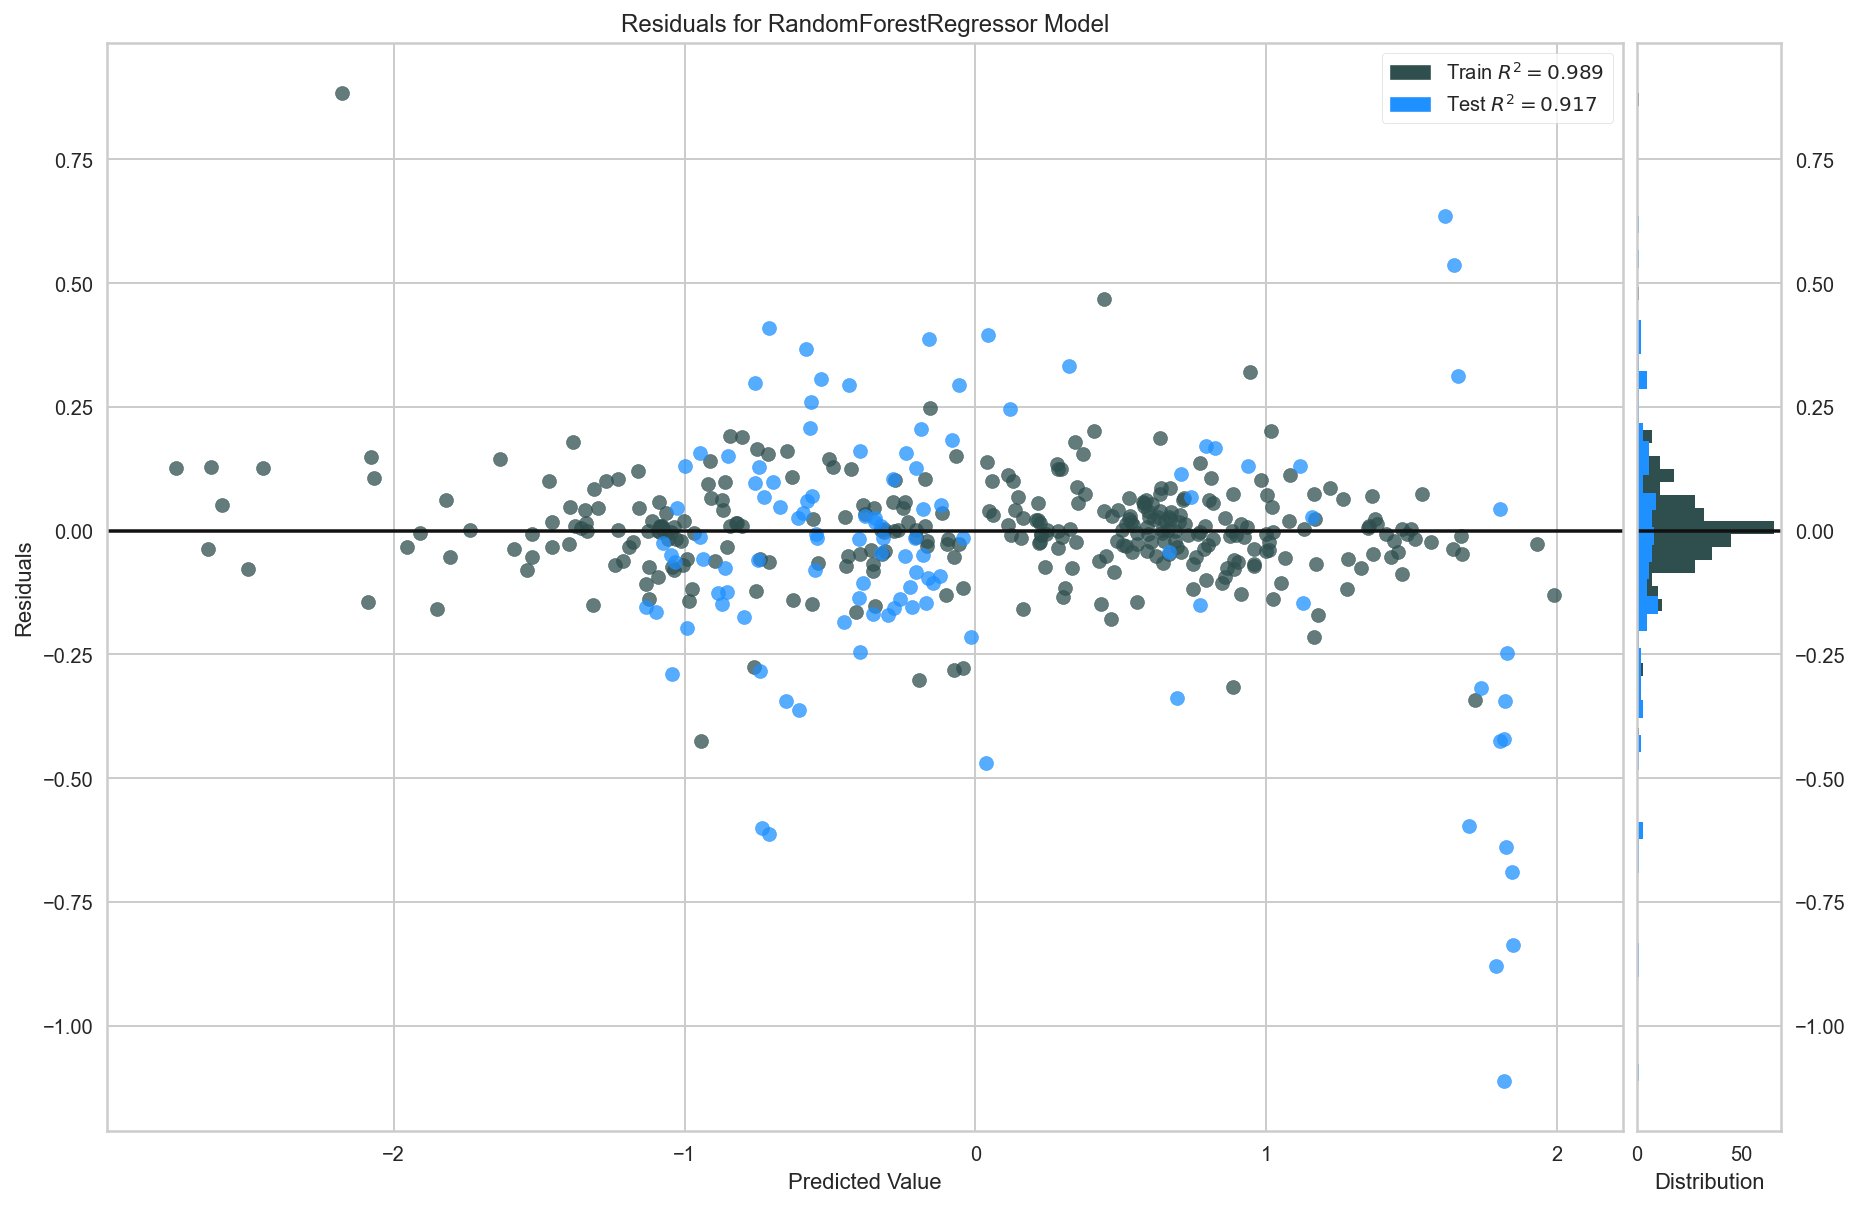

In [121]:
viz4 = residuals_plot(models['RFR'],
                      X_train,
                      y_train,
                      X_test,
                      y_test,
                      train_color='darkslategrey',
                      test_color='dodgerblue', size=(1080, 720))

#### Feature Importance

This segment, specific to random forest models, provides us with an output containing a list of our features ranked highest to lowest by importance in regards to the models predictions. 

Below you will see that "close" continues to hold the most weight of impact across the board with all models, receiving a value of 0.9217 for its importance. On the other hand, we can see that the RFR found use of the "atr" which is unique to this specific model. It might be implied that an RFR using only features related to price and volatility could be rather accurate... as our RFR found the most use out of features with those properties.

In [112]:
feature_importances = pd.DataFrame(models['RFR'].feature_importances_,
                                   index=X.columns,
                                   columns=['Importance'
                                            ]).sort_values('Importance',
                                                           ascending=False)

In [113]:
feature_importances

Importance
close              0.921762
atr                0.029122
ema_long           0.014281
obv                0.012575
volume             0.010872
ema_short          0.009562
tweet_sentiment    0.001826

#### LIME Explanation

The RFRs LIME explanation differs greatly from its feature importance. Interestingly, two of the highest rated features for importance ("atr" and "ema_long") actually ranked negative by a substantial amount by LIME. The 100th test values prediction is 1.80 out of 1.80 with the "close" value providing the most positive valuation. The most negative valuation value is "volume".

Intercept -0.3824109953717575
Prediction_local [1.01261926]
Right: 1.8038129841400214


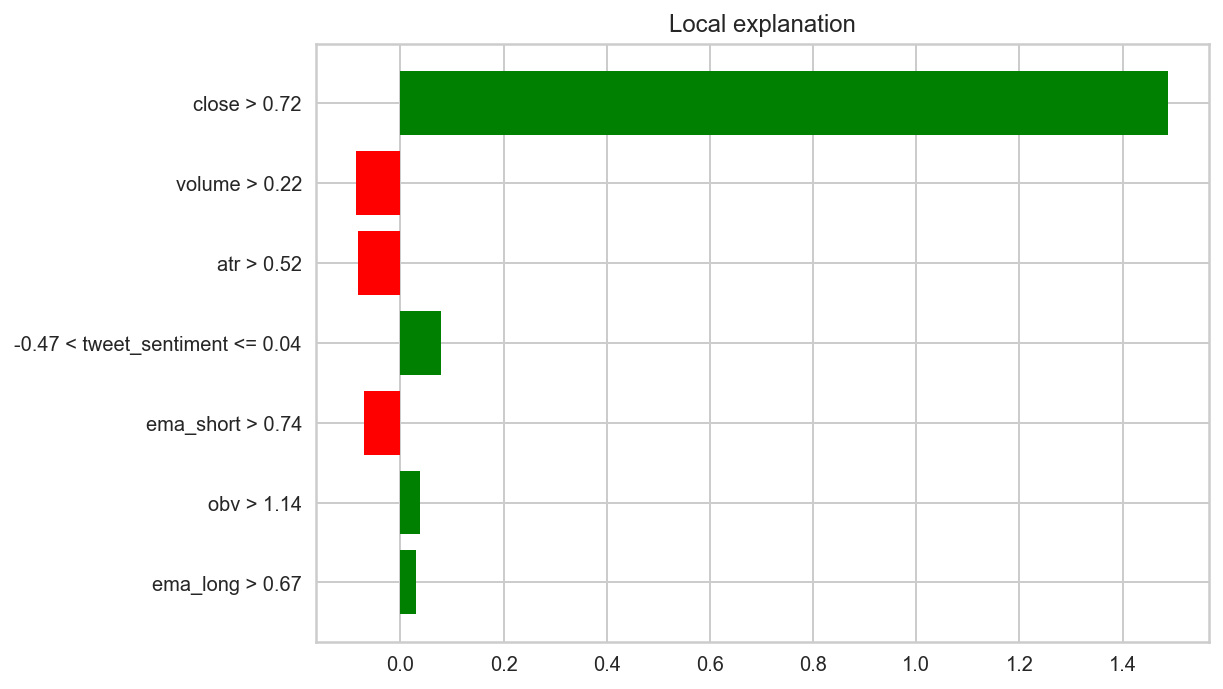

In [111]:
# Lime interpretation for 100 samples (i) from test set predictions

i = 100

rfr_exp = explainer.explain_instance(X_test[i], models['RFR'].predict, num_features=7)
lime_rfr = rfr_exp.as_pyplot_figure()

In [187]:
# rfr_exp.show_in_notebook(show_all=True)

![lime_rfr_exp.png](https://i.gyazo.com/65cf0d71335fd5737f6e2e5a34d21d79.png)

## Long Short Term Memory (LSTM)

To run the model, I use the Hyperas wrapper of Keras based on Hyperopt. 

- **Process:**
    - Normalization using _MinMaxScaler()_
    - Add "predictor", time steps of "9" from original Y target, "close_nexday"
    - Train, test split - 80% train (352 values) and 20% split (80 values)
    - Create LSTM model
    - Optimize through "Hyperas" 
    - Return output of best performing model from given parameters
<br>   
- **Sequential model layers:**
    - LSTM (choice: 10, 20, 30, 40, 50, 60, 70, 80)
    - Activation (choice: relu, sigmoid, linear, softmax)
    - Dropout (choice: range of 0 to 1)
    - Dense (choice: 1)
<br>
- **Fitting params:**
    - Epochs (choice: 15, 25, 35, 45, 55, 65, 75)
    - Batch size (choice: 2, 4, 5, 8, 10, 16, 20, 40, 80)
    - Validation (X_test, y_test)
    - Callbacks (monitors "val_loss")
    - Suffle = False
<br>
- **Loss metrics:**
    - MSE (mean squared error) 
    - MAE (mean absolute error)
<br>
- **Optimizer:**
    - Choice (adamax, rmsprop, adam, sgd, nadam)
    
Through Hyperas the functions will run through all the possible layers and choices available to select the best possible combination of those parameters and output the best performing model. Because the loss used is MSE/MAE and not an accuracy metric, Hyperas will optimize the models to lower the MSE for each epoch over time. Using the history recorded from model fitting we are able to visualize the optimization process by plotting the training loss against the validation loss. 

You will also find a line plot at the bottom that shows the performance of the best models price predictions against the actual testing values ("close").


>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.model_selection import TimeSeriesSplit
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from sklearn.pipeline import Pipeline
except:
    pass

try:
    from sklearn.preprocessing import PolynomialFeatures
except:
    pass

try:
    from sklearn.linear_model import LinearRegression
except:
    pass

try:
    from sklearn.ensemble import RandomForestRegressor
except:
    pass

try:
    from sklearn import linear_model, preprocessing
except:
    pass

try:
    from sklearn.metrics import accuracy_score
except:
    pass

try:
    from sklearn import metrics
except:
    pass

try:
    import statsmodels.api as sm
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import num

  49: 
                                                                                                                       
Epoch 00001: val_loss improved from inf to 1.09079, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 1.09079 to 0.76260, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.76260 to 0.53856, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004: val_loss improved from 0.53856 to 0.42672, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00005: val_loss improved fr

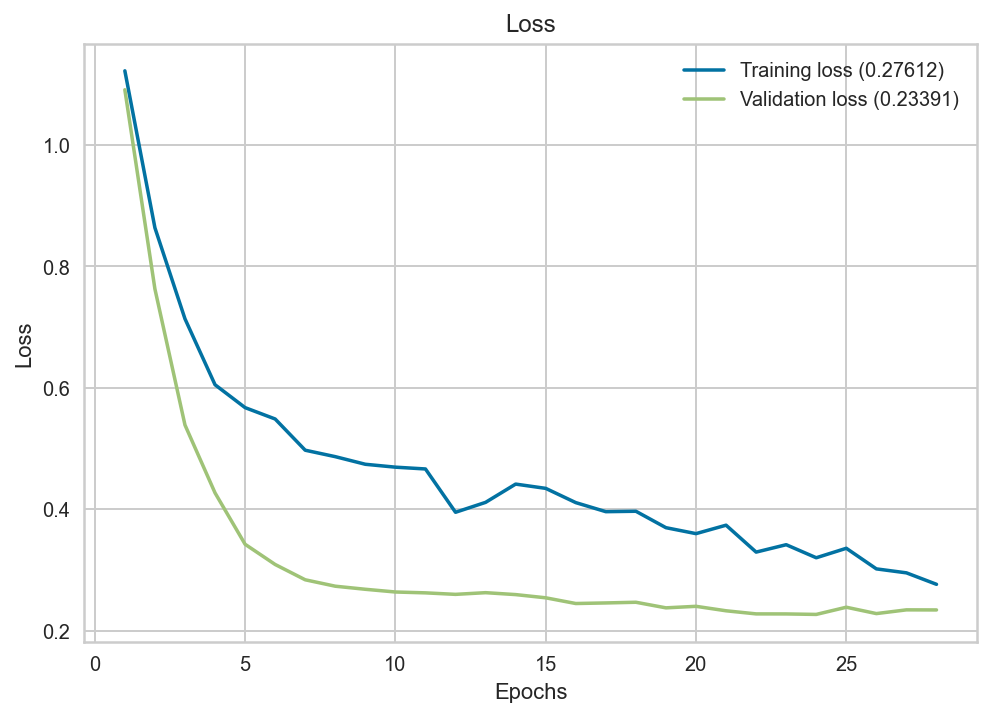

Test loss:                                                                                                             
0.31901413202285767                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.05656, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.05656 to 0.04289, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.04289 to 0.03340, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

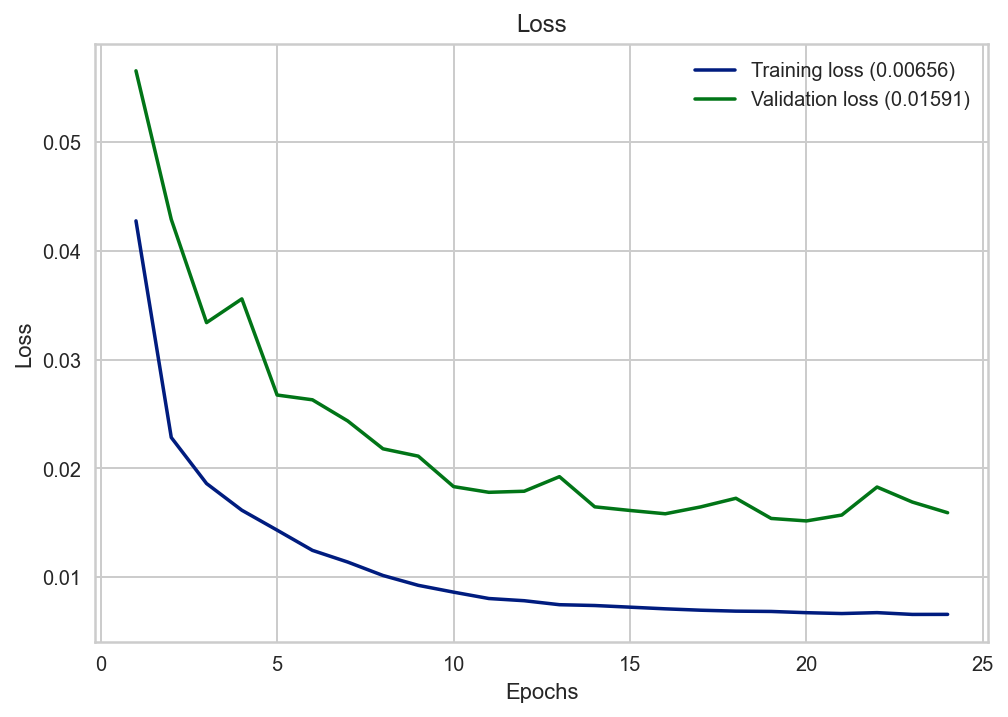

Test loss:                                                                                                             
0.055869970470666885                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.32404, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.32404 to 0.21353, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.21353 to 0.14580, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00039: val_loss did not improve from 0.02832
                                                                                                                       
Epoch 00040: val_loss improved from 0.02832 to 0.02695, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.02695 to 0.02662, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.02662 to 0.02587, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00043: val_loss did not improve from 0.02587
                                                                                                                       
Epoch 00044: val_loss imp

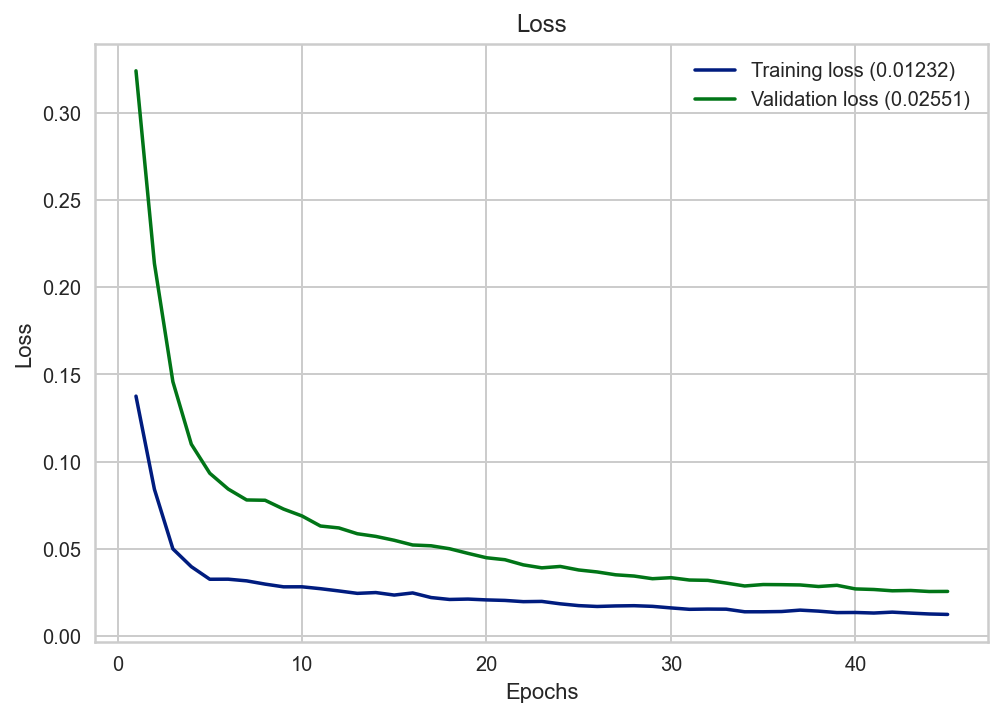

Test loss:                                                                                                             
0.10163982212543488                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.08892, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.08892 to 0.05762, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.05762 to 0.04226, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

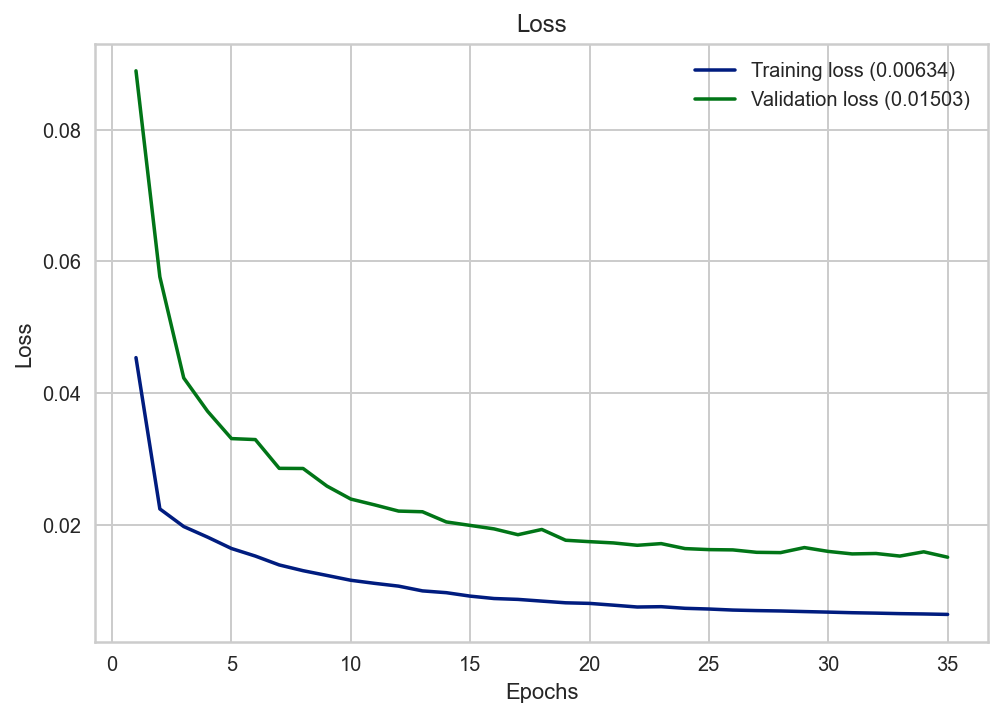

Test loss:                                                                                                             
0.03617897629737854                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.38652, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.38652 to 0.31870, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.31870 to 0.27007, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

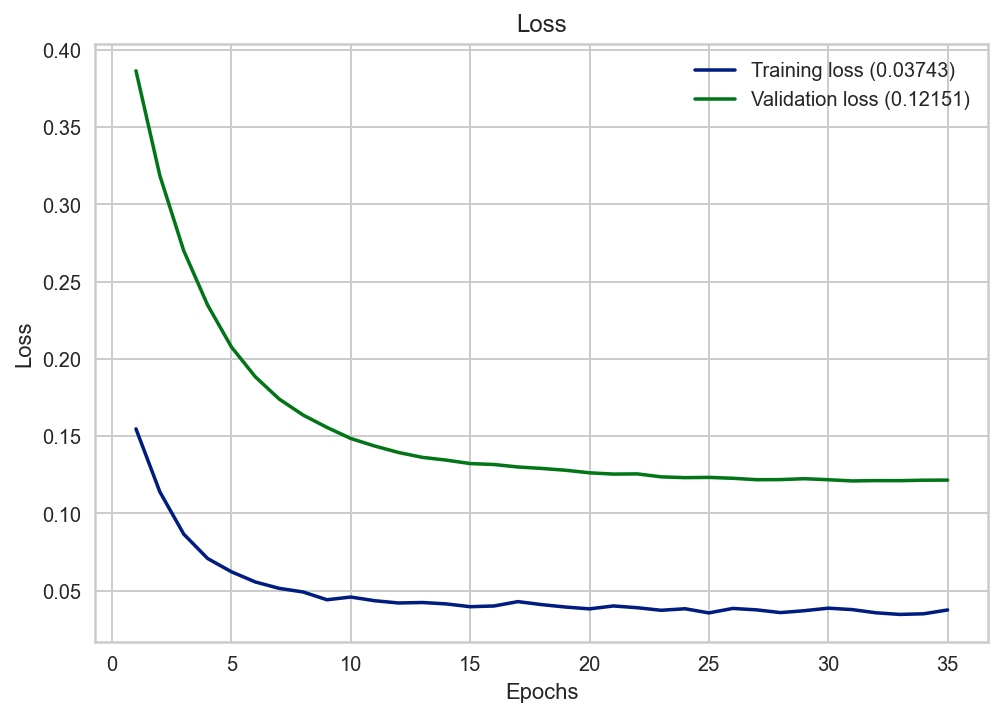

Test loss:                                                                                                             
0.322608083486557                                                                                                      
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.07305, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.07305 to 0.05331, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.05331 to 0.04409, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

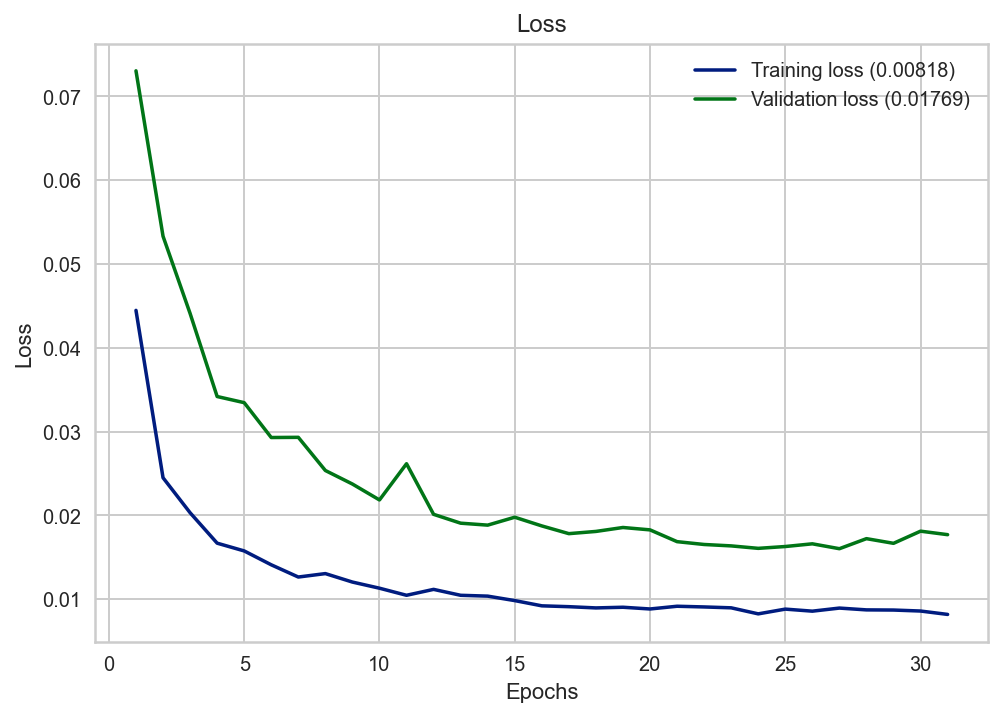

Test loss:                                                                                                             
0.06589538604021072                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.38041, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.38041 to 0.34818, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.34818 to 0.31961, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

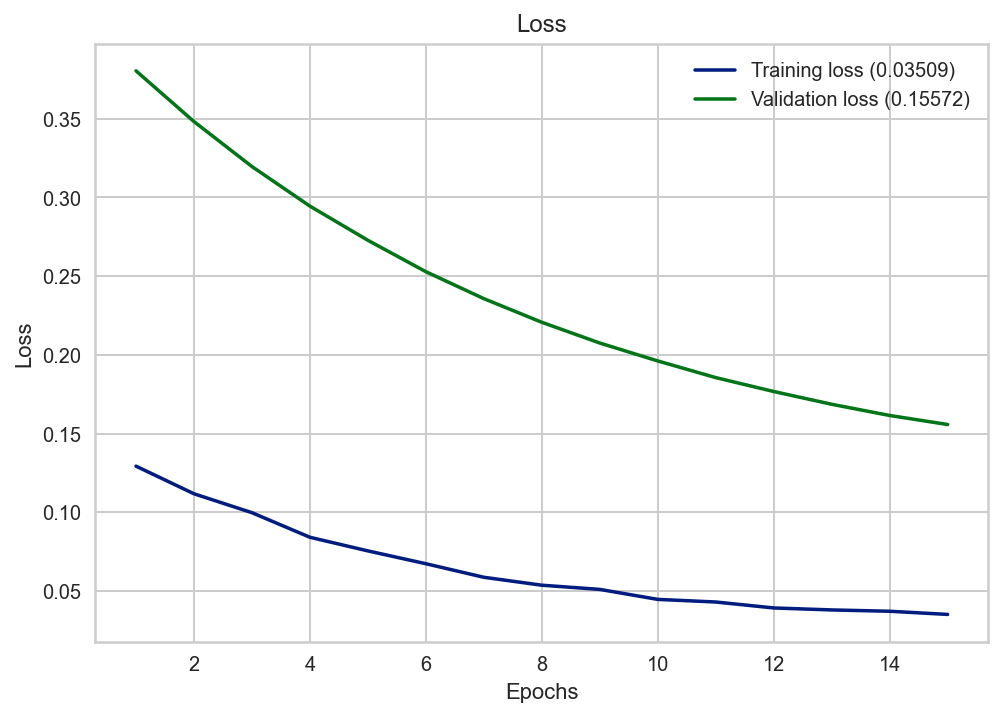

Test loss:                                                                                                             
0.3764799237251282                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.17258, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.17258 to 0.16832, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss did not improve from 0.16832
                                                                                                                       
Epoch 00004: val_loss did not improve from 0.16832


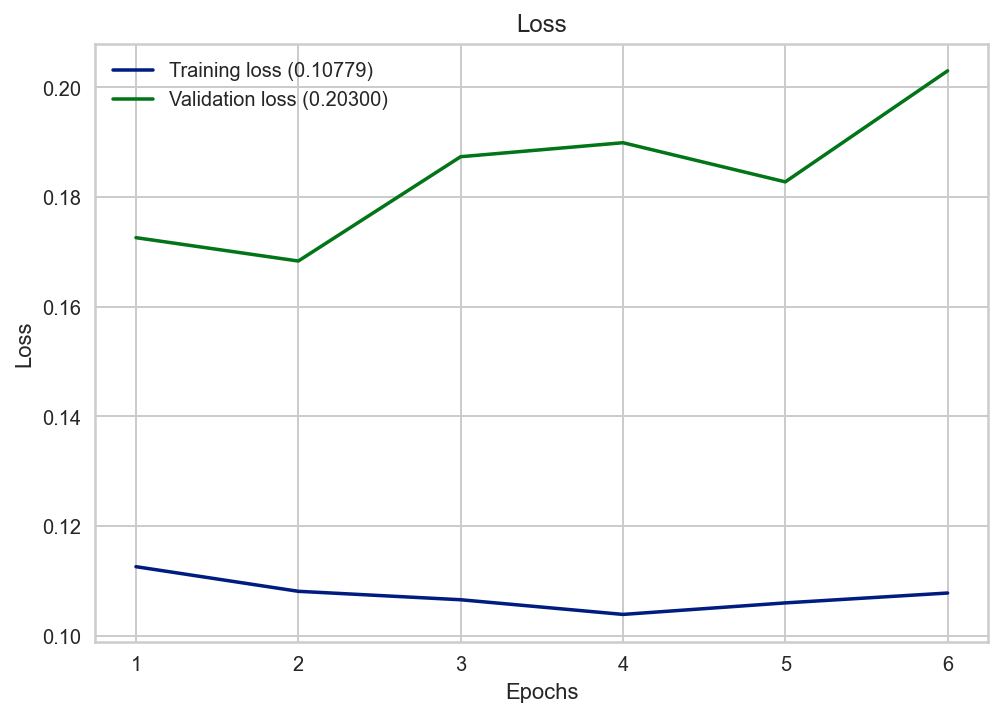

Test loss:                                                                                                             
0.3501133322715759                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.57385, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.57385 to 0.55097, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.55097 to 0.49374, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

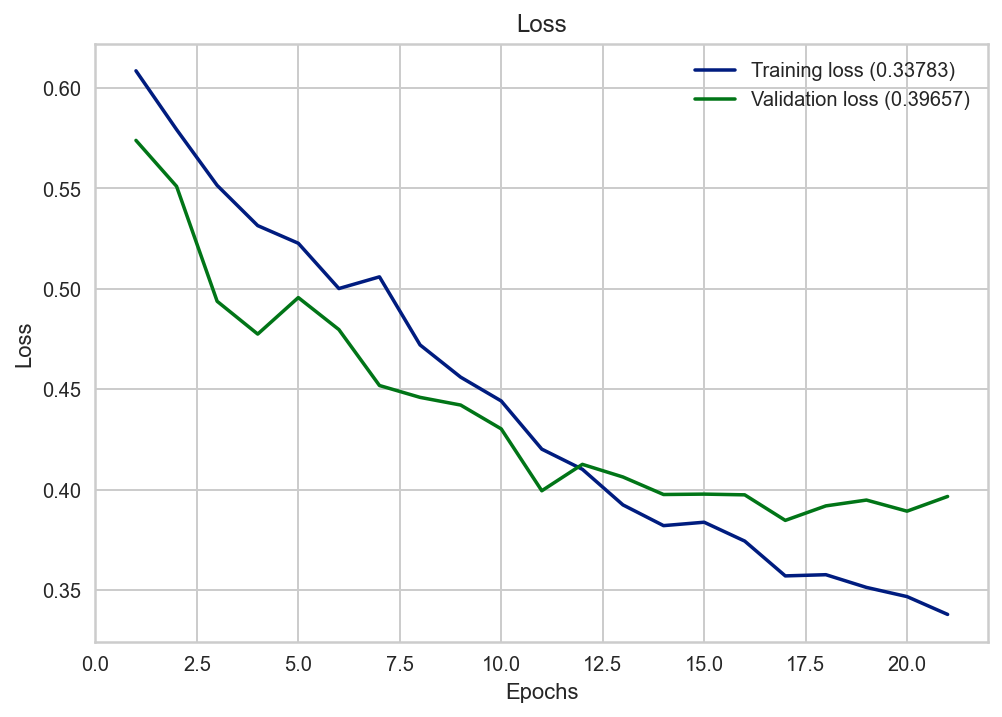

Test loss:                                                                                                             
0.34158608317375183                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.29490, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.29490 to 0.22218, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.22218 to 0.18220, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00038: val_loss improved from 0.10919 to 0.10869, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00039: val_loss improved from 0.10869 to 0.10825, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00040: val_loss improved from 0.10825 to 0.10768, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.10768 to 0.10716, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.10716 to 0.10681, saving model to keras_weights.hdf5
                                                                 

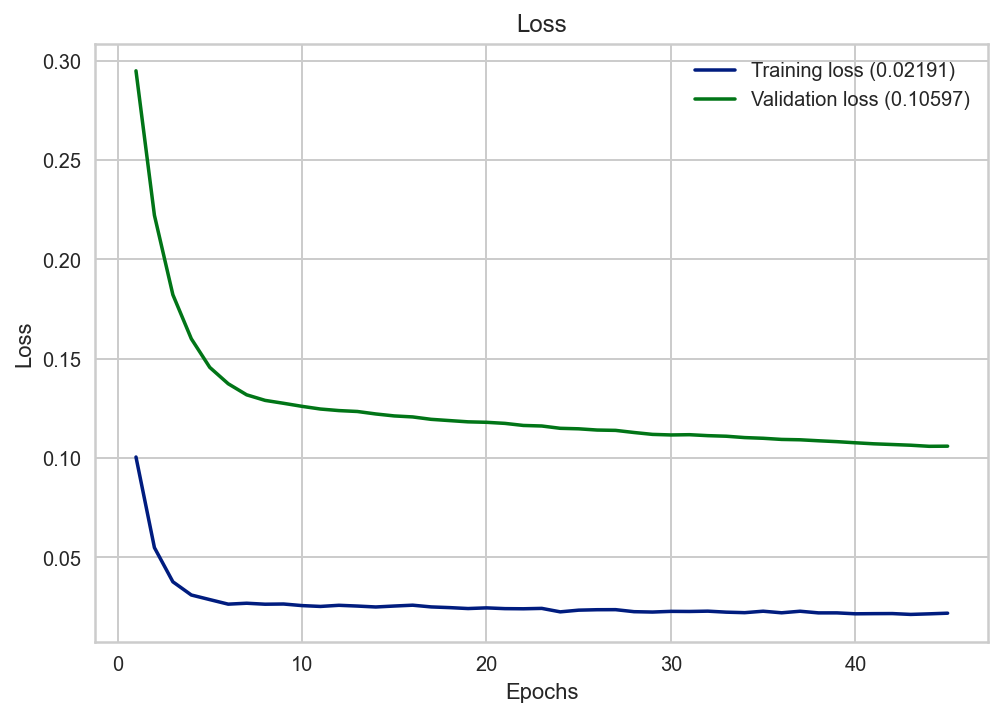

Test loss:                                                                                                             
0.3155471086502075                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.14593, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.14593 to 0.11522, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.11522 to 0.10707, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

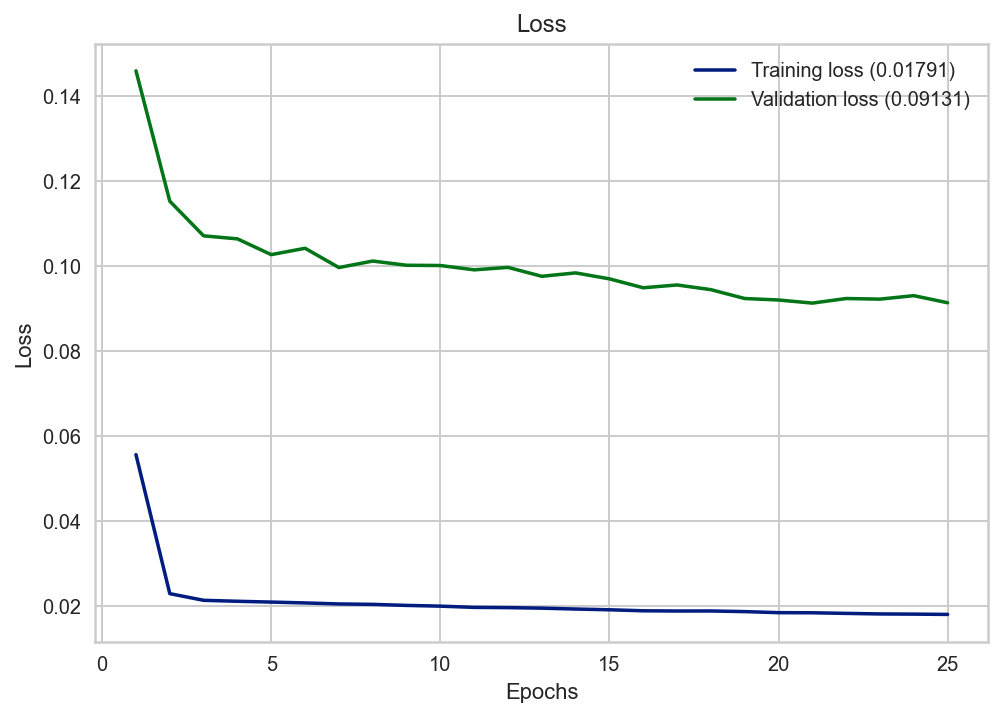

Test loss:                                                                                                             
0.28711840510368347                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.45765, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.45765 to 0.43427, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.43427 to 0.41233, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00038: val_loss improved from 0.13266 to 0.13063, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00039: val_loss improved from 0.13063 to 0.12883, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00040: val_loss improved from 0.12883 to 0.12720, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.12720 to 0.12574, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.12574 to 0.12435, saving model to keras_weights.hdf5
                                                                 

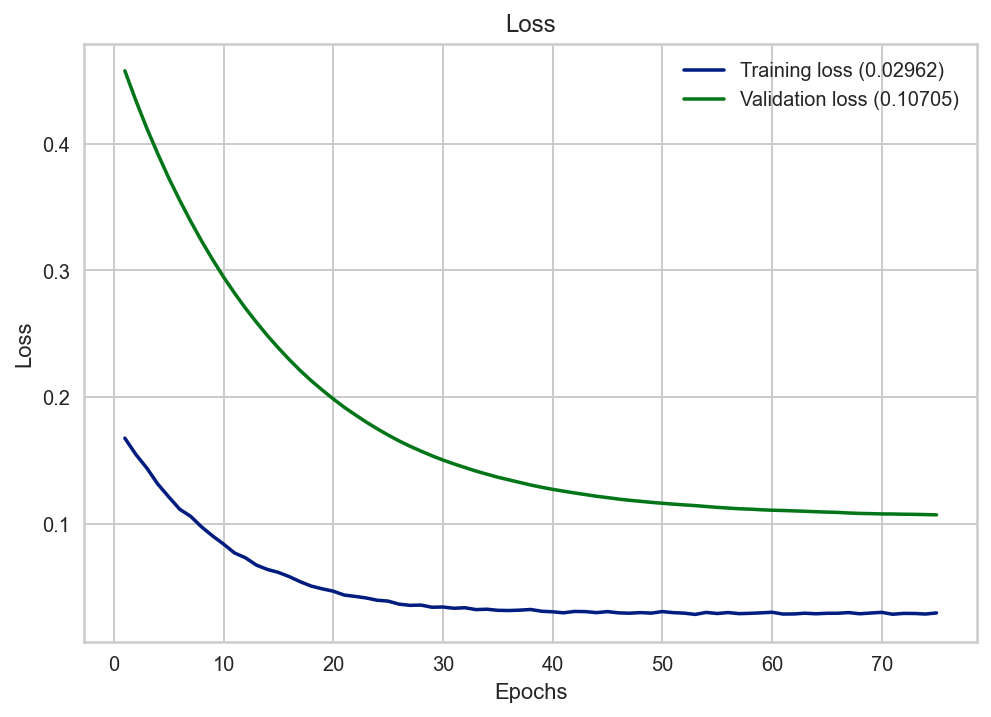

Test loss:                                                                                                             
0.30299636721611023                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.44238, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss did not improve from 0.44238
                                                                                                                       
Epoch 00003: val_loss did not improve from 0.44238
                                                                                                                       
Epoch 00004: val_loss did not improve from 0.44238
                                        

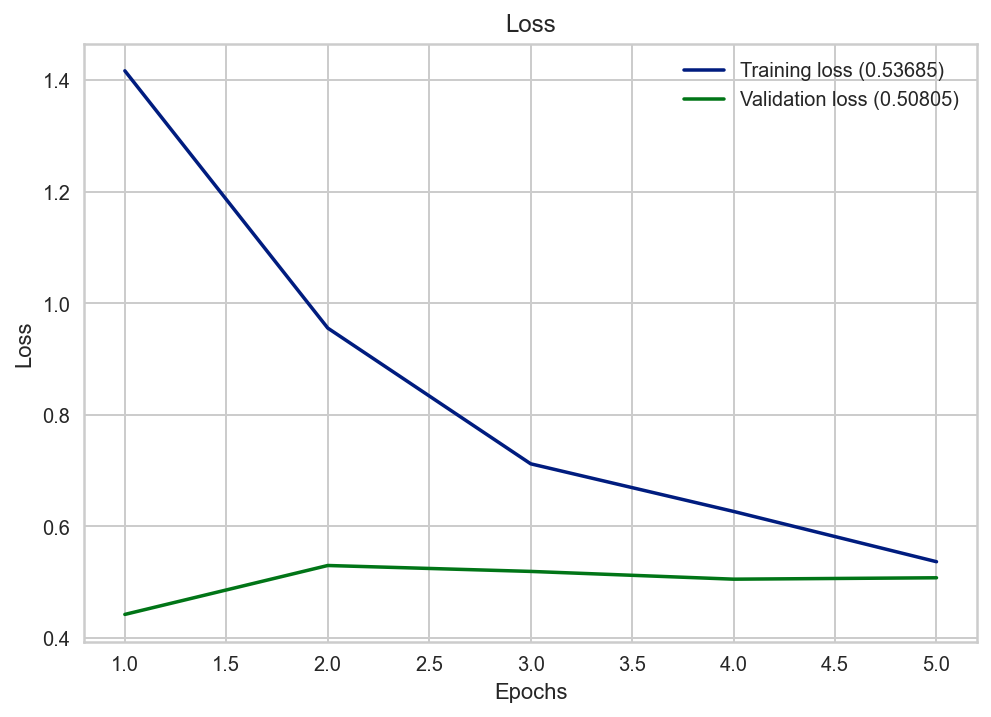

Test loss:                                                                                                             
0.36009183526039124                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.39744, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.39744 to 0.33272, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.33272 to 0.28178, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

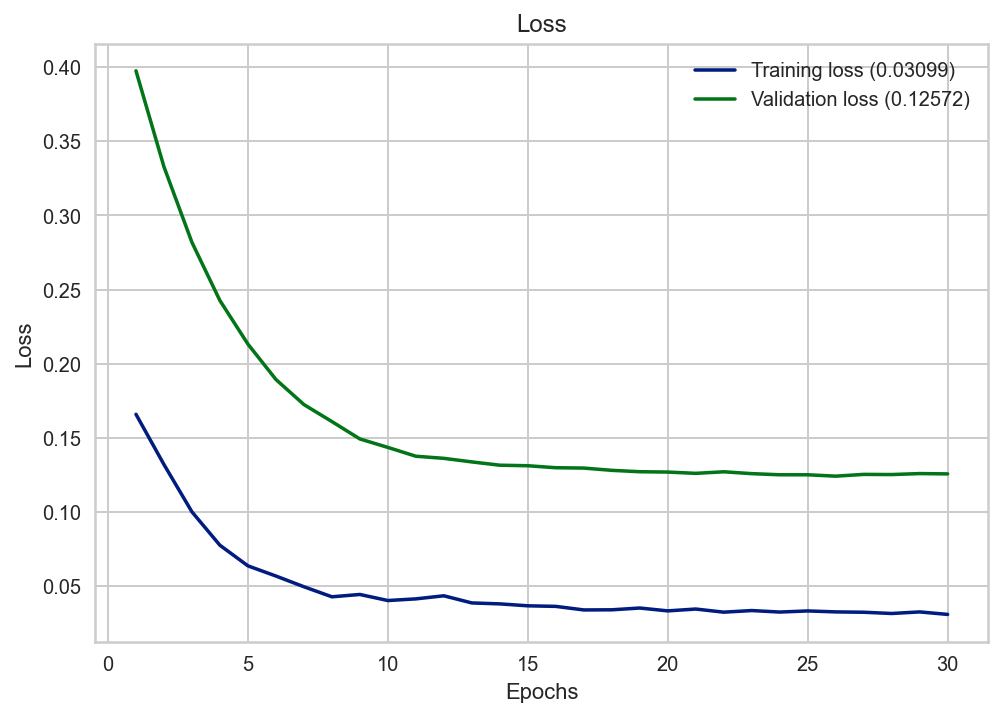

Test loss:                                                                                                             
0.3333732783794403                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.32906, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.32906 to 0.29061, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.29061 to 0.25833, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

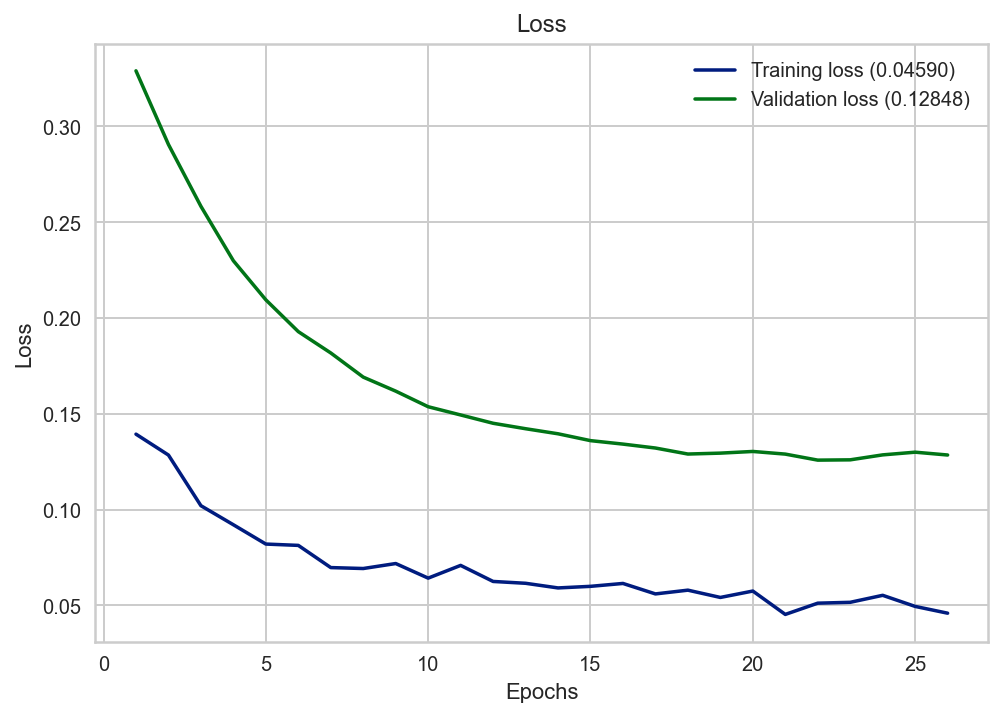

Test loss:                                                                                                             
0.33731040358543396                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.42375, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.42375 to 0.35854, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.35854 to 0.30524, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00038: val_loss improved from 0.08549 to 0.08486, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00039: val_loss improved from 0.08486 to 0.08404, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00040: val_loss improved from 0.08404 to 0.08341, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.08341 to 0.08276, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.08276 to 0.08224, saving model to keras_weights.hdf5
                                                                 

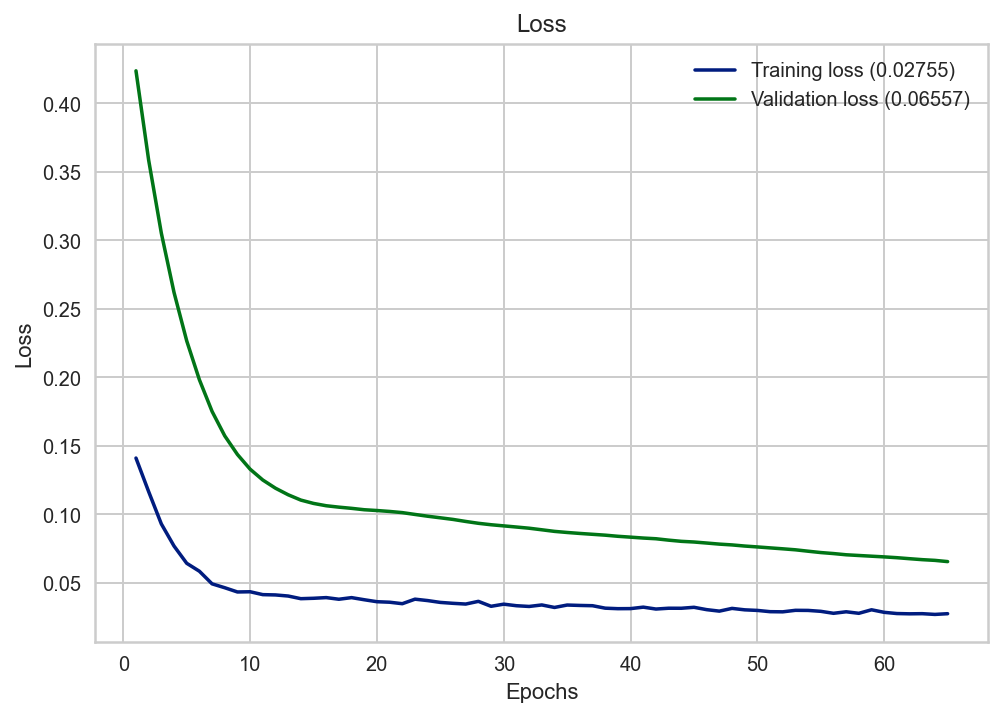

Test loss:                                                                                                             
0.1954048126935959                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.38012, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.38012 to 0.36462, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss did not improve from 0.36462
                                                                                                                       
Epoch 00004: val_loss did not improve from 0.36462


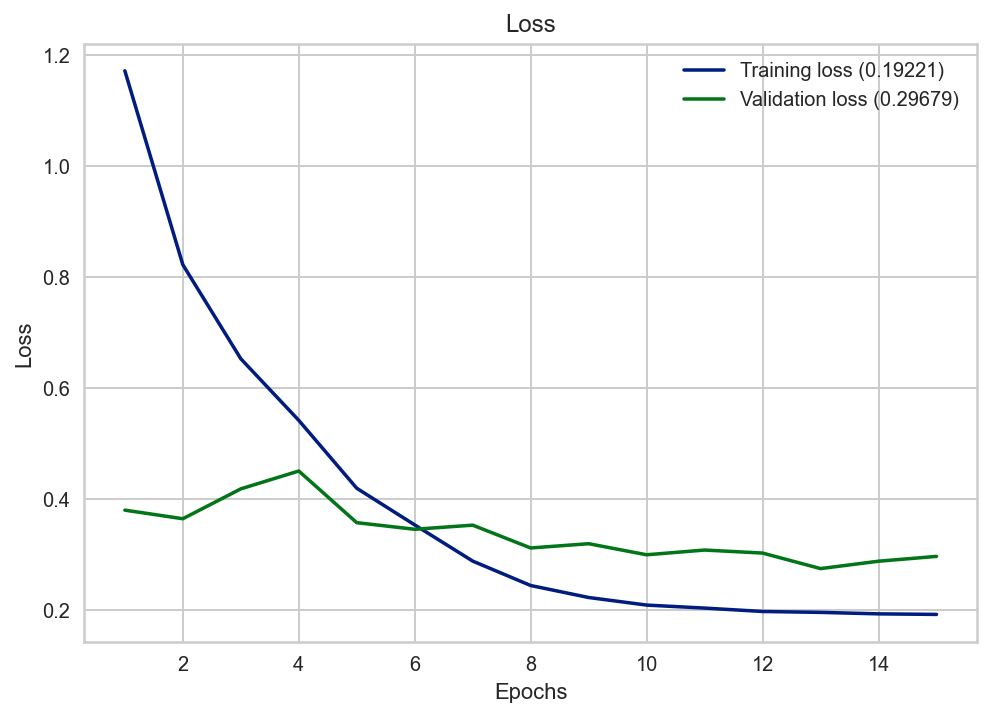

Test loss:                                                                                                             
0.3531535863876343                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.35697, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.35697 to 0.30033, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.30033 to 0.25484, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

                                                                                                                       
Epoch 00039: val_loss improved from 0.05021 to 0.04944, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00040: val_loss improved from 0.04944 to 0.04827, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.04827 to 0.04765, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.04765 to 0.04711, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00043: val_loss improved from 

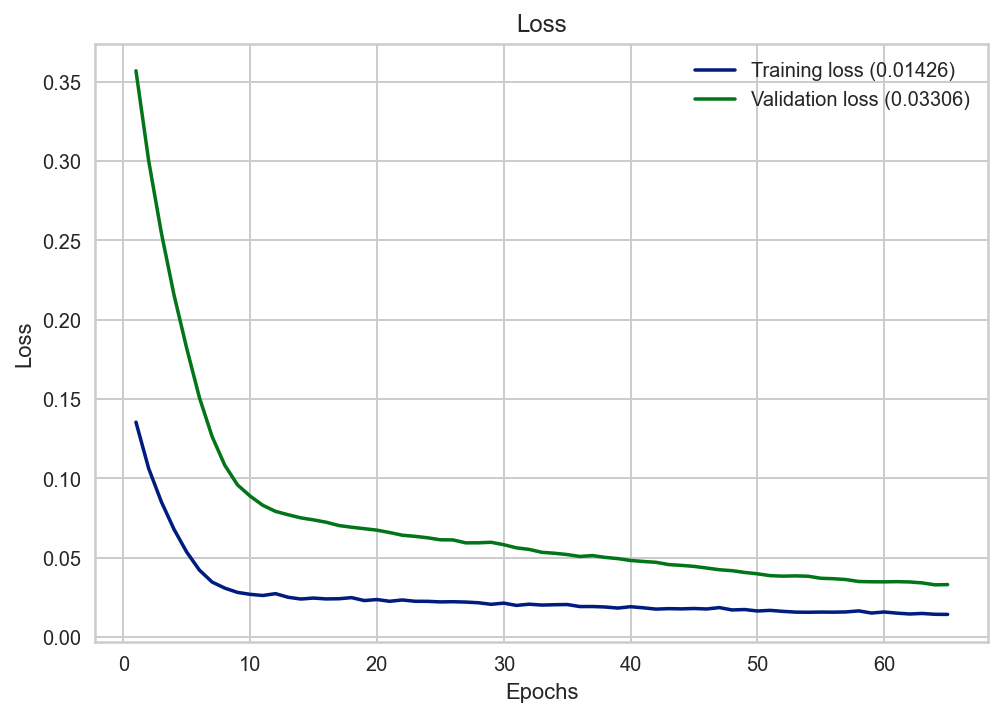

Test loss:                                                                                                             
0.12487001717090607                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.35269, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.35269 to 0.26741, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.26741 to 0.20821, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00040: val_loss improved from 0.08848 to 0.08734, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.08734 to 0.08689, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss did not improve from 0.08689
                                                                                                                       
Epoch 00043: val_loss improved from 0.08689 to 0.08572, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00044: val_loss did not improve from 0.08572
                                                                                                                       
Epoch 00045: val_loss did

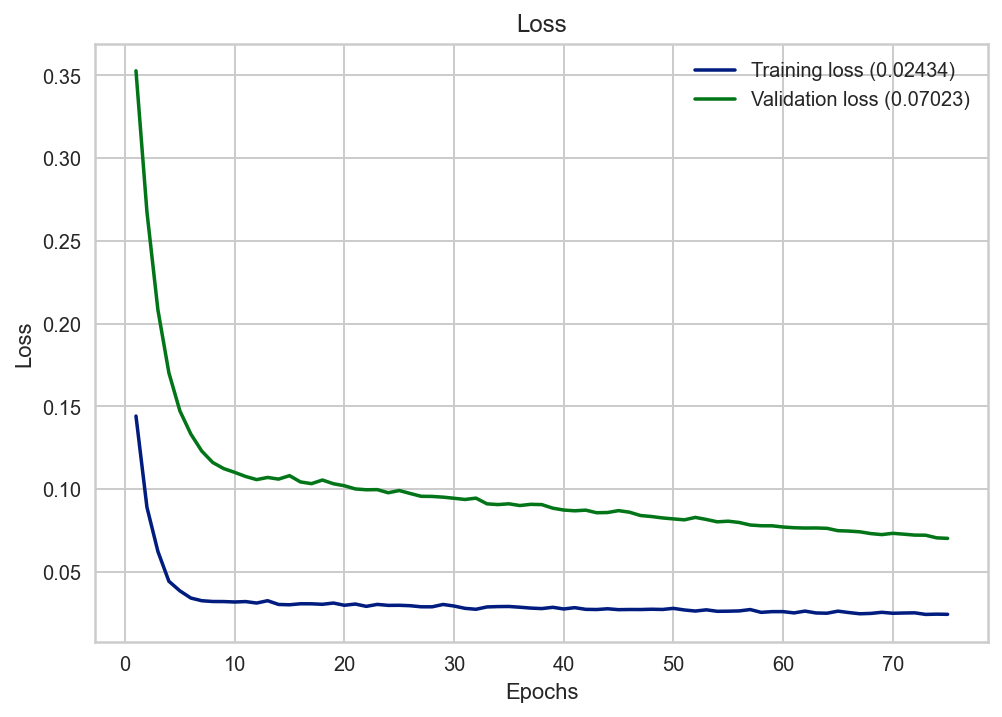

Test loss:                                                                                                             
0.23054224252700806                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.21184, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.21184 to 0.20430, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.20430 to 0.19668, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

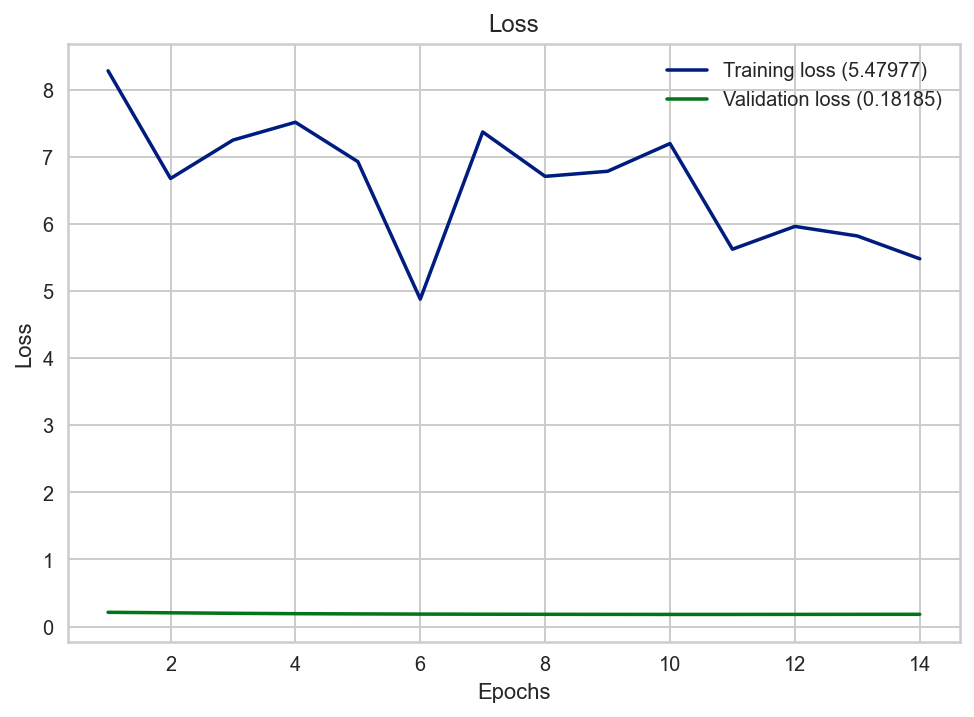

Test loss:                                                                                                             
0.1732240617275238                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.06807, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.06807 to 0.06005, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.06005 to 0.04165, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00040: val_loss improved from 0.01402 to 0.01397, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.01397 to 0.01387, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.01387 to 0.01368, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00043: val_loss did not improve from 0.01368
                                                                                                                       
Epoch 00044: val_loss did not improve from 0.01368
                                                                                                                       
Epoch 00045: val_loss did

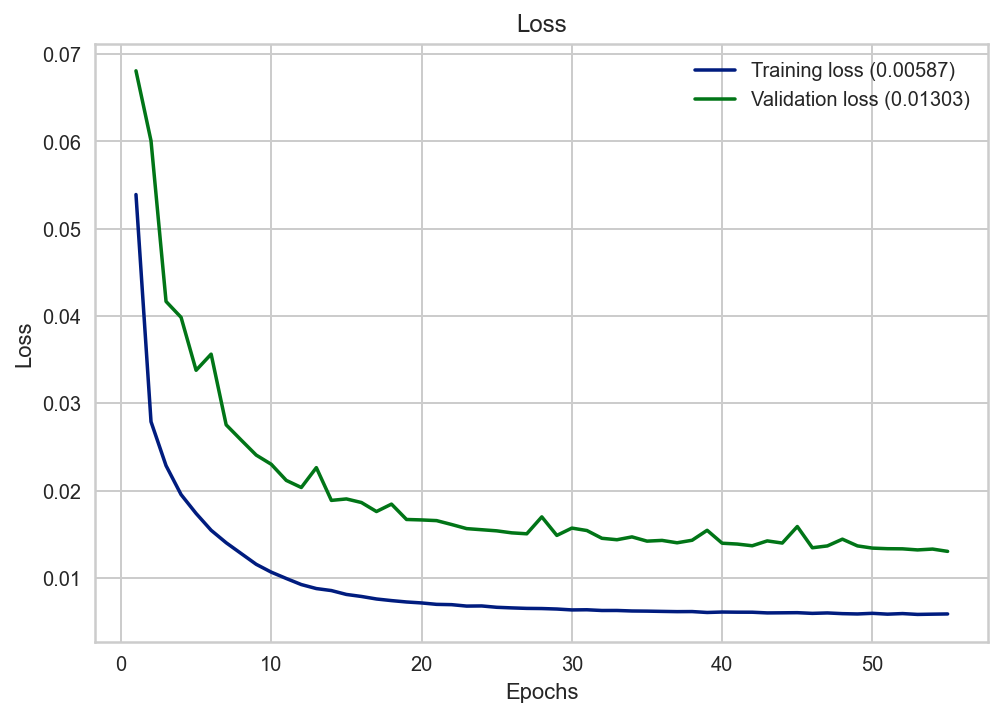

Test loss:                                                                                                             
0.01765395514667034                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.06529, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.06529 to 0.04910, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.04910 to 0.04325, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

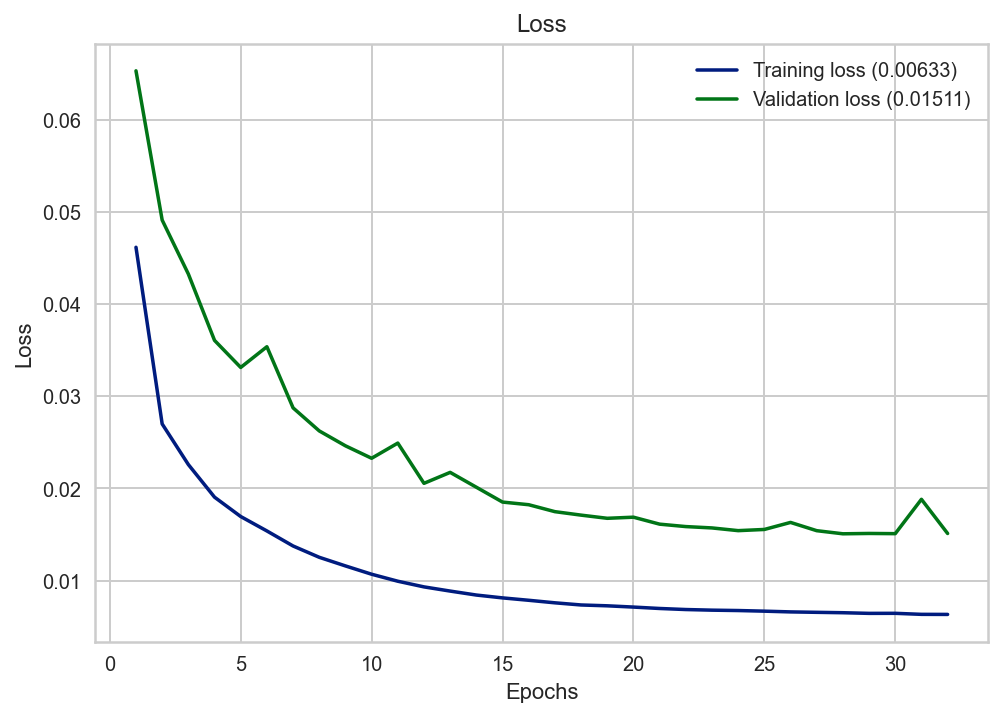

Test loss:                                                                                                             
0.04396604746580124                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.07450, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.07450 to 0.05591, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.05591 to 0.04116, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

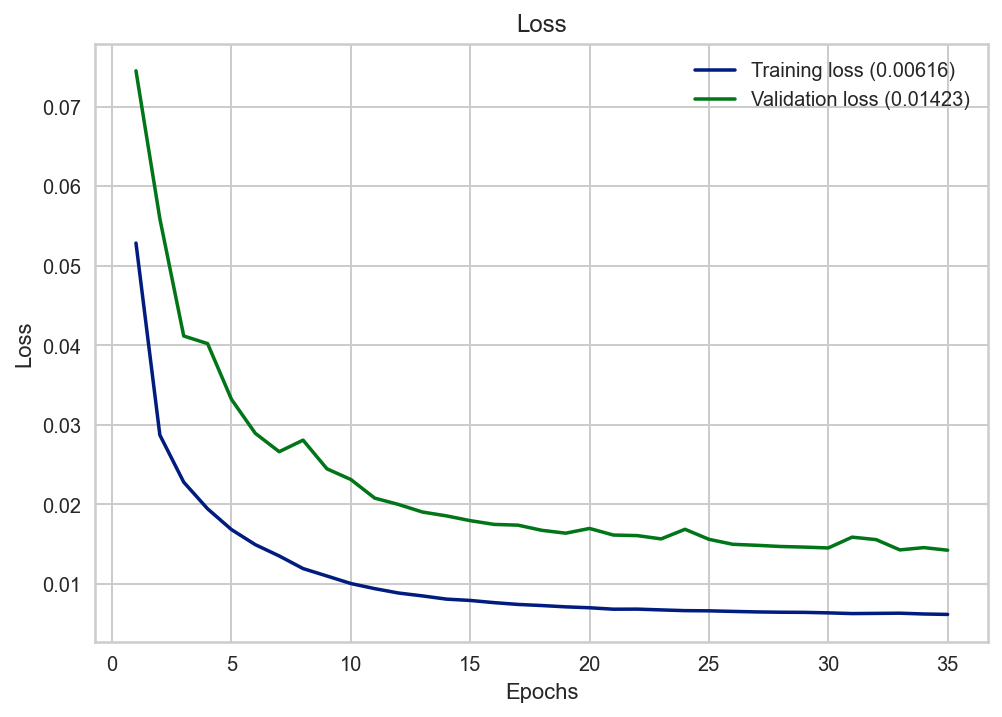

Test loss:                                                                                                             
0.02573513425886631                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.08379, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.08379 to 0.06559, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.06559 to 0.04856, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

                                                                                                                       
Epoch 00041: val_loss did not improve from 0.01398
                                                                                                                       
Epoch 00042: val_loss did not improve from 0.01398
                                                                                                                       
Epoch 00043: val_loss did not improve from 0.01398
                                                                                                                       
Epoch 00044: val_loss did not improve from 0.01398
 46%|█████████████████████▌                         | 23/50 [04:36<05:12, 11.57s/trial, best loss: 0.01765395514667034]

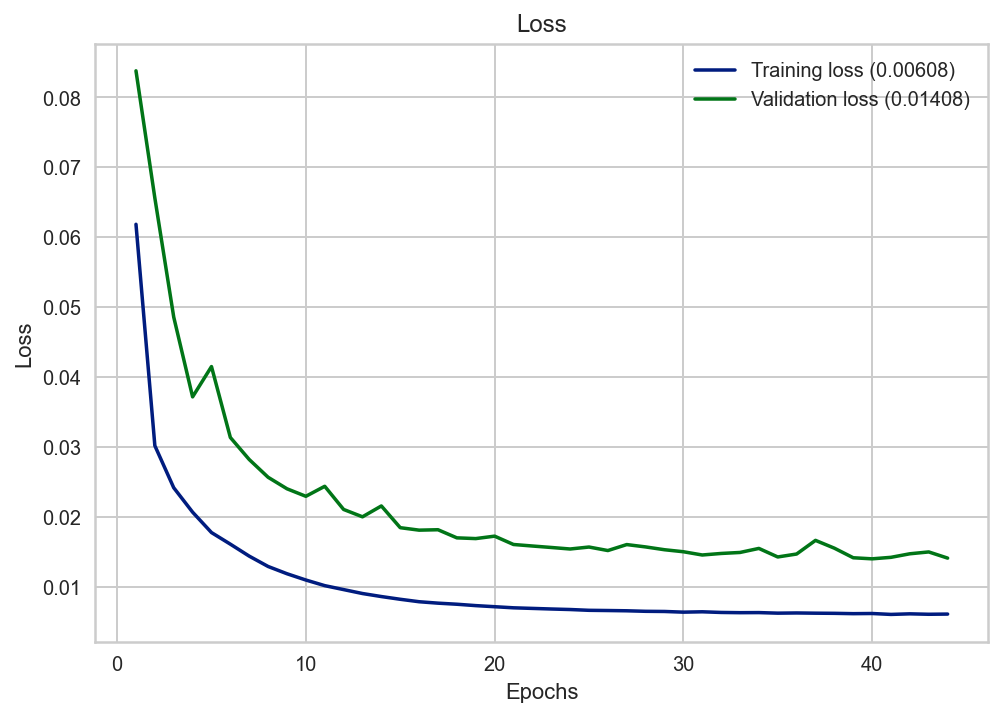

Test loss:                                                                                                             
0.037496596574783325                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.04898, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.04898 to 0.04323, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.04323 to 0.03214, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

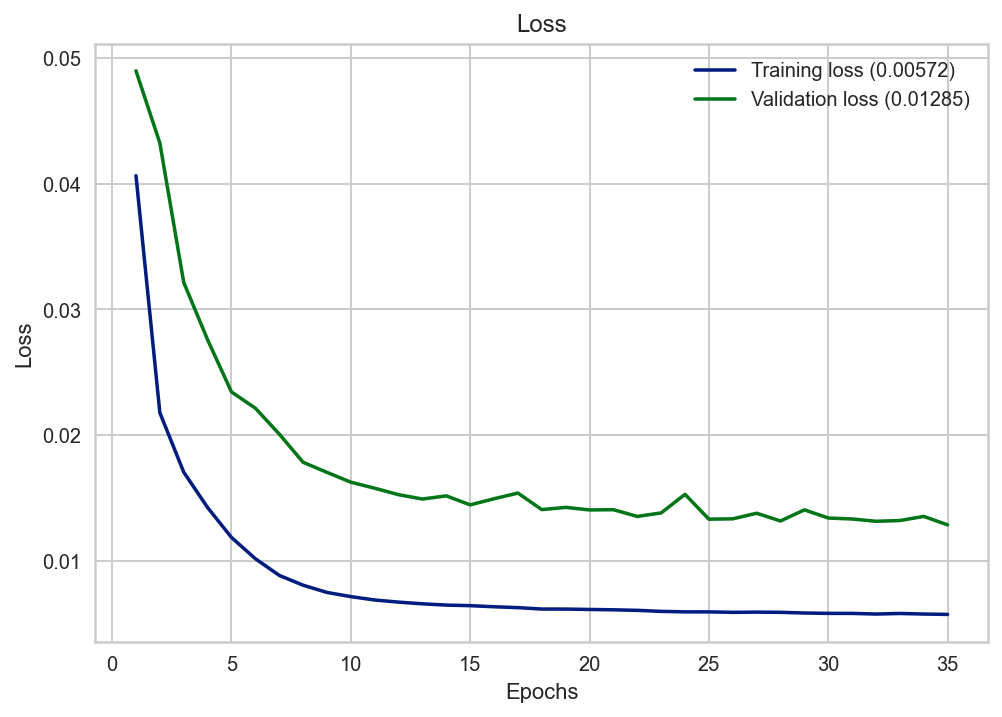

Test loss:                                                                                                             
0.022893205285072327                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.04999, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.04999 to 0.03830, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.03830 to 0.02911, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

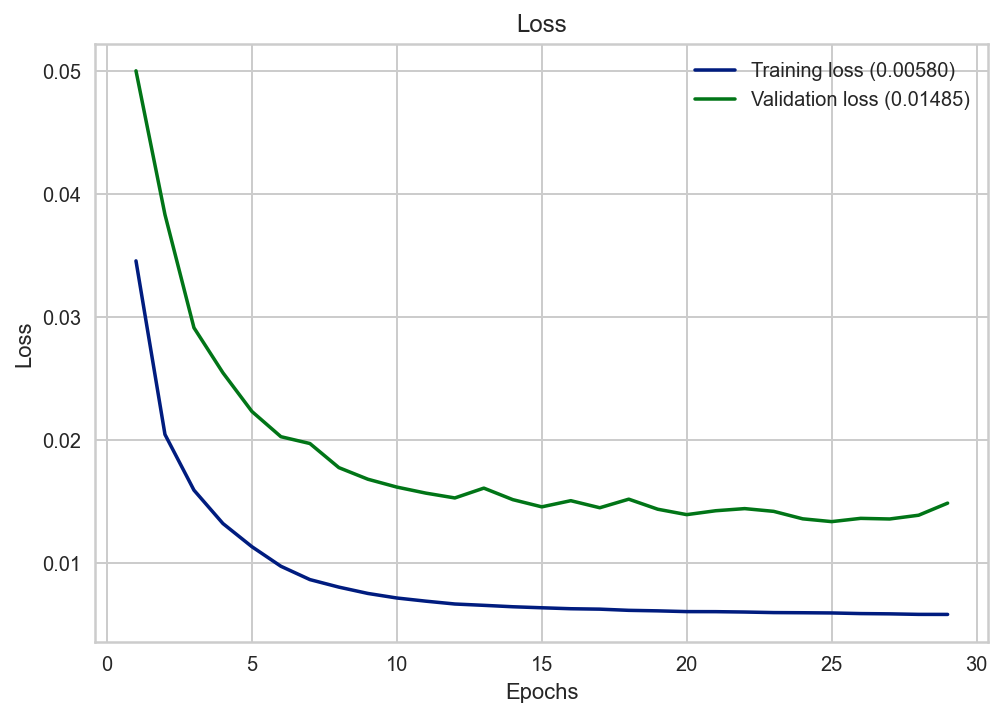

Test loss:                                                                                                             
0.05885004997253418                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.05539, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.05539 to 0.03677, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.03677 to 0.03045, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

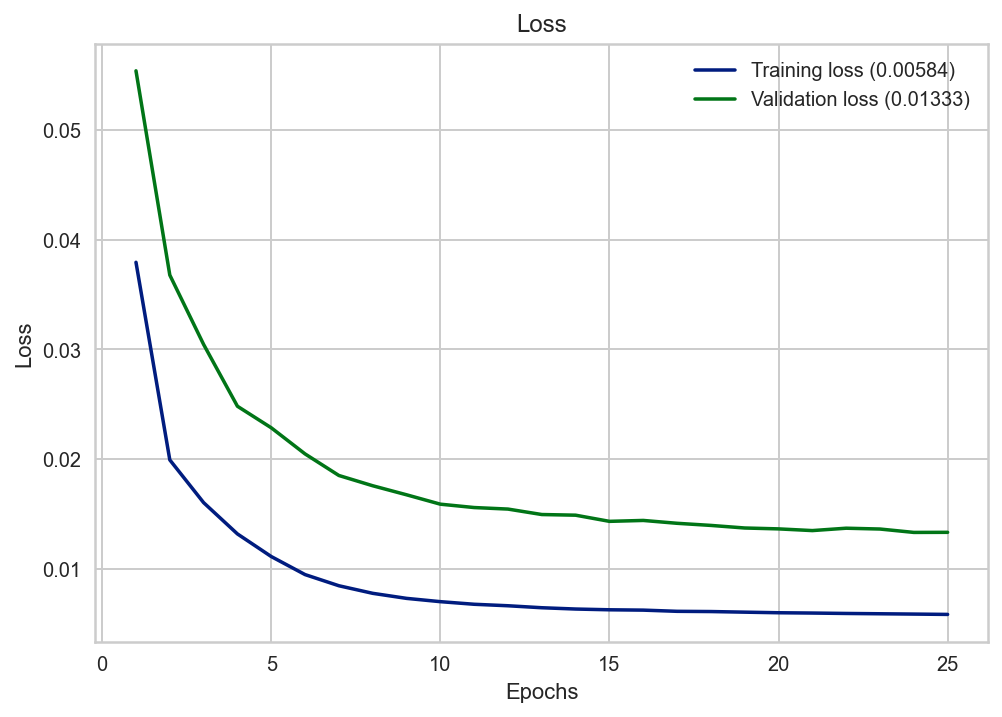

Test loss:                                                                                                             
0.029964081943035126                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.06203, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.06203 to 0.04176, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.04176 to 0.03498, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

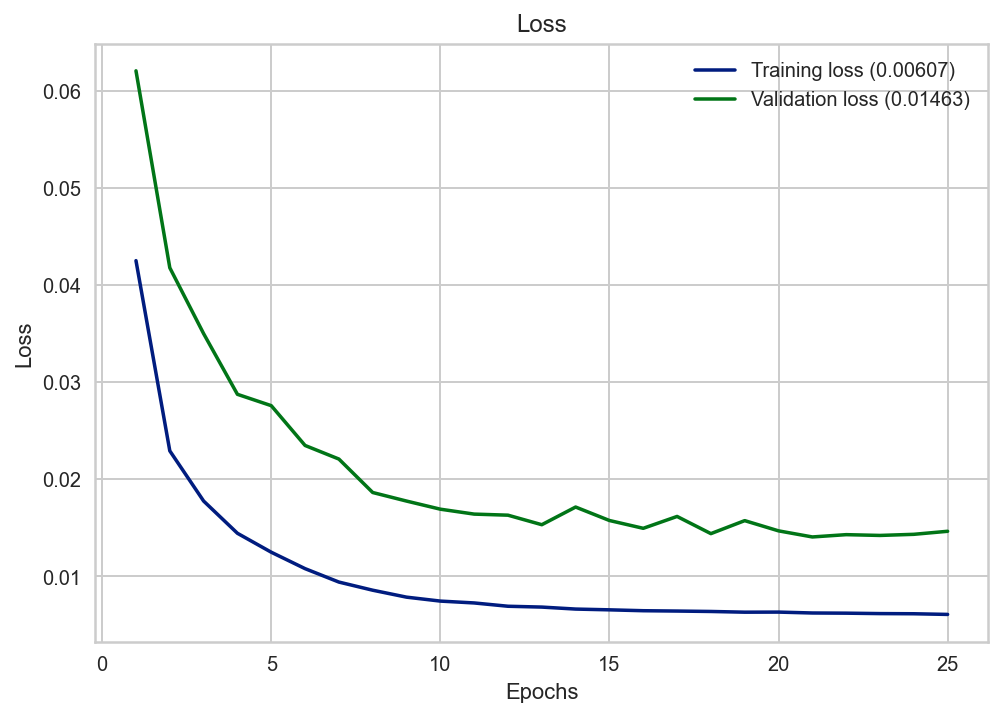

Test loss:                                                                                                             
0.048782192170619965                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.05880, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.05880 to 0.04892, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.04892 to 0.03859, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

                                                                                                                       
Epoch 00039: val_loss did not improve from 0.01436
                                                                                                                       
Epoch 00040: val_loss improved from 0.01436 to 0.01415, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss did not improve from 0.01415
                                                                                                                       
Epoch 00042: val_loss did not improve from 0.01415
                                                                                                                       
Epoch 00043: val_loss improved from 0.01415 to 0.01402, saving model to keras_weights.hdf5
                                                                 

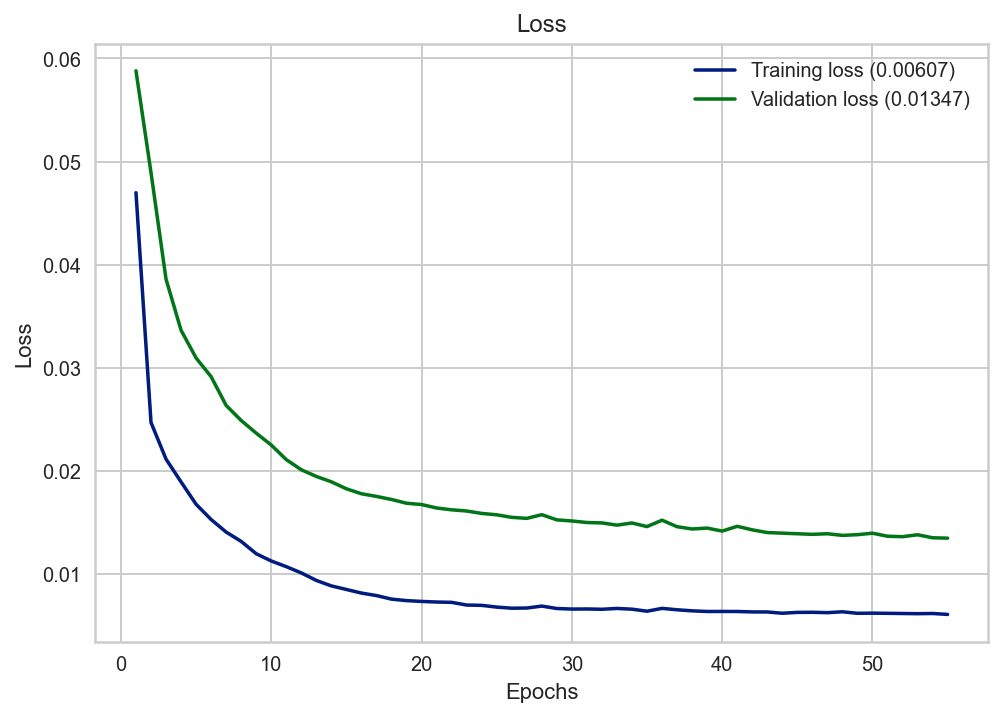

Test loss:                                                                                                             
0.023204322904348373                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.11688, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.11688 to 0.07729, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss did not improve from 0.07729
                                                                                                                       
Epoch 00004: val_loss improved from 0.07729 to 0.06

                                                                                                                       
Epoch 00040: val_loss improved from 0.02075 to 0.02019, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss did not improve from 0.02019
                                                                                                                       
Epoch 00042: val_loss improved from 0.02019 to 0.02003, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00043: val_loss improved from 0.02003 to 0.01970, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00044: val_loss improved from 0.01970 to 0.01926, saving model to kera

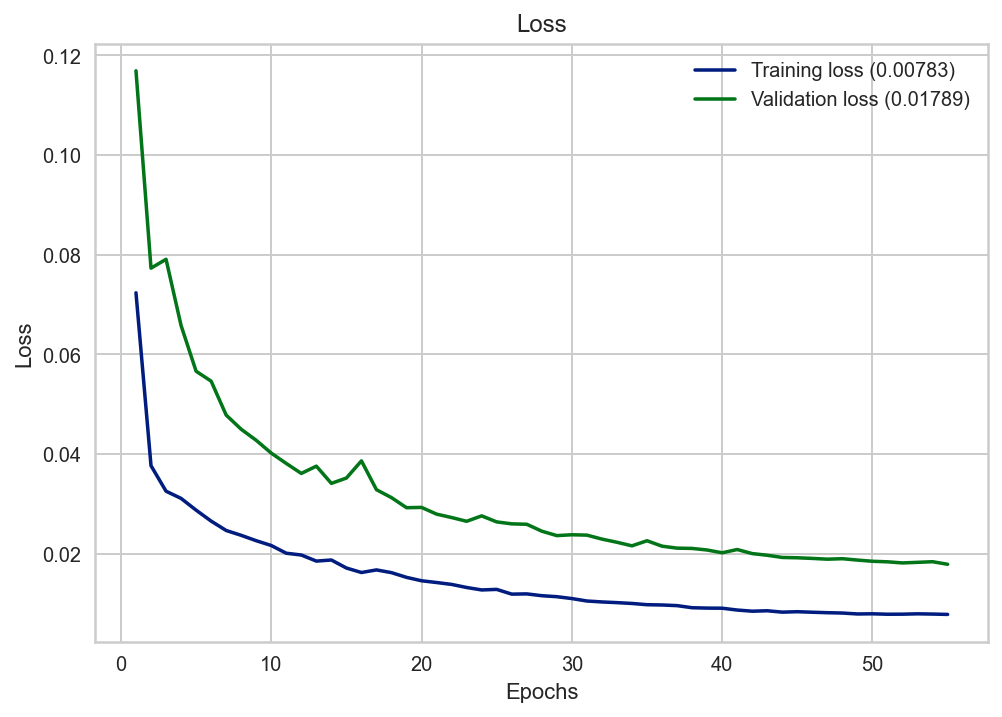

Test loss:                                                                                                             
0.030724991112947464                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.26145, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.26145 to 0.17983, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.17983 to 0.13403, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

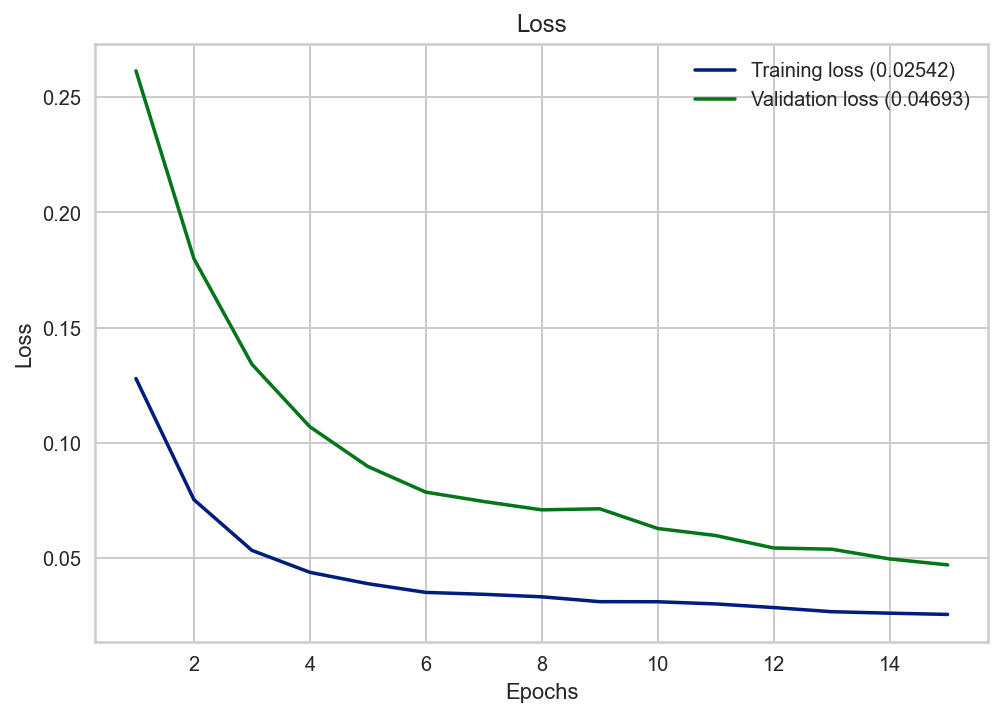

Test loss:                                                                                                             
0.11148940771818161                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.04414, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.04414 to 0.03560, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.03560 to 0.02964, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

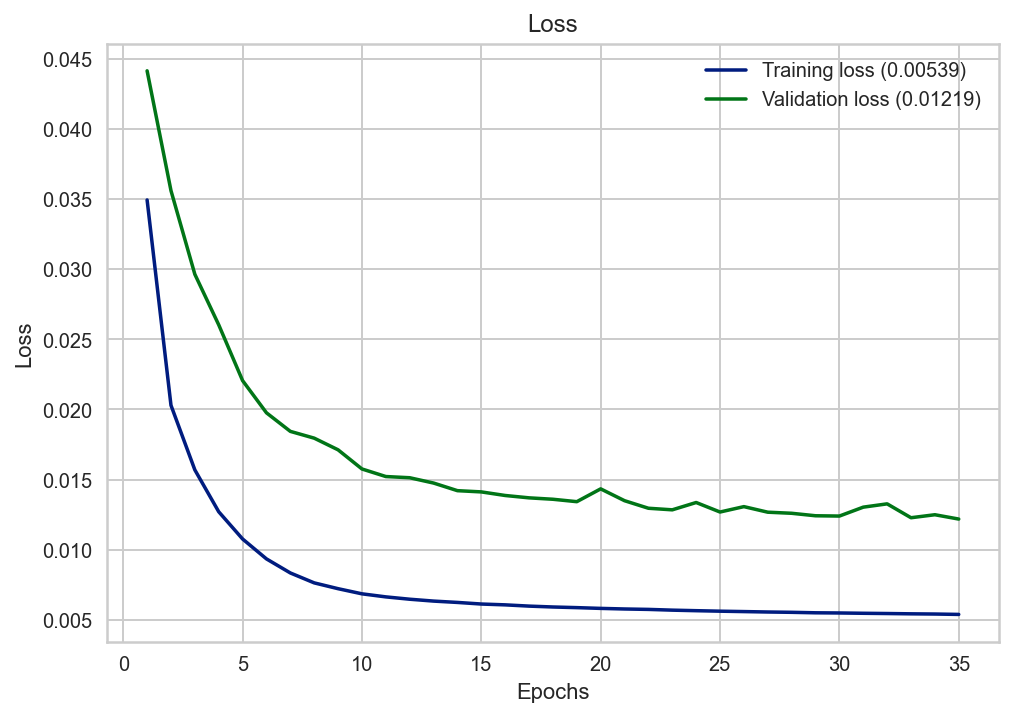

Test loss:                                                                                                             
0.0077024283818900585                                                                                                  
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.20541, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.20541 to 0.10264, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.10264 to 0.08836, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00041: val_loss improved from 0.02307 to 0.02226, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.02226 to 0.02165, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00043: val_loss improved from 0.02165 to 0.02031, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00044: val_loss improved from 0.02031 to 0.02028, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00045: val_loss did not improve from 0.02028
                                                                                                         

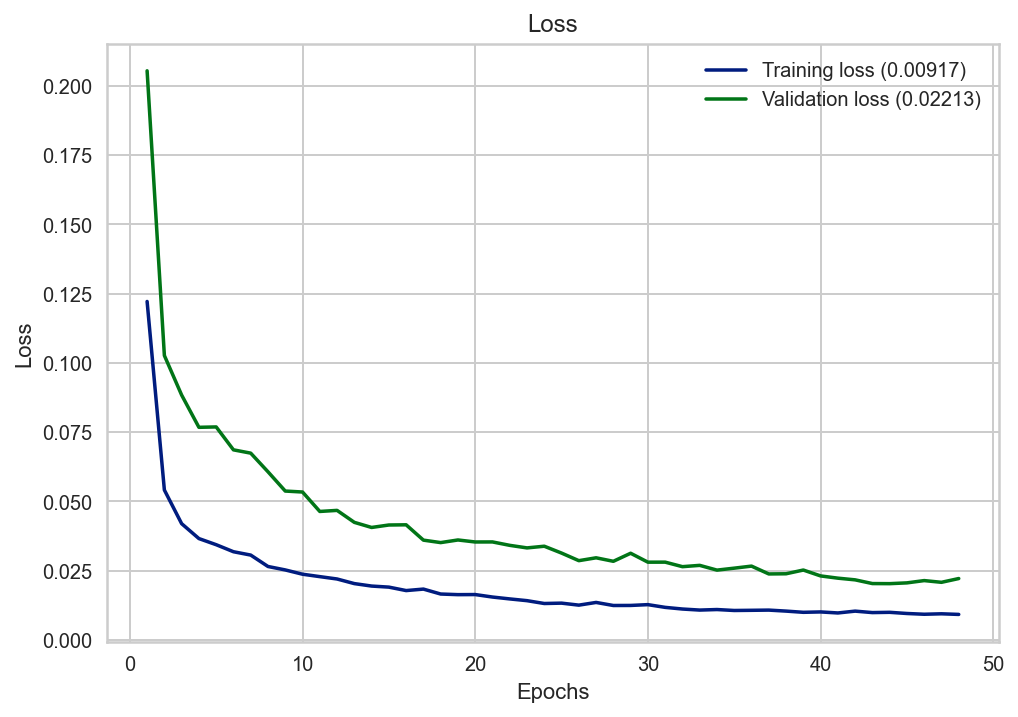

Test loss:                                                                                                             
0.08206290006637573                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.06143, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.06143 to 0.05446, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.05446 to 0.04166, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

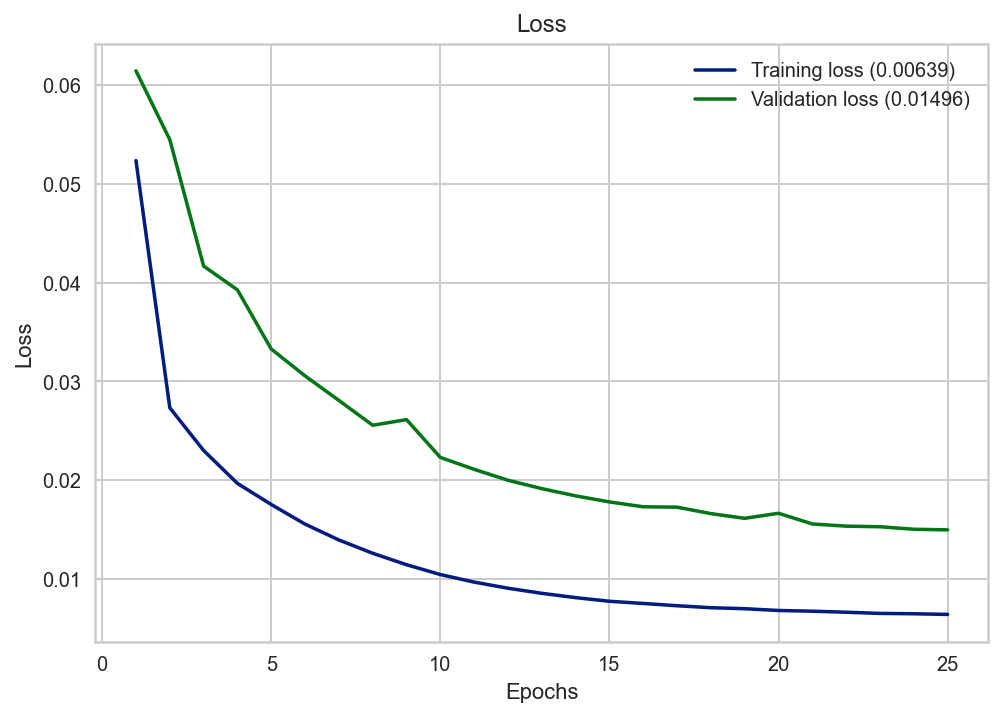

Test loss:                                                                                                             
0.00542948255315423                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.30163, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.30163 to 0.17960, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.17960 to 0.10830, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

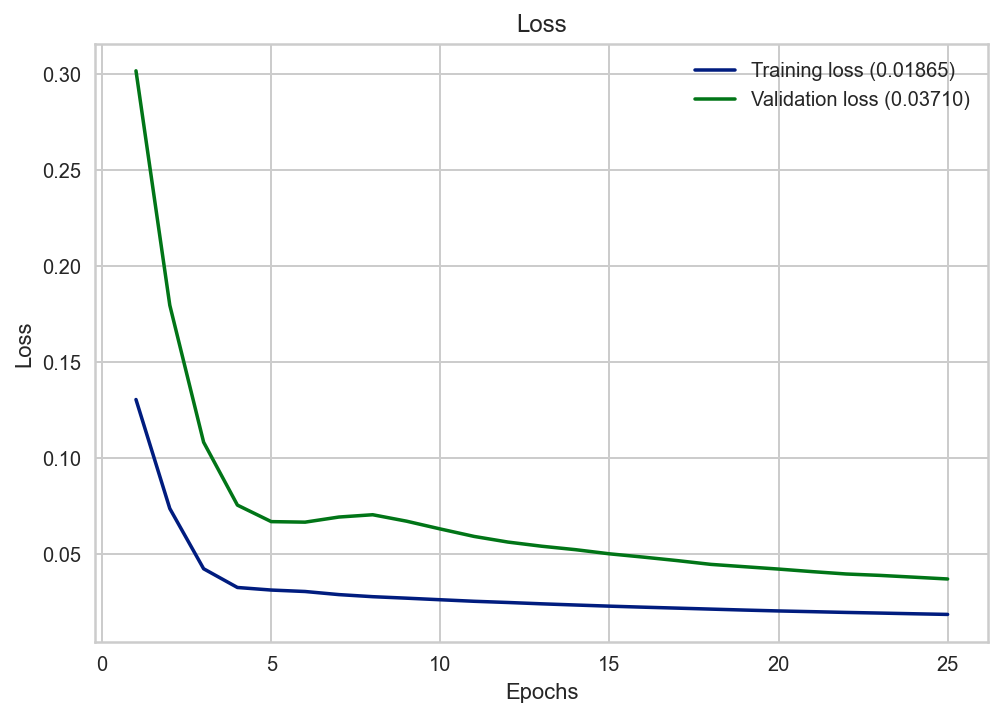

Test loss:                                                                                                             
0.08558271825313568                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.03938, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.03938 to 0.02848, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.02848 to 0.02420, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

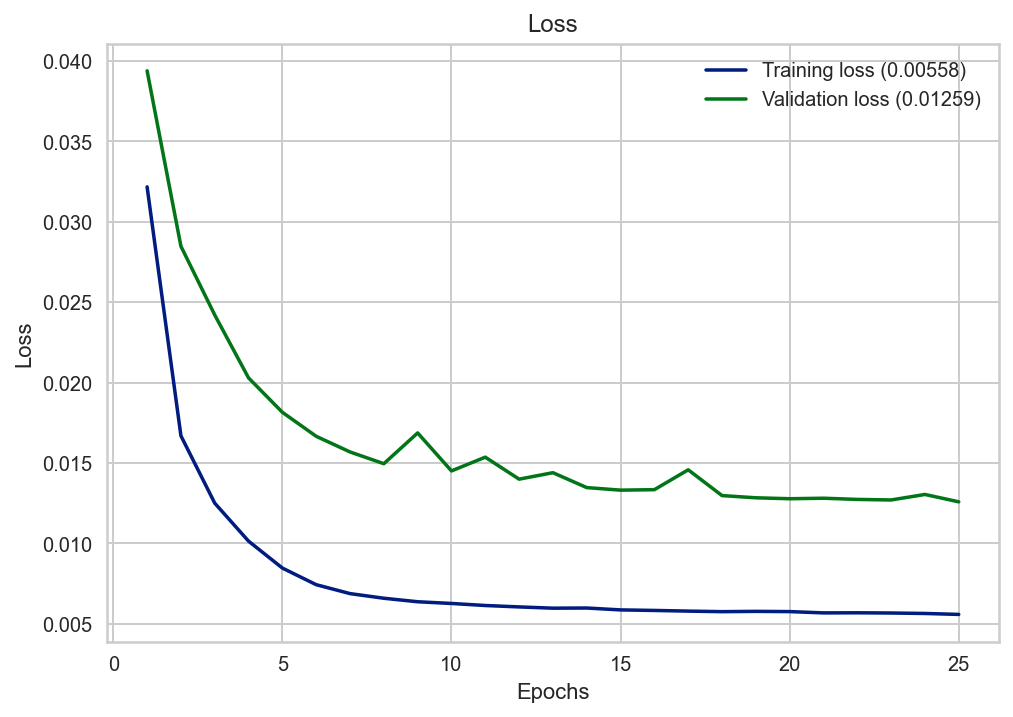

Test loss:                                                                                                             
0.014326890930533409                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.27495, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.27495 to 0.19248, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.19248 to 0.14496, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

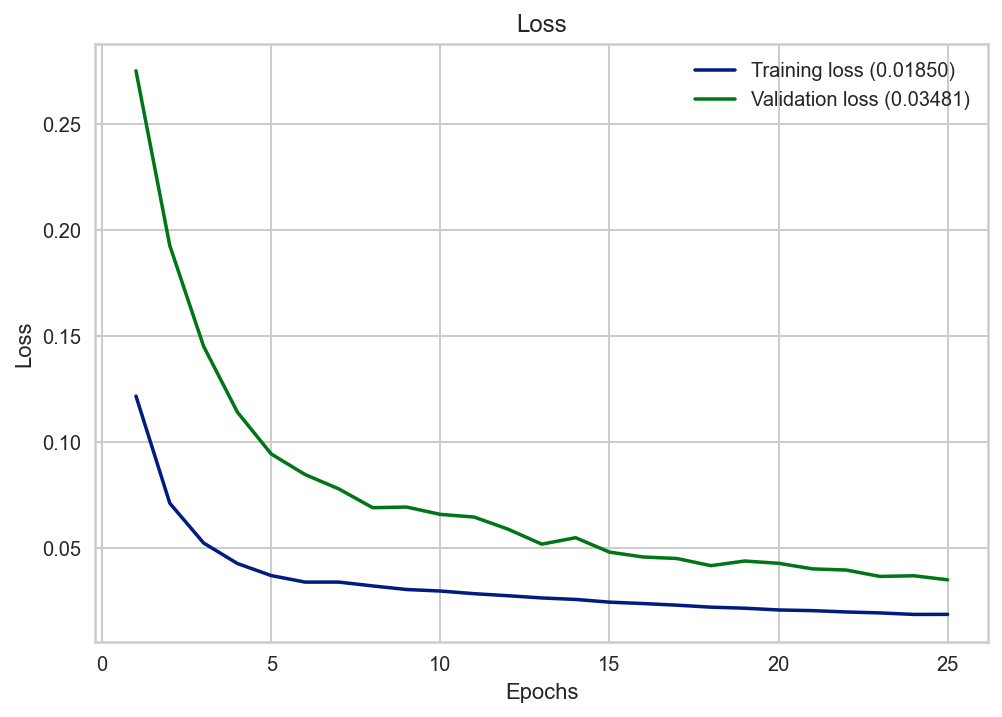

Test loss:                                                                                                             
0.07400282472372055                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.10421, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.10421 to 0.08182, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.08182 to 0.06434, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

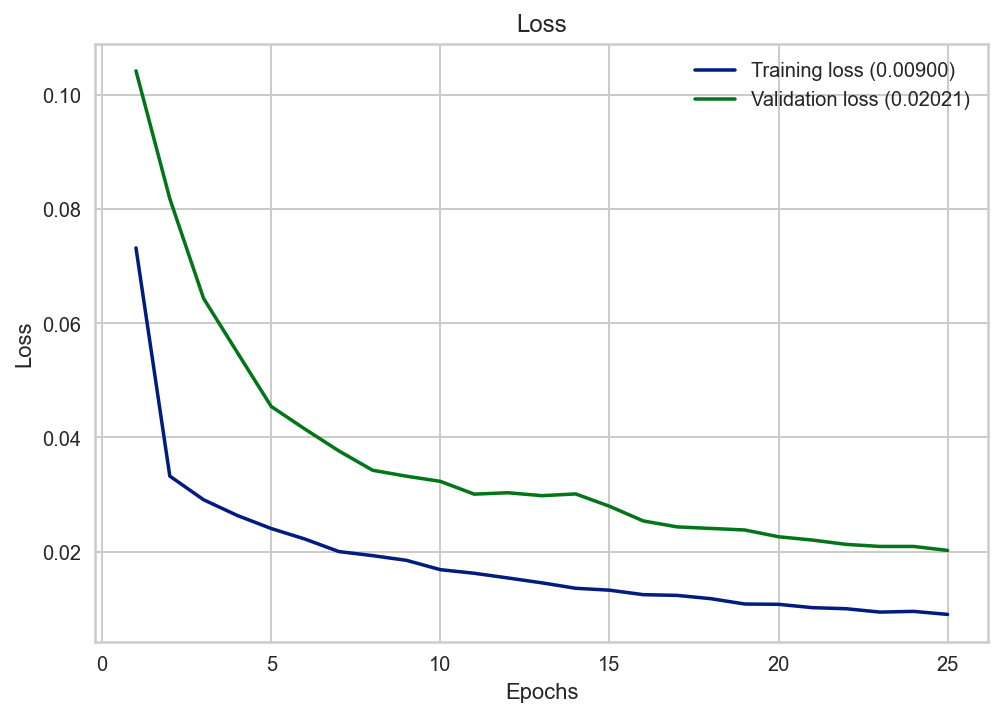

Test loss:                                                                                                             
0.03614715486764908                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.35141, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.35141 to 0.26995, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.26995 to 0.19303, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

Epoch 00038: val_loss improved from 0.02410 to 0.02368, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00039: val_loss improved from 0.02368 to 0.02343, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00040: val_loss improved from 0.02343 to 0.02295, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.02295 to 0.02266, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.02266 to 0.02227, saving model to keras_weights.hdf5
                                                                 

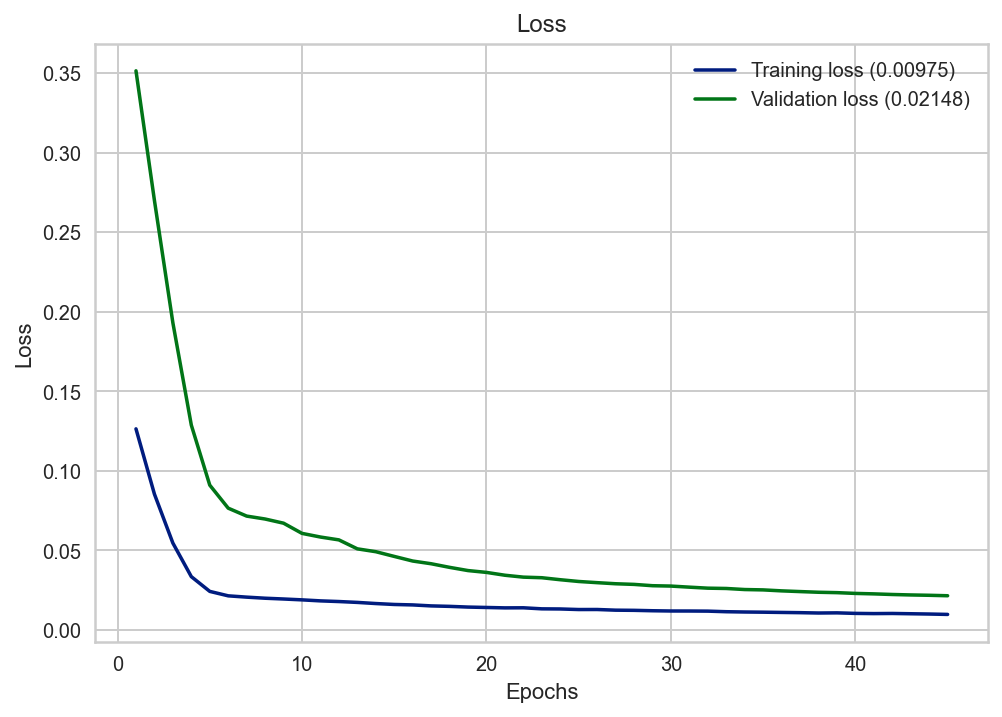

Test loss:                                                                                                             
0.05799117311835289                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.05534, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.05534 to 0.03675, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.03675 to 0.02909, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

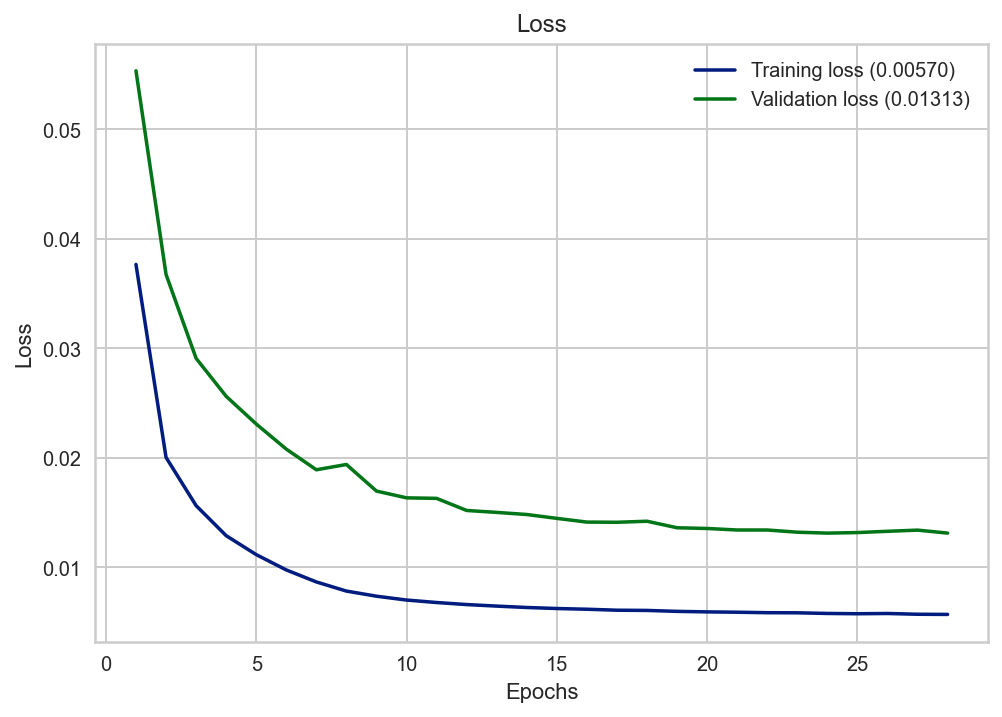

Test loss:                                                                                                             
0.011242421343922615                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.21321, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.21321 to 0.15790, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.15790 to 0.13858, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

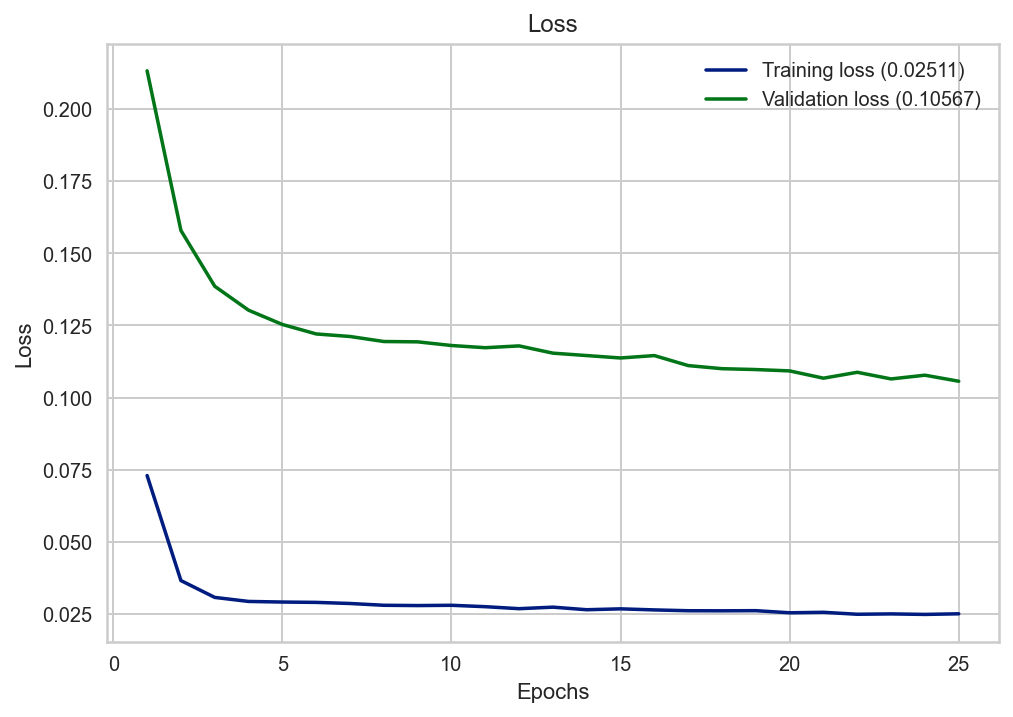

Test loss:                                                                                                             
0.29866114258766174                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.06219, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.06219 to 0.04873, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.04873 to 0.04278, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

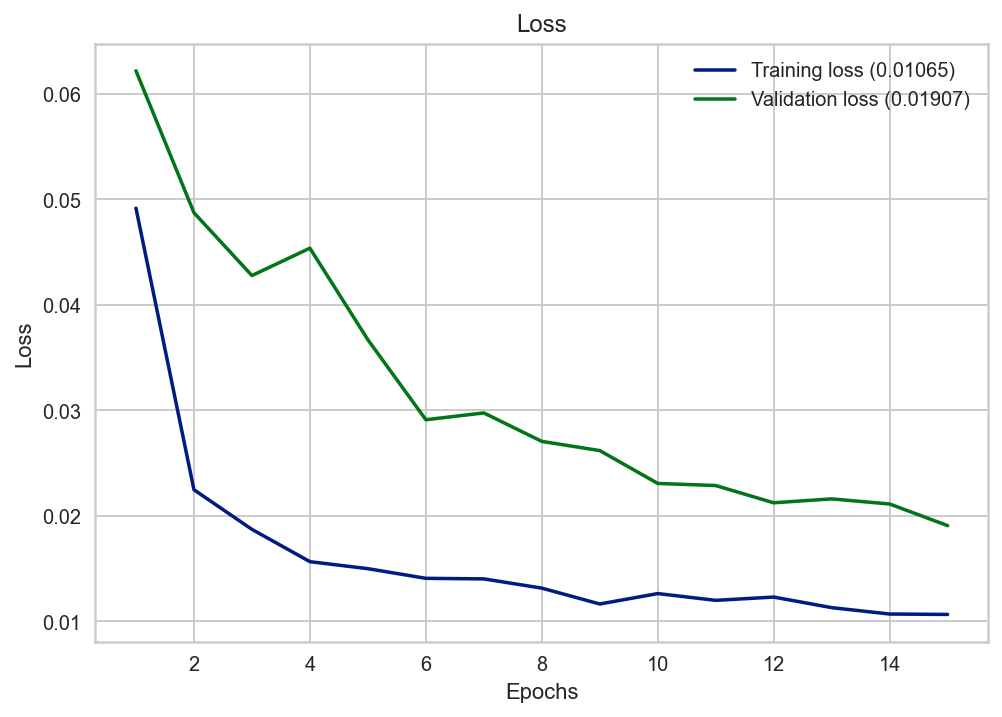

Test loss:                                                                                                             
0.06756003201007843                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.43815, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.43815 to 0.36150, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.36150 to 0.32161, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

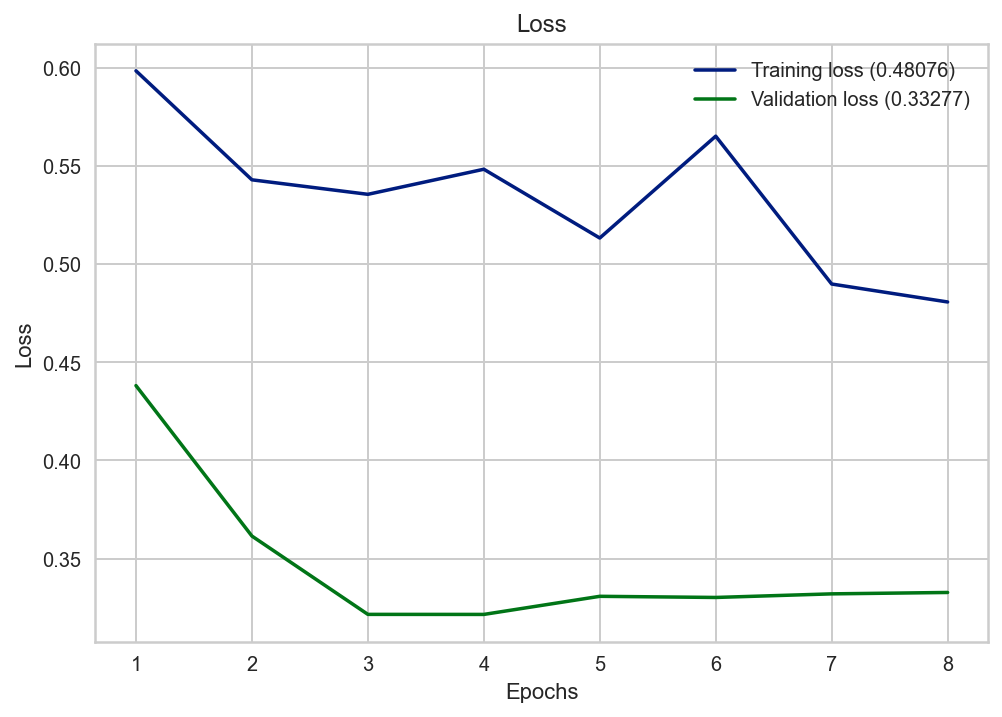

Test loss:                                                                                                             
0.3324439227581024                                                                                                     
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.22601, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.22601 to 0.16122, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.16122 to 0.14135, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

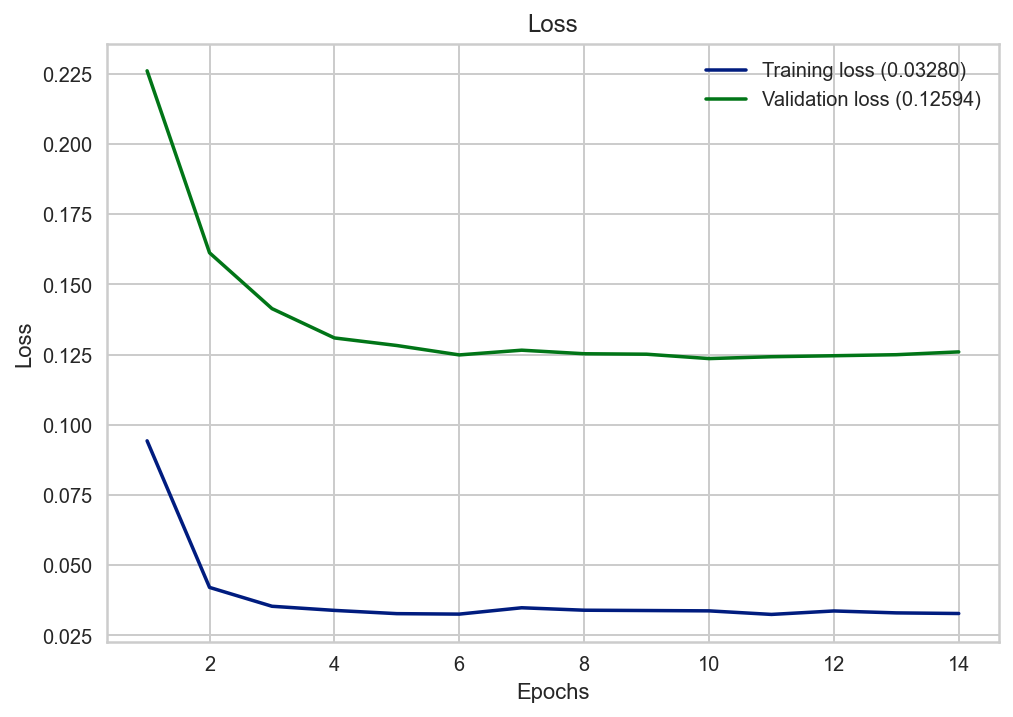

Test loss:                                                                                                             
0.33372393250465393                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.06223, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.06223 to 0.04663, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.04663 to 0.03773, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

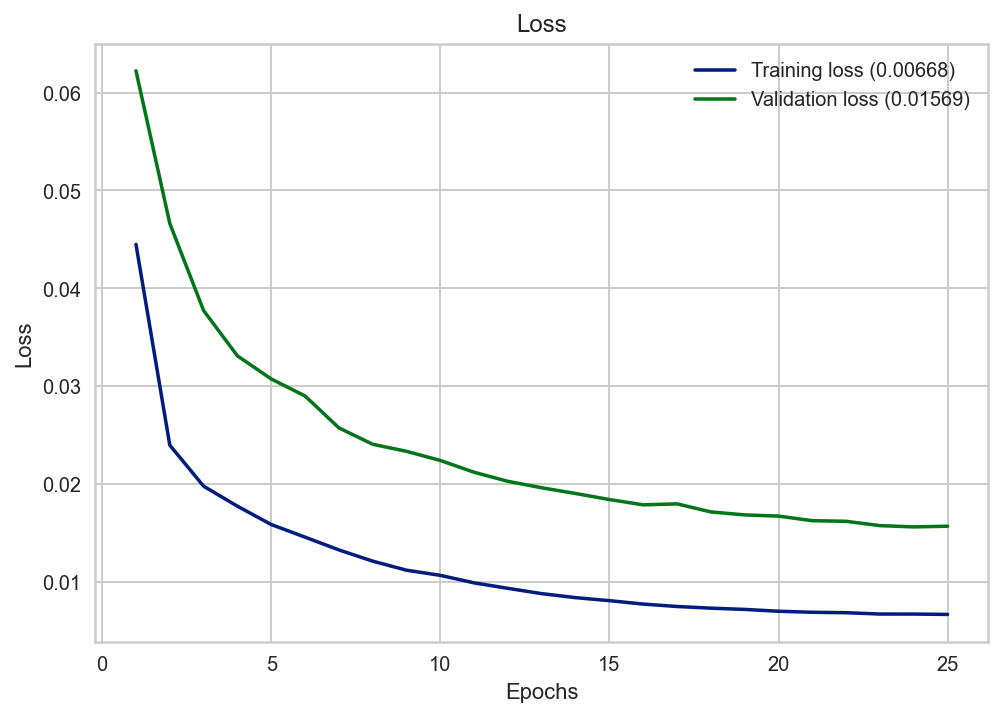

Test loss:                                                                                                             
0.014608082361519337                                                                                                   
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.11486, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.11486 to 0.07204, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.07204 to 0.06197, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

                                                                                                                       
Epoch 00040: val_loss improved from 0.01618 to 0.01603, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss improved from 0.01603 to 0.01584, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00042: val_loss improved from 0.01584 to 0.01577, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00043: val_loss did not improve from 0.01577
                                                                                                                       
Epoch 00044: val_loss improved from 0.01577 to 0.01570, saving model to kera

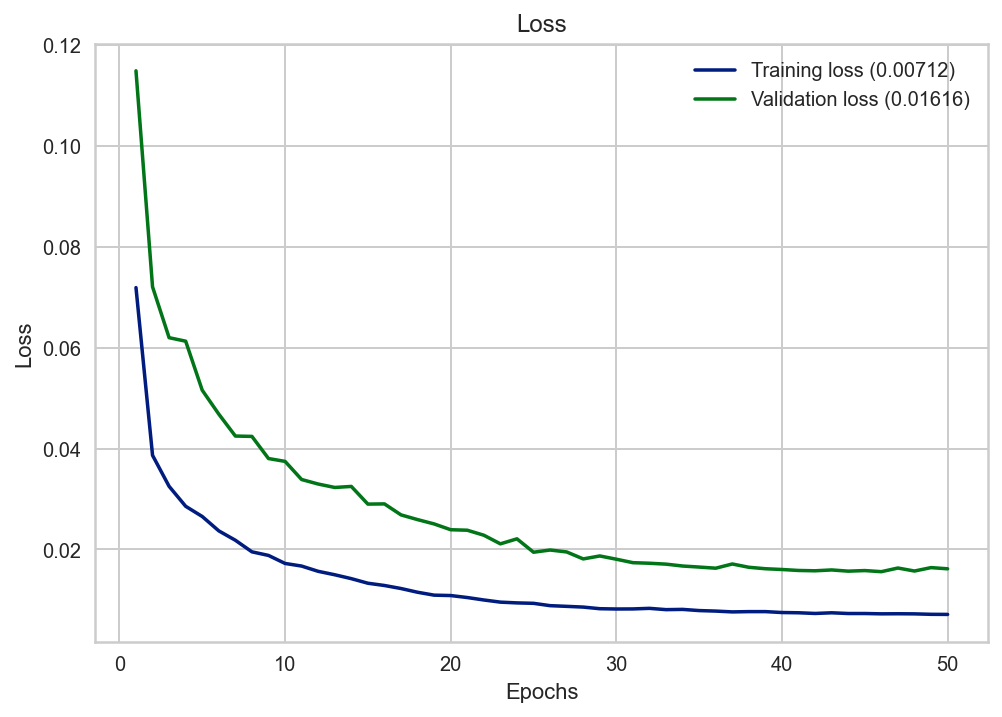

Test loss:                                                                                                             
0.04869011789560318                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.39452, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss did not improve from 0.39452
                                                                                                                       
Epoch 00003: val_loss did not improve from 0.39452
                                                                                                                       
Epoch 00004: val_loss did not improve from 0.39452
                                        

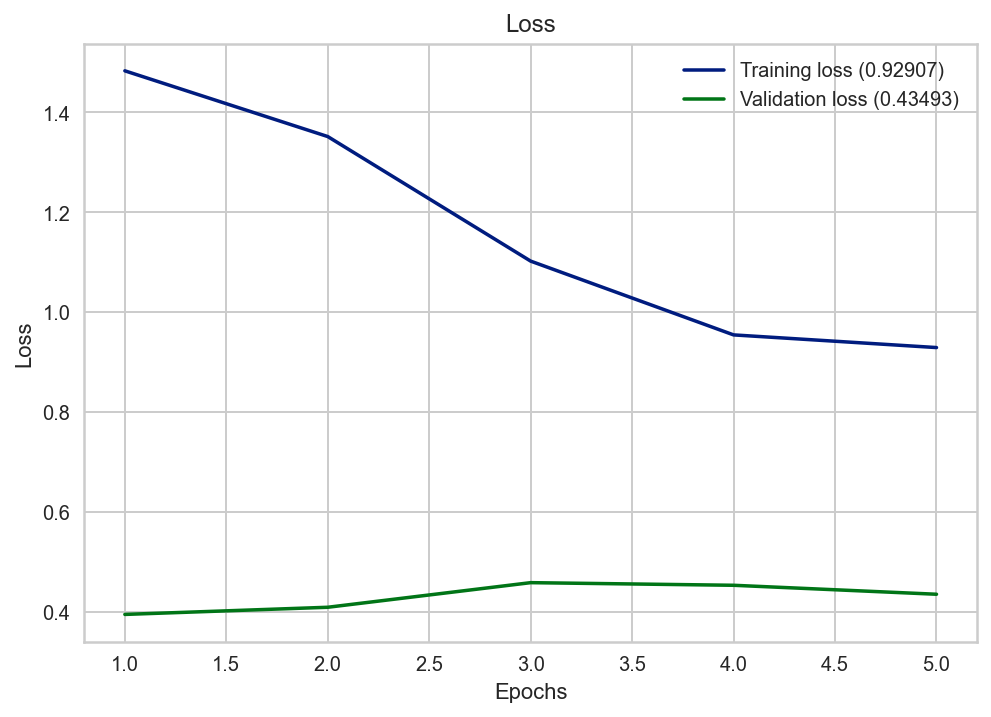

Test loss:                                                                                                             
0.39415091276168823                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.17371, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.17371 to 0.13314, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.13314 to 0.12517, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

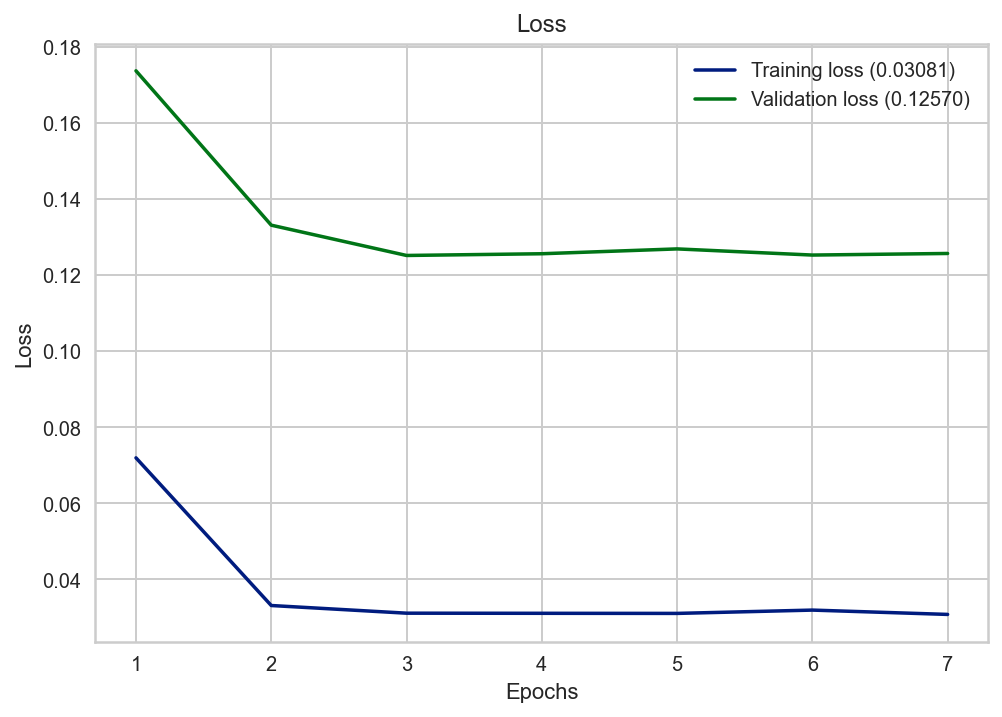

Test loss:                                                                                                             
0.33304667472839355                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.33100, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.33100 to 0.25148, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.25148 to 0.18178, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

                                                                                                                       
Epoch 00039: val_loss improved from 0.02865 to 0.02811, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00040: val_loss improved from 0.02811 to 0.02744, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00041: val_loss did not improve from 0.02744
                                                                                                                       
Epoch 00042: val_loss improved from 0.02744 to 0.02691, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00043: val_loss improved from 0.02691 to 0.02648, saving model to kera

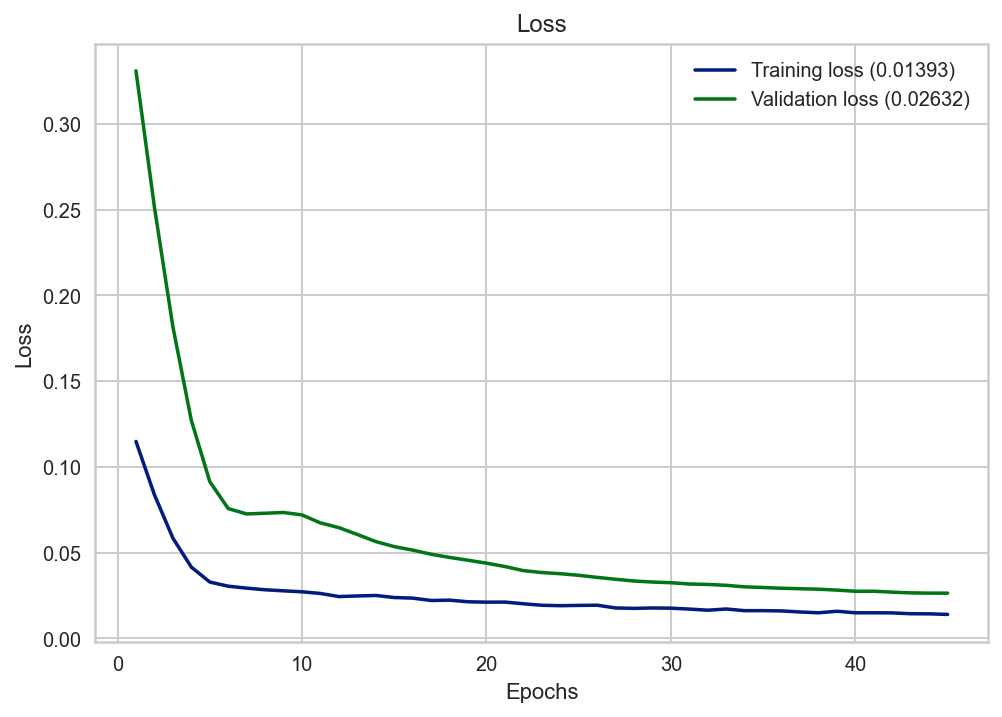

Test loss:                                                                                                             
0.06233585998415947                                                                                                    
                                                                                                                       
Epoch 00001: val_loss improved from inf to 0.12159, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00002: val_loss improved from 0.12159 to 0.06763, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00003: val_loss improved from 0.06763 to 0.04969, saving model to keras_weights.hdf5
                                                                                                                       
Epoch 00004

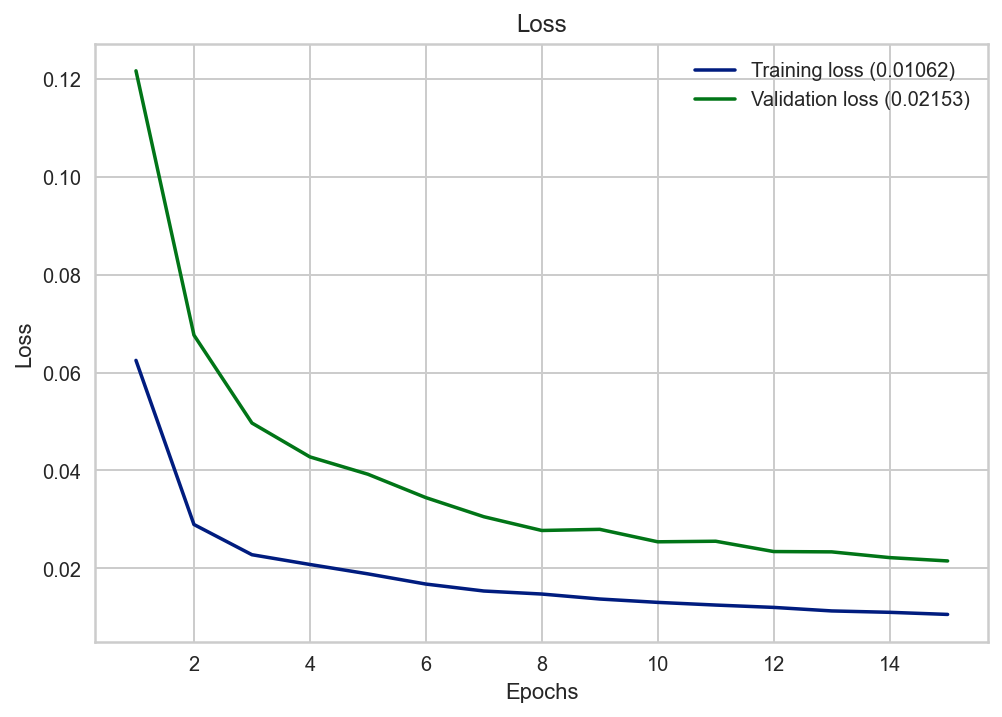

Test loss:                                                                                                             
0.04842526838183403                                                                                                    
100%|███████████████████████████████████████████████| 50/50 [08:49<00:00, 10.59s/trial, best loss: 0.00542948255315423]
{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 0.31901413202285767, 'status': 'ok', 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000011E4CDDFB80>}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'Activation': [0], 'LSTM': [0], 'batch_size': [0], 'epochs': [0], 'optimizer': [0], 'rate': [0]}, 'vals': {'Activation': [1], 'LSTM': [1], 'batch_size': [3], 'epochs': [6], 'optimizer': [0], 'rate': [0.4371162594318422]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2021, 2, 13, 8, 26, 21, 495000), 'refresh_time': datetime.

In [122]:
import numpy as np

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, Flatten, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import keras.layers
import keras
import tensorflow as tf


from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas
import matplotlib.pyplot as plt
import pickle
import importlib

%config InlineBackend.figure_format='retina'
importlib.reload(np_utils)
importlib.reload(optim)


def plot_history(history):
    loss_list = [
        s for s in history.history.keys() if 'loss' in s and 'val' not in s
    ]
    val_loss_list = [
        s for s in history.history.keys() if 'loss' in s and 'val' in s
    ]
    acc_list = [
        s for s in history.history.keys() if 'acc' in s and 'val' not in s
    ]
    val_acc_list = [
        s for s in history.history.keys() if 'acc' in s and 'val' in s
    ]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs,
                 history.history[l],
                 label='Training loss (' +
                 str(str(format(history.history[l][-1], '.5f')) + ')'))
    for l in val_loss_list:
        plt.plot(epochs,
                 history.history[l],
                 label='Validation loss (' +
                 str(str(format(history.history[l][-1], '.5f')) + ')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.style.use('seaborn-dark-palette')
    plt.grid(True)
    plt.show()


def data():
    global scaler

    import pandas as pd
    import pandas

    dataset = read_csv('data/train.csv', index_col="Date")
    values = dataset.values

    scaler = MinMaxScaler(feature_range=(0, 1))

    scaled = scaler.fit_transform(values)
    scaled = pd.DataFrame(scaled)

    def ts(dataset, look_back=9, pred_col=1):
        t = dataset.copy()
        t['id'] = range(1, len(t) + 1)
        t = t.iloc[:-look_back, :]
        t.set_index('id', inplace=True)
        pred_value = dataset.copy()
        pred_value = pred_value.iloc[look_back:, pred_col]
        pred_value.columns = ['close_nextday']
        pred_value = pd.DataFrame(pred_value)

        pred_value['id'] = range(1, len(pred_value) + 1)
        pred_value.set_index('id', inplace=True)
        df = pd.concat([t, pred_value], axis=1)

        return df

    arr_df = ts(scaled, 9, 0)
    arr_df.fillna(0, inplace=True)
    arr_df.columns = [
        'close', 'volume', 'ema_short', 'ema_long', 'atr', 'obv',
        'tweet_sentiment', 'close_nextday', 'target_lookBack'
    ]

    arr_df = arr_df.drop(['close_nextday'], axis=1)

    values = arr_df.values
    train_sample = int(len(dataset) * 0.8)
    train = values[:train_sample, :]
    test = values[train_sample:, :]

    X_train = train[:352]
    y_train = train[:352]
    X_test = test[:80]
    y_test = test[:80]

    y_train = np.delete(y_train, range(0, 7), 1)
    y_train = y_train.ravel()

    y_test = np.delete(y_test, range(0, 7), 1)
    y_test = y_test.ravel()

    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train, y_train, X_test, y_test


def model(X_train, y_train, X_test, y_test):

    import tensorflow as tf
    from keras.layers import Bidirectional
    from tensorflow.keras import regularizers

    acc_metric = tf.keras.metrics.MeanAbsolutePercentageError()
    acc_metric2 = tf.keras.metrics.MeanSquaredLogarithmicError()
    acc_metric3 = tf.keras.metrics.MeanAbsoluteError()
    acc_metric4 = tf.keras.metrics.MeanSquaredError()
    acc_metric5 = tf.keras.metrics.RootMeanSquaredError()
    
    model = Sequential()
    model.add(
        LSTM({{choice([10, 20, 30, 40, 50, 60, 70, 80])}},
             input_shape=(X_train.shape[1], X_train.shape[2]),
             return_sequences=True))
    model.add(
        Activation({{choice(['relu', 'sigmoid', 'linear', 'softmax',
                             'elu'])}}, activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
    model.add(Dropout(rate={{uniform(0, 1)}}))
    model.add(Dense(1, activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)))

    model.compile(
        loss='mse',
        optimizer={{choice(['adamax', 'rmsprop', 'adam', 'sgd', 'nadam'])}},
        metrics=[acc_metric5])

    early_stopping = EarlyStopping(monitor='val_loss', patience=4)
    checkpointer = ModelCheckpoint(filepath='keras_weights.hdf5',
                                   verbose=1,
                                   save_best_only=True)

    history = model.fit(X_train,
                        y_train,
                        epochs={{choice([15, 25, 35, 45, 55, 65, 75])}},
                        verbose=0,
                        batch_size={{choice([2, 4, 5, 8, 10, 16, 20, 40,
                                             80])}},
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer])

    plot_history(history)

    f = open('history.pckl', 'wb')
    pickle.dump(history.history, f)
    f.close()

    score = model.evaluate(X_test, y_test, verbose=0)
    rmse = score[1]
    print('Test loss:', rmse)
    return {'loss': rmse, 'status': STATUS_OK, 'model': model}


if __name__ == '__main__':

    X_train, y_train, X_test, y_test = data()
    functions = [plot_history]
    trials = Trials()
    best_run, best_model = optim.minimize(
        model=model,
        data=data,
        functions=functions,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials,
        notebook_name='BTC_Prediction (Modeling Stage)')

    for trial in trials.trials[:5]:
        print(trial)

    print("Evalutation of best performing model:")
    print(best_model.evaluate(X_test, y_test))
    print("Best performing model chosen hyper-parameters:")
    print(best_run)

In [123]:
f = open('history.pckl', 'rb')
history = pickle.load(f)
f.close()

In [124]:
print(history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


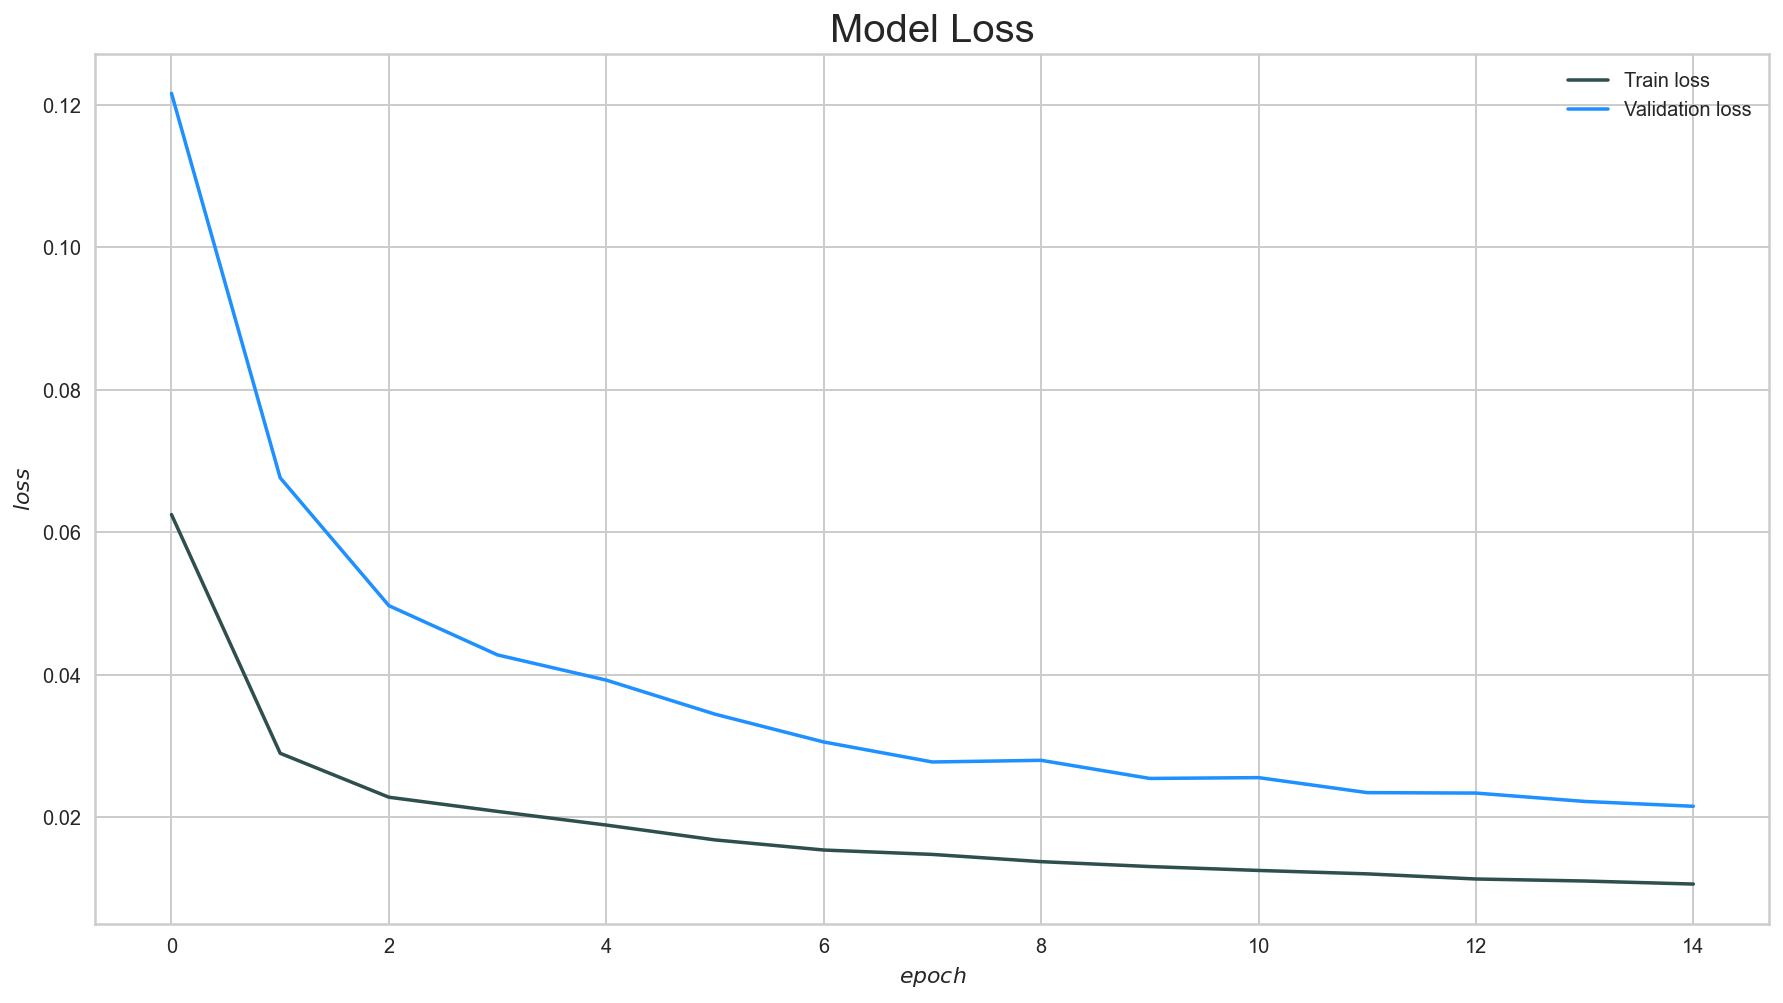

In [127]:
# plot model loss vs validation loss over epochs

plt.figure(figsize=(15,8))
plt.plot(history['loss'], 'darkslategrey')
plt.plot(history['val_loss'], 'dodgerblue')
plt.title('Model Loss', fontsize=20)
plt.ylabel('$loss$')
plt.xlabel('$epoch$')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plt.savefig('LSTM_evaluation_lossplot.png', transparent=False)

#plt.style.use('seaborn-dark-palette')
plt.grid(True)
plt.show()

In [128]:
y_pred = best_model.predict(X_test)

In [129]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [130]:
# re-transform data to scale for prediction comparision 

y_pred = y_pred.reshape(-1,1)

inv_ypred = np.concatenate((y_pred, X_test[:,1:]), axis=1)
inv_ypred = scaler.inverse_transform(inv_ypred)
inv_ypred = inv_ypred[:,0]

In [131]:
y_pred = y_pred.reshape(-1,1)

In [132]:
print(X_test.shape, y_pred.shape)

(80, 8) (80, 1)


In [133]:
y_test = y_test.reshape((len(y_test), 1))

inv_ytest = np.concatenate((y_test, X_test[:,1:]), axis=1)
inv_ytest = scaler.inverse_transform(inv_ytest)
inv_ytest = inv_ytest[:,0]

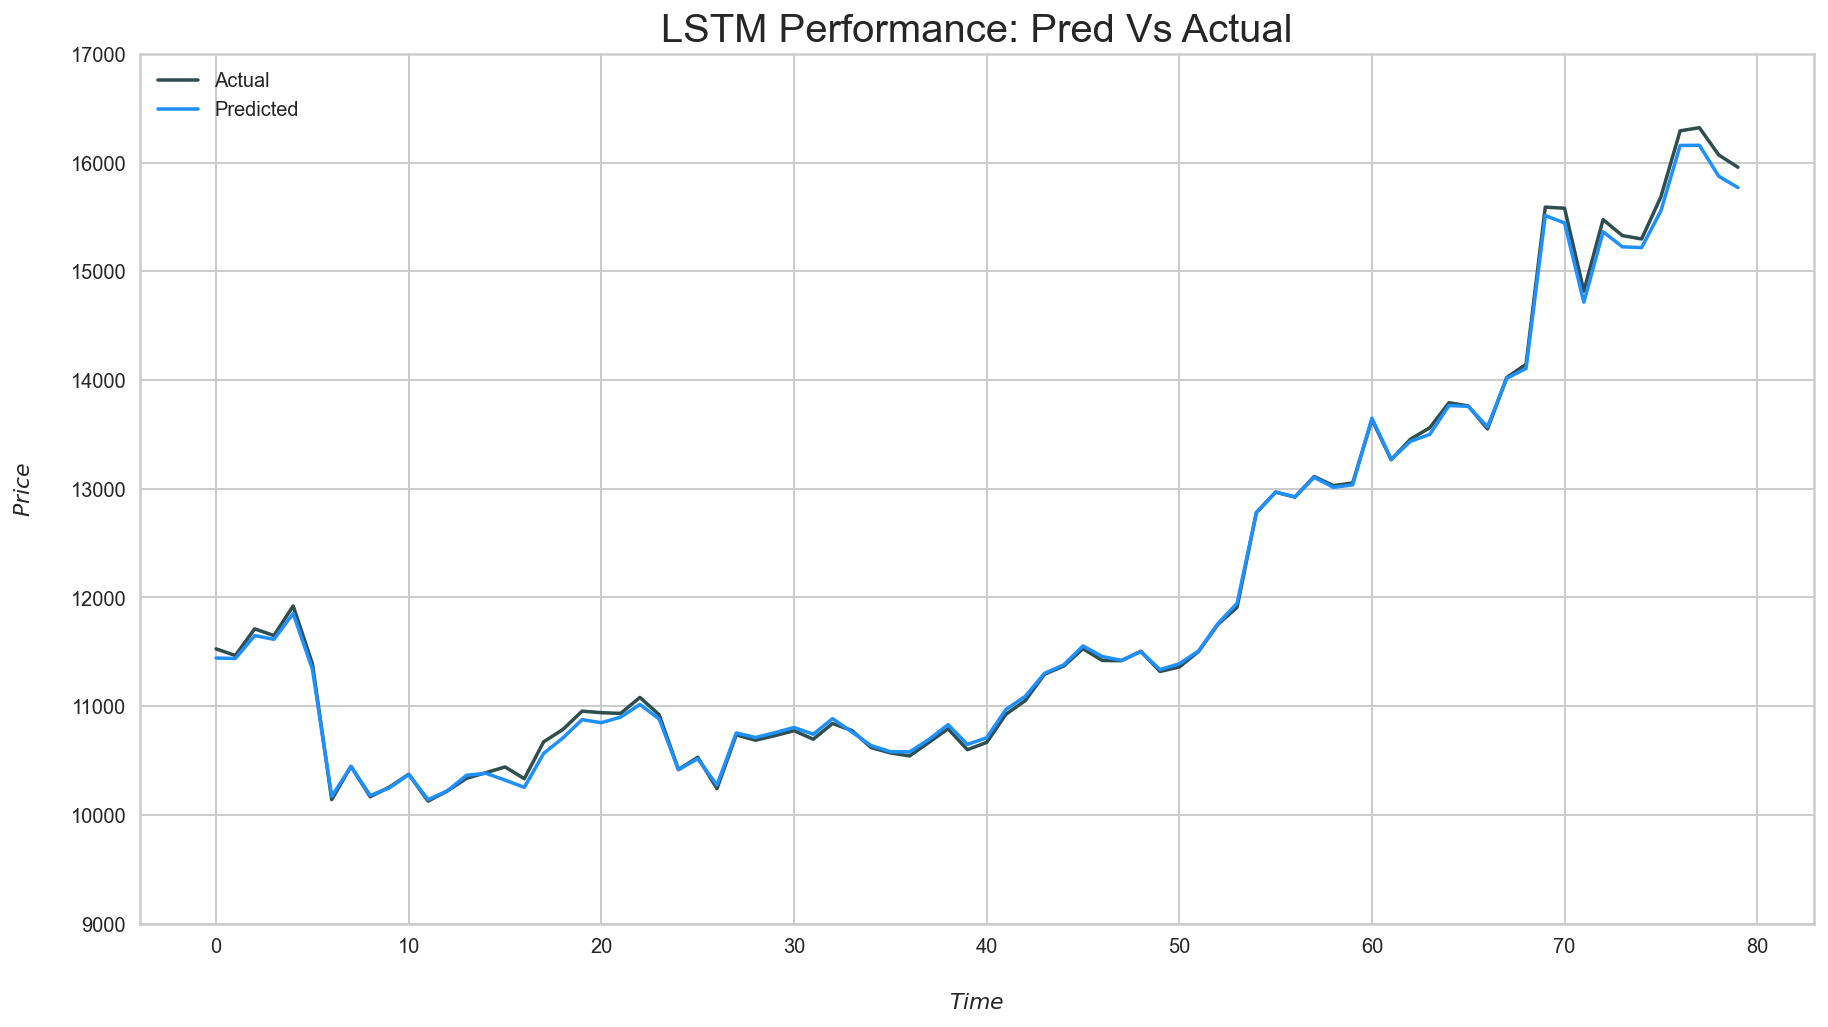

In [135]:
plt.figure(figsize=(15,8))
plt.plot(inv_ytest, 'darkslategrey', label='Actual')
plt.plot(inv_ypred, 'dodgerblue', label='Predicted')

plt.title('LSTM Performance: Pred Vs Actual', fontsize=20)
plt.ylabel('$Price$', labelpad=18, )
plt.yticks(np.arange(9000, 18000, 1000))
plt.xlabel('$Time$', labelpad=18)
plt.legend()

plt.savefig('LSTM_ActualVsPred_plot.png', transparent=False)
#plt.style.use('seaborn-dark-palette')
plt.grid(True)
plt.show()

In [136]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

def evaluate2(y_pred, y_test, label='Test Scores:\n'):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    variance = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print('{}  \nMSE:{} \nRMSE:{} \nR2:{} \nMAPE:{} \nMAE:{}'.format(label, mse, rmse, variance, mape, mae))

In [137]:
evaluate2(y_pred, y_test)

Test Scores:
  
MSE:2.947929294718031e-05 
RMSE:0.005429483672245485 
R2:0.9988030457913502 
MAPE:0.005774560640885634 
MAE:0.0038184488920751463


In [138]:
best_model.save('LSTM.h5')

## Conclusion and Findings

Overall, out of the 5 models ran, the Long Short Term Memory (LSTM) RNN performed the best. It achieved an R2 score of 0.9988 and received fairly low error scores. With the predictions of the LSTM being 0.005% (MAPE) different from the actual values of price. The error metrics, however, could be low because of the data scaling and distribution so there is a chance it might need to be corrected. Although, the correction if made should not make that big of a difference regarding performance. 

Aside from the LSTM, the second best performing model was the OLS receiving an R2 score of 0.9313 and an MAPE of 0.761, with the Lasso model following the OLS, not far off performance wise. Lasso had an R2 score of 0.9310 and an MAPE of 0.7621 meaning the Lasso performed a fraction of a percent worse than the OLS. Ridge performed the worst, which isn't that surprising as we chose these framework strategies knowing we were going for a sparse simple approach and Ridge deviates a little from that methodology.   

Surprisingly, the RFR produced mixed results, it scored 0.98 on the test set for R2 while the train set received a 0.91 R2. These results seem conflicting, especially when the OOB score was almost identical to the train score. Some further investigation will be need into its interpretability. 

Interpretability as a whole was fairly straight forward. We attained the coefficients for each model and it was clear that the "close" price had the most influence in increasing the targets value. This was expected as we saw how correlated it was early on through EDA. The "close" price is even more prominent as a feature when comparing coefficients to the respective models "LIME" results. Each Lime interpretation showed "close" price had overwhelming influence in model results. The Ridge model produced more balanced feature importances, which makes sense since it did the worst and failed to utilize how "impactful" the feature "close" is. 